In [1]:
import client
import server
import utils

In [2]:
import importlib
importlib.reload(client)
importlib.reload(server)
importlib.reload(utils)

<module 'utils' from '/Users/gael/Desktop/het-opl/src/utils.py'>

In [3]:
from tqdm.notebook import tqdm

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from vowpalwabbit.sklearn import VW
from sklearn.model_selection import train_test_split

In [4]:
np.random.seed(42)

### Generate data from heterogeneous clients

In [5]:
def generate_separated_vectors(n, k, L=1.0, num_vectors=4, max_iter=1000):
    vectors = np.zeros((num_vectors, n))
    for i in range(num_vectors):
        for _ in range(max_iter):
            vector = np.random.rand(n) * 2 * L - L
            if i == 0 or np.all(np.linalg.norm(vectors[:i] - vector, axis=1) >= k):
                vectors[i] = vector
                break
        else:
            raise RuntimeError(f"Failed to generate a vector separated by {k} after {max_iter} iterations.")
    return vectors

def generate_observational_data(num_clients, num_actions, num_features, train_sizes, test_sizes=None):
    if test_sizes is None:
        test_sizes = [10_000] * num_clients
        
    # Generate action parameters
    found_action_params = False
    while not found_action_params:
        action_params = generate_separated_vectors(num_features, np.sqrt(num_features), 1, 4)
        found_action_params = True
        for i in range(num_actions):
            other_vectors = np.delete(action_params, [i], axis=0)
            if not all(np.linalg.norm(action_params[i] - v) > np.sqrt(num_features) for v in other_vectors):
                found_action_params = False
    print("Found action params.")
    
#     # Generate context parameters
#     found_context_params = False
#     while not found_context_params:
#         context_params = generate_separated_vectors(num_features, np.sqrt(num_features), 1, 4)
#         found_context_params = True
#         for i in range(num_actions):
#             other_vectors = np.delete(context_params, [i], axis=0)
#             if not all(np.linalg.norm(context_params[i] - v) > np.sqrt(num_features) for v in other_vectors):
#                 found_context_params = False
#     print("Found context params.")
    
#     print(action_params-context_params)
    
    # Compute client weights
    weights = []
    for i in range(num_actions):
        other_vectors = np.delete(action_params, [i], axis=0)
        weights.append(sum([1/np.linalg.norm(action_params[i] - v) for v in other_vectors]))
    weights = [w / sum(weights) for w in weights]

    # Generate data
    data = {}
    aux = {}
    for client_id in range(num_clients):
        # Get num local samples, including test samples
        num_samples = train_sizes[client_id] + test_sizes[client_id]

        # Generate local data
        # contexts = np.random.multivariate_normal(mean=context_params[client_id], cov=np.eye(num_features), size=num_samples)
        contexts = np.random.normal(loc=0, scale=1, size=(num_samples, num_features)) 
        rewards_vectors = np.zeros((num_samples, num_actions))
        for i in range(num_samples):
            for a in range(num_actions):
                cx_i = contexts[i]
                ap_a = action_params[a]
                if client_id == 0:
                    rewards_vectors[i, a] += 5*np.sin(np.dot(cx_i, ap_a))
                else:
                    rewards_vectors[i, a] += np.dot(cx_i, ap_a)
                    if cx_i[0] > 0:
                        rewards_vectors[i, a] += -np.max([np.dot(cx_i, action_params[aprime]) for aprime in range(num_actions)]) 
        # actions = np.random.choice(num_actions, p=p, size=num_samples)
        actions = np.random.choice(num_actions, size=num_samples)
        epsilons = np.random.normal(loc=0, scale=1, size=(num_samples, num_actions))
        noisy_rewards_vectors = rewards_vectors + epsilons
        noisy_rewards = noisy_rewards_vectors[np.arange(num_samples), actions]
        
        # Get local train-test split
        (X_train, X_test,
         A_train, A_test,
         Y_train, Y_test,
         true_costs_train, true_costs_test) = train_test_split(contexts, actions, noisy_rewards, -rewards_vectors,
                                                               train_size=train_sizes[client_id],
                                                               shuffle=False)

        # Compute local AIPW scores
        crossfit_map, mu, e = utils.cross_fit_nuisance_params(X_train, A_train, Y_train, num_actions)
        AIPW_vectors = utils.compute_AIPW_scores(X_train, A_train, Y_train, num_actions, crossfit_map, mu, e)

        # Convert local data to VW format
        vw_data = utils.to_vw_format(X_train, A_train, -AIPW_vectors)

        # Store local data
        data[client_id] = vw_data
        aux[client_id] = {"X_train": X_train, "X_test": X_test,
                          "A_train": A_train, "A_test": A_test,
                          "Y_train": Y_train, "Y_test": Y_test,
                          "true_costs_train": true_costs_train, "true_costs_test": true_costs_test,
                          "weight": weights[client_id]}
    
    return data, aux

In [8]:
NUM_CLIENTS = 4
NUM_ACTIONS = 4
NUM_FEATURES = 10
TRAIN_SIZES = np.array([1, 1, 1, 1]) * 250_000
TEST_SIZES = np.array([1, 1, 1, 1]) * 10_000

# Generate data
data, aux = generate_observational_data(num_clients=NUM_CLIENTS,
                                        num_actions=NUM_ACTIONS,
                                        num_features=NUM_FEATURES,
                                        train_sizes=TRAIN_SIZES,
                                        test_sizes=TEST_SIZES)

In [ ]:
import pickle

# myvar = {"data": data, "aux": aux}
myvar = {"local_regrets": [local_regrets, local_regrets_std],
         "random_regrets": [random_regrets, random_regrets_std],
         "global_regrets": [global_regrets, global_regrets_std],
         "fed_local_regrets": [fed_local_regrets, fed_local_regrets_std],
         "global_regrets_w": [global_regrets_w, global_regrets_std_w],
         "fed_local_regrets_w": [fed_local_regrets_w, fed_local_regrets_std_w],
         "opt_local_models": opt_local_models,
         "opt_global_model": opt_global_model,
         "opt_global_model_w": opt_global_model_w
        }
  
# Open a file and use dump()
with open('regrets_real.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(myvar, file)

In [39]:
import pickle

with open('regrets_real.pkl', 'rb') as file:
      
    # Call load method to deserialze
    myvar = pickle.load(file)
  
    # data = myvar["data"]
    # aux = myvar["aux"]
    
    local_regrets, local_regrets_std = myvar["local_regrets"]
    global_regrets, global_regrets_std = myvar["global_regrets"]
    fed_local_regrets, fed_local_regrets_std = myvar["fed_local_regrets"]
    global_regrets_w, global_regrets_std_w = myvar["global_regrets_w"]
    fed_local_regrets_w, fed_local_regrets_std_w = myvar["fed_local_regrets_w"]
    opt_local_models = myvar["opt_local_models"]
    opt_global_model = myvar["opt_global_model"]
    opt_global_model_w = myvar["opt_global_model_w"]

### Train optimal local model

In [9]:
opt_local_models = {}
for client_id in range(NUM_CLIENTS):
    opt_local_model = VW(csoaa=NUM_ACTIONS,
                         convert_to_vw=False,
                         convert_labels=False,
                         passes=1)
    opt_local_model.fit(data[client_id])
    opt_local_models[client_id] = opt_local_model

    # Evaluate on test data
    X_test_vw = utils.to_vw_format(aux[client_id]["X_test"])
    regret, opt_reward, reward = utils.compute_regret(X_test_vw, aux[client_id]["true_costs_test"], opt_local_model)
    print(f"Local Client {client_id}: opt_reward={opt_reward}, reward={reward}, regret={regret}")

Local Client 0: opt_reward=3.7227702743798887, reward=2.142277613211763, regret=1.5804926611681278
Local Client 1: opt_reward=1.1194969650168611, reward=1.1183032915827245, regret=0.0011936734341359268
Local Client 2: opt_reward=1.107564367317708, reward=1.1062942434462042, regret=0.0012701238715038016
Local Client 3: opt_reward=1.1121557194196257, reward=1.1113904756888322, regret=0.000765243730793231


### Train local model

In [10]:
def train_local_policy(train_data, sample_size):
    assert len(train_data) >= sample_size
    
    # Train on local data
    model = VW(csoaa=NUM_ACTIONS,
               convert_to_vw=False,
               convert_labels=False,
               passes=1)
    model.fit(random.sample(train_data, sample_size))
    return model

def eval_local_policy(X_test, true_costs, model, opt_model=None):
    # Evaluate on test data
    X_test_vw = utils.to_vw_format(X_test)
    regret, opt_reward, reward = utils.compute_regret(X_test_vw, true_costs, model, opt_model)
    return regret, opt_reward, reward

def eval_random_policy(X_test, true_costs, opt_model=None):
    # Create random policy and evaluate on test data
    class Model():
        def predict(self, X):
            return np.random.choice(NUM_ACTIONS, size=len(X))
        
    X_test_vw = utils.to_vw_format(X_test)
    regret, opt_reward, reward = utils.compute_regret(X_test_vw, true_costs, Model(), opt_model)
    return regret, opt_reward, reward

In [8]:
ss_range = [10, 25, 50, 75, 100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000]

In [12]:
def run_local_training_experiments(data, aux, client_id, opt_local_model, num_iters=3):
    local_regrets_mean = []
    local_regrets_std = []
    random_regrets_mean = []
    random_regrets_std = []
    
    for sample_size in tqdm(ss_range):
        local_regret = 0
        random_regret = 0
        local_regret_iters = []
        random_regret_iters = []
        for i in range(num_iters):
            local_model = train_local_policy(data[client_id], sample_size)
            lr, _, _ = eval_local_policy(aux[client_id]["X_test"], aux[client_id]["true_costs_test"], local_model, opt_local_models[client_id])
            rr, _, _ = eval_random_policy(aux[client_id]["X_test"], aux[client_id]["true_costs_test"], opt_local_models[client_id])
            local_regret_iters.append(lr)
            random_regret_iters.append(rr)
        local_regrets_mean.append(np.mean(local_regret_iters))
        local_regrets_std.append(np.std(local_regret_iters))
        random_regrets_mean.append(np.mean(random_regret_iters))
        random_regrets_std.append(np.std(random_regret_iters))
        
    return (np.array(local_regrets_mean),
            np.array(local_regrets_std),
            np.array(random_regrets_mean),
            np.array(random_regrets_std))

In [41]:
local_regrets = {}
local_regrets_std = {}
random_regrets = {}
random_regrets_std = {}
for client_id in range(NUM_CLIENTS):
    local_regret, local_regret_std, random_regret, random_regret_std = run_local_training_experiments(data, aux, client_id, opt_local_models[client_id], num_iters=5)
    local_regrets[client_id] = local_regret
    local_regrets_std[client_id] = local_regret_std
    random_regrets[client_id] = random_regret
    random_regrets_std[client_id] = random_regret_std

  0%|          | 0/13 [00:00<?, ?it/s]

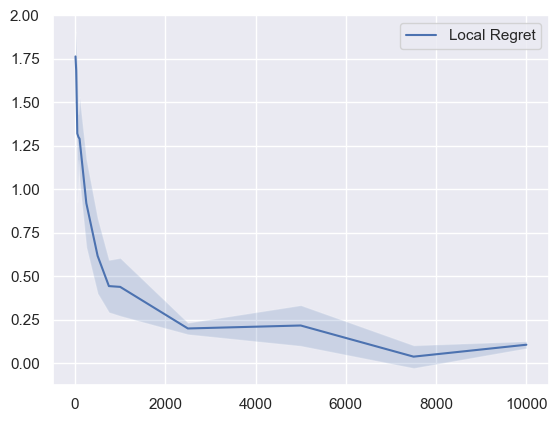

In [42]:
client_id = 0
x = ss_range
plt.plot(x, local_regrets[client_id], label='Local Regret')
plt.fill_between(x, local_regrets[client_id] - local_regrets_std[client_id], local_regrets[client_id] + local_regrets_std[client_id], alpha=0.2)

# plt.plot(x, random_regrets, label='Random Regret')
# plt.fill_between(x, random_regrets - random_regrets_std, random_regrets + random_regrets_std, alpha=0.2)

plt.legend()
plt.show()

### Train optimal global model (pooled)

In [16]:
# Aggregate all data
X_train = []
A_train = []
Y_train = []
true_costs_train = []
true_costs_test = []
X_test = []

idx_to_weight_mapping = {}
for client_id in range(NUM_CLIENTS):
    lo = len(X_train)
    X_train.extend(aux[client_id]["X_train"])
    hi = len(X_train)
    A_train.extend(aux[client_id]["A_train"])
    Y_train.extend(aux[client_id]["Y_train"])
    true_costs_train.extend(aux[client_id]["true_costs_train"])
    true_costs_test.extend(aux[client_id]["true_costs_test"])
    X_test.extend(aux[client_id]["X_test"])
    idx_to_weight_mapping.update({i:1 for i in range(lo, len(X_train))})
    
X_train = np.array(X_train)
A_train = np.array(A_train)
Y_train = np.array(Y_train)
true_costs_train = np.array(true_costs_train)
true_costs_test = np.array(true_costs_test)
X_test = np.array(X_test)

# Compute AIPW scores
crossfit_map, mu, e = utils.cross_fit_nuisance_params(X_train, A_train, Y_train, NUM_ACTIONS)
noisy_costs_train = -utils.compute_AIPW_scores(X_train, A_train, Y_train, NUM_ACTIONS, crossfit_map, mu, e)
data_train = utils.to_vw_format(X_train, A_train, noisy_costs_train, idx_to_weight_mapping)

# Train model
opt_global_model = VW(csoaa=NUM_ACTIONS,
                      convert_to_vw=False,
                      convert_labels=False,
                      passes=1)
opt_global_model.fit(data_train)

# Evaluate on test data
X_test_vw = utils.to_vw_format(X_test)
regret, opt_reward, reward = utils.compute_regret(X_test_vw, true_costs_test, opt_global_model, opt_model=None, idx_to_weight_mapping=idx_to_weight_mapping)
print(f"Aggregate: opt_reward={opt_reward}, reward={reward}, regret={regret}")

Aggregate: opt_reward=1.7654968315335184, reward=1.2552702595709626, regret=0.5102265719625689


### Train federated model (weighted)

In [17]:
NUM_ROUNDS = 1

def run_federated_training_experiments(data, aux, sample_size_fns, num_iters=3):

    local_regrets_mean = {k:[] for k in range(NUM_CLIENTS)}
    local_regrets_std = {k:[] for k in range(NUM_CLIENTS)}
    global_regrets_mean = []
    global_regrets_std = []
    for sample_size in tqdm(ss_range):
        local_regrets_iters = {k:[] for k in range(NUM_CLIENTS)}
        global_regret_iters = []
        for i in tqdm(range(num_iters)):

            # Subsample data
            data_mod = {}
            aux_mod = {}
            client_weights = []
            for client_id in range(NUM_CLIENTS):
                client_sample_size = sample_size_fns[client_id](sample_size)
                client_weights.append(client_sample_size)

                data_mod[client_id] = random.sample(data[client_id], client_sample_size)
                aux_mod[client_id] = {"X_test": aux[client_id]["X_test"],
                                      "true_costs_test": aux[client_id]["true_costs_test"]}
            client_weights = np.array(client_weights) / np.sum(client_weights)
            
            # Run federated learning
            global_vw = server.run_federated_learning(data_mod, aux_mod,
                                                      opt_global_model, opt_local_models,
                                                      num_features=NUM_FEATURES,
                                                      num_classes=NUM_ACTIONS,
                                                      num_rounds=NUM_ROUNDS,
                                                      num_clients=NUM_CLIENTS,
                                                      client_weights=client_weights)

            gr = global_vw.metrics_distributed["global_regret"][-1][1]
            global_regret_iters.append(gr)
            
            for client_id in range(NUM_CLIENTS):
                lr = global_vw.metrics_distributed["local_regrets"][-1][1][client_id]
                local_regrets_iters[client_id].append(lr)

        global_regrets_mean.append(np.mean(global_regret_iters))
        global_regrets_std.append(np.std(global_regret_iters))
        
        for client_id in range(NUM_CLIENTS):
            local_regrets_mean[client_id].append(np.mean(local_regrets_iters[client_id]))
            local_regrets_std[client_id].append(np.std(local_regrets_iters[client_id]))
            
    global_regrets_mean = np.array(global_regrets_mean)
    global_regrets_std = np.array(global_regrets_std)
    for client_id in range(NUM_CLIENTS):
        local_regrets_mean[client_id] = np.array(local_regrets_mean[client_id])
        local_regrets_std[client_id] = np.array(local_regrets_std[client_id])
        
    return (global_regrets_mean, global_regrets_std,
            local_regrets_mean, local_regrets_std)

In [43]:
client_0_sample_size_fn = lambda n: int(np.log(n))
sample_size_fns = {0: client_0_sample_size_fn,
                   1: lambda n: int((n-client_0_sample_size_fn(n))//(NUM_CLIENTS-1)),
                   2: lambda n: int((n-client_0_sample_size_fn(n))//(NUM_CLIENTS-1)),
                   3: lambda n: int((n-client_0_sample_size_fn(n))//(NUM_CLIENTS-1))}

global_regrets, global_regrets_std, fed_local_regrets, fed_local_regrets_std = run_federated_training_experiments(data, aux, sample_size_fns, num_iters=5)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 11:51:34,529 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:51:41,938	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 11:51:43,506 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0, 'memory': 6581804647.0}
INFO flwr 2023-05-15 11:51:43,507 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 11:51:43,508 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-05-15 11:51:45,098 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 11:51:45,099 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 11:51:45,099 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 11:51:45,100 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_get_parameters pid=24683) [Client 0] get_parameters
(launch_and_fit pid=24683) Client 2, training finished for round 1
(launch_and_fit pid=24683) [Client 2] get_parameters


DEBUG flwr 2023-05-15 11:51:46,467 | server.py:229 | fit_round 1 received 4 results and 0 failures


(launch_and_fit pid=24684) Client 1, training finished for round 1
(launch_and_fit pid=24684) [Client 1] get_parameters
(launch_and_fit pid=24679) Client 0, training finished for round 1
(launch_and_fit pid=24679) [Client 0] get_parameters
(launch_and_fit pid=24680) Client 3, training finished for round 1
(launch_and_fit pid=24680) [Client 3] get_parameters


WARNING flwr 2023-05-15 11:51:46,491 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:51:46,493 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24680) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24679) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=24683) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24684) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 11:51:47,749 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:51:47,750 | server.py:144 | FL finished in 2.649815650000164
INFO flwr 2023-05-15 11:51:47,752 | app.py:202 | app_fit: losses_distributed [(1, 1.925205437699884)]
INFO flwr 2023-05-15 11:51:47,753 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.255270259570951)], 'reward': [(1, -0.6699351781289329)], 'global_regret': [(1, 1.9252054376998844)], 'local_regrets': [(1, {0: 2.092898769048928, 1: 2.0302051336765206, 2: 2.031658813334728, 3: 2.003243620385081})]}
INFO flwr 2023-05-15 11:51:47,755 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:51:47,756 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:51:47,762 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:51:55,611	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 1

(launch_and_get_parameters pid=24703) [Client 1] get_parameters
(launch_and_fit pid=24703) Client 2, training finished for round 1
(launch_and_fit pid=24703) [Client 2] get_parameters


DEBUG flwr 2023-05-15 11:51:59,420 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:51:59,442 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:51:59,444 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24706) Client 1, training finished for round 1
(launch_and_fit pid=24706) [Client 1] get_parameters
(launch_and_fit pid=24700) Client 0, training finished for round 1
(launch_and_fit pid=24700) [Client 0] get_parameters
(launch_and_fit pid=24707) Client 3, training finished for round 1
(launch_and_fit pid=24707) [Client 3] get_parameters
(launch_and_evaluate pid=24703) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24706) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=24700) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24707) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 11:52:00,638 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:52:00,639 | server.py:144 | FL finished in 2.4635794130008435
INFO flwr 2023-05-15 11:52:00,640 | app.py:202 | app_fit: losses_distributed [(1, 1.779706476061506)]
INFO flwr 2023-05-15 11:52:00,641 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.255270259570951)], 'reward': [(1, -0.5244362164905526)], 'global_regret': [(1, 1.779706476061506)], 'local_regrets': [(1, {0: 1.9929457972680016, 1: 1.8605582038510475, 2: 1.86066095275402, 3: 1.8618455360186745})]}
INFO flwr 2023-05-15 11:52:00,642 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:52:00,643 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:52:00,650 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:52:07,055	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 

(launch_and_get_parameters pid=24724) [Client 3] get_parameters
(launch_and_fit pid=24724) Client 0, training finished for round 1
(launch_and_fit pid=24724) [Client 0] get_parameters


DEBUG flwr 2023-05-15 11:52:10,919 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:52:10,941 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:52:10,944 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24729) Client 3, training finished for round 1
(launch_and_fit pid=24729) [Client 3] get_parameters
(launch_and_fit pid=24727) Client 1, training finished for round 1
(launch_and_fit pid=24727) [Client 1] get_parameters
(launch_and_fit pid=24726) Client 2, training finished for round 1
(launch_and_fit pid=24726) [Client 2] get_parameters
(launch_and_evaluate pid=24724) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24729) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24727) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=24726) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 11:52:12,134 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:52:12,135 | server.py:144 | FL finished in 2.416036862998226
INFO flwr 2023-05-15 11:52:12,137 | app.py:202 | app_fit: losses_distributed [(1, 1.905427230047477)]
INFO flwr 2023-05-15 11:52:12,138 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.255270259570951)], 'reward': [(1, -0.6501569704765281)], 'global_regret': [(1, 1.905427230047477)], 'local_regrets': [(1, {0: 2.01151001280262, 1: 1.9857670735451618, 2: 2.077754946902886, 3: 2.0038614725849633})]}
INFO flwr 2023-05-15 11:52:12,139 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:52:12,140 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:52:12,146 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:52:19,232	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 12

(launch_and_get_parameters pid=24748) [Client 2] get_parameters
(launch_and_fit pid=24748) Client 1, training finished for round 1
(launch_and_fit pid=24748) [Client 1] get_parameters


DEBUG flwr 2023-05-15 11:52:23,053 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:52:23,076 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:52:23,078 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24746) Client 0, training finished for round 1
(launch_and_fit pid=24746) [Client 0] get_parameters
(launch_and_fit pid=24747) Client 3, training finished for round 1
(launch_and_fit pid=24747) [Client 3] get_parameters
(launch_and_fit pid=24749) Client 2, training finished for round 1
(launch_and_fit pid=24749) [Client 2] get_parameters
(launch_and_evaluate pid=24748) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=24746) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24747) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24749) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 11:52:24,245 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:52:24,245 | server.py:144 | FL finished in 2.477462081998965
INFO flwr 2023-05-15 11:52:24,247 | app.py:202 | app_fit: losses_distributed [(1, 1.670886379666112)]
INFO flwr 2023-05-15 11:52:24,248 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.255270259570951)], 'reward': [(1, -0.4156161200951616)], 'global_regret': [(1, 1.670886379666112)], 'local_regrets': [(1, {0: 1.7649451238521066, 1: 1.8631117374447803, 2: 1.7509845209859511, 3: 1.7616887220273323})]}
INFO flwr 2023-05-15 11:52:24,249 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:52:24,250 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:52:24,256 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:52:30,966	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at

(launch_and_get_parameters pid=24773) [Client 3] get_parameters
(launch_and_fit pid=24773) Client 1, training finished for round 1
(launch_and_fit pid=24773) [Client 1] get_parameters


DEBUG flwr 2023-05-15 11:52:34,658 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:52:34,676 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:52:34,678 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24768) Client 3, training finished for round 1
(launch_and_fit pid=24768) [Client 3] get_parameters
(launch_and_fit pid=24774) Client 0, training finished for round 1
(launch_and_fit pid=24774) [Client 0] get_parameters
(launch_and_fit pid=24771) Client 2, training finished for round 1
(launch_and_fit pid=24771) [Client 2] get_parameters
(launch_and_evaluate pid=24773) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24768) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=24774) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24771) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 11:52:35,850 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:52:35,851 | server.py:144 | FL finished in 2.40441044399995
INFO flwr 2023-05-15 11:52:35,853 | app.py:202 | app_fit: losses_distributed [(1, 1.6469888399524104)]
INFO flwr 2023-05-15 11:52:35,854 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.255270259570951)], 'reward': [(1, -0.3917185803814595)], 'global_regret': [(1, 1.6469888399524104)], 'local_regrets': [(1, {0: 1.7413326814349344, 1: 1.7449862449454714, 2: 1.7625332347033373, 3: 1.7962877843716167})]}
INFO flwr 2023-05-15 11:52:35,855 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:52:35,856 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 11:52:35,929 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:52:42,571	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 11:52:44,111 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0, 'memory': 6658883584.0}
INFO flwr 2023-05-15 11:52:44,112 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 11:52:44,113 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-05-15 11:52:45,193 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 11:52:45,194 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 11:52:45,194 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 11:52:45,195 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_get_parameters pid=24796) [Client 2] get_parameters
(launch_and_fit pid=24796) Client 1, training finished for round 1
(launch_and_fit pid=24796) [Client 1] get_parameters


DEBUG flwr 2023-05-15 11:52:46,403 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:52:46,423 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:52:46,425 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24795) Client 0, training finished for round 1
(launch_and_fit pid=24795) [Client 0] get_parameters
(launch_and_fit pid=24794) Client 2, training finished for round 1
(launch_and_fit pid=24794) [Client 2] get_parameters
(launch_and_fit pid=24793) Client 3, training finished for round 1
(launch_and_fit pid=24793) [Client 3] get_parameters
(launch_and_evaluate pid=24796) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24795) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24794) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24793) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 11:52:47,569 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:52:47,570 | server.py:144 | FL finished in 2.3752760650004348
INFO flwr 2023-05-15 11:52:47,572 | app.py:202 | app_fit: losses_distributed [(1, 0.8524075806209719)]
INFO flwr 2023-05-15 11:52:47,573 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.277957568382062)], 'reward': [(1, 0.4276845037383568)], 'global_regret': [(1, 0.8502730646437048)], 'local_regrets': [(1, {0: 0.864371561363017, 1: 0.8424827876713618, 2: 1.332915007158972, 3: 0.8270455519362524})]}
INFO flwr 2023-05-15 11:52:47,574 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:52:47,575 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:52:47,583 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:52:54,404	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at

(launch_and_get_parameters pid=24818) [Client 1] get_parameters
(launch_and_fit pid=24818) Client 1, training finished for round 1
(launch_and_fit pid=24818) [Client 1] get_parameters


DEBUG flwr 2023-05-15 11:52:58,174 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:52:58,194 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:52:58,196 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24815) Client 2, training finished for round 1
(launch_and_fit pid=24815) [Client 2] get_parameters
(launch_and_fit pid=24816) Client 3, training finished for round 1
(launch_and_fit pid=24816) [Client 3] get_parameters
(launch_and_fit pid=24814) Client 0, training finished for round 1
(launch_and_fit pid=24814) [Client 0] get_parameters
(launch_and_evaluate pid=24818) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24815) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24816) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24814) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 11:52:59,402 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:52:59,403 | server.py:144 | FL finished in 2.448362492999877
INFO flwr 2023-05-15 11:52:59,405 | app.py:202 | app_fit: losses_distributed [(1, 0.9352634986208112)]
INFO flwr 2023-05-15 11:52:59,406 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.279183353177099)], 'reward': [(1, 0.3472575766140241)], 'global_regret': [(1, 0.9319257765630766)], 'local_regrets': [(1, {0: 0.9548886087219863, 1: 1.0007439521866464, 2: 0.9687271067091222, 3: 1.2738789125111996})]}
INFO flwr 2023-05-15 11:52:59,408 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:52:59,409 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:52:59,416 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:53:05,160	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard a

(launch_and_get_parameters pid=24839) [Client 2] get_parameters
(launch_and_fit pid=24839) Client 2, training finished for round 1
(launch_and_fit pid=24839) [Client 2] get_parameters


DEBUG flwr 2023-05-15 11:53:09,122 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:53:09,141 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:53:09,143 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24835) Client 1, training finished for round 1
(launch_and_fit pid=24835) [Client 1] get_parameters
(launch_and_fit pid=24840) Client 0, training finished for round 1
(launch_and_fit pid=24840) [Client 0] get_parameters
(launch_and_fit pid=24838) Client 3, training finished for round 1
(launch_and_fit pid=24838) [Client 3] get_parameters
(launch_and_evaluate pid=24839) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24835) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24840) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=24838) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 11:53:10,311 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:53:10,312 | server.py:144 | FL finished in 2.37907062100021
INFO flwr 2023-05-15 11:53:10,314 | app.py:202 | app_fit: losses_distributed [(1, 0.9858596773074584)]
INFO flwr 2023-05-15 11:53:10,315 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.279942320010338)], 'reward': [(1, 0.29551669791996793)], 'global_regret': [(1, 0.9844256220903702)], 'local_regrets': [(1, {0: 0.9935203551215606, 1: 1.4747016224608385, 2: 0.9838602596591647, 3: 0.9485410576339774})]}
INFO flwr 2023-05-15 11:53:10,315 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:53:10,316 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:53:10,323 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:53:16,952	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard a

(launch_and_get_parameters pid=24860) [Client 0] get_parameters
(launch_and_fit pid=24860) Client 1, training finished for round 1
(launch_and_fit pid=24860) [Client 1] get_parameters


DEBUG flwr 2023-05-15 11:53:20,709 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:53:20,729 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:53:20,731 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24862) Client 0, training finished for round 1
(launch_and_fit pid=24862) [Client 0] get_parameters
(launch_and_fit pid=24859) Client 2, training finished for round 1
(launch_and_fit pid=24859) [Client 2] get_parameters
(launch_and_fit pid=24861) Client 3, training finished for round 1
(launch_and_fit pid=24861) [Client 3] get_parameters
(launch_and_evaluate pid=24860) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=24862) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24859) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24861) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 11:53:21,974 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:53:21,975 | server.py:144 | FL finished in 2.5028237759997864
INFO flwr 2023-05-15 11:53:21,977 | app.py:202 | app_fit: losses_distributed [(1, 1.017949459152409)]
INFO flwr 2023-05-15 11:53:21,978 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.277957568382062)], 'reward': [(1, 0.27455536674504366)], 'global_regret': [(1, 1.0034022016370208)], 'local_regrets': [(1, {0: 1.1043898891231794, 1: 1.2177767448950048, 2: 1.1139164050680157, 3: 1.0928993831691474})]}
INFO flwr 2023-05-15 11:53:21,978 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:53:21,979 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:53:21,986 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:53:27,665	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard 

(launch_and_get_parameters pid=24878) [Client 1] get_parameters
(launch_and_fit pid=24878) Client 2, training finished for round 1
(launch_and_fit pid=24878) [Client 2] get_parameters


DEBUG flwr 2023-05-15 11:53:31,591 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:53:31,613 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:53:31,615 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24883) Client 0, training finished for round 1
(launch_and_fit pid=24883) [Client 0] get_parameters
(launch_and_fit pid=24884) Client 3, training finished for round 1
(launch_and_fit pid=24884) [Client 3] get_parameters
(launch_and_fit pid=24880) Client 1, training finished for round 1
(launch_and_fit pid=24880) [Client 1] get_parameters
(launch_and_evaluate pid=24878) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24883) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=24884) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24880) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 11:53:32,883 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:53:32,884 | server.py:144 | FL finished in 2.55207376099861
INFO flwr 2023-05-15 11:53:32,886 | app.py:202 | app_fit: losses_distributed [(1, 0.843862946076831)]
INFO flwr 2023-05-15 11:53:32,887 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1839977967143054)], 'reward': [(1, 0.3133721258020298)], 'global_regret': [(1, 0.8706256709122762)], 'local_regrets': [(1, {0: 1.1426591735650917, 1: 0.9083774592971571, 2: 0.8748492995022894, 3: 0.9067504375885004})]}
INFO flwr 2023-05-15 11:53:32,888 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:53:32,889 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 11:53:32,981 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:53:38,583	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 11:53:39,991 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0, 'memory': 6666650829.0}
INFO flwr 2023-05-15 11:53:39,993 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 11:53:39,994 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-05-15 11:53:41,065 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 11:53:41,066 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 11:53:41,067 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 11:53:41,068 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_get_parameters pid=24908) [Client 3] get_parameters
(launch_and_fit pid=24908) Client 1, training finished for round 1
(launch_and_fit pid=24908) [Client 1] get_parameters


DEBUG flwr 2023-05-15 11:53:42,542 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:53:42,566 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:53:42,568 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24906) Client 2, training finished for round 1
(launch_and_fit pid=24906) [Client 2] get_parameters
(launch_and_fit pid=24905) Client 3, training finished for round 1
(launch_and_fit pid=24905) [Client 3] get_parameters
(launch_and_fit pid=24907) Client 0, training finished for round 1
(launch_and_fit pid=24907) [Client 0] get_parameters
(launch_and_evaluate pid=24908) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24906) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24905) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24907) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 11:53:43,975 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:53:43,976 | server.py:144 | FL finished in 2.9087474970001495
INFO flwr 2023-05-15 11:53:43,978 | app.py:202 | app_fit: losses_distributed [(1, 0.45957403236786404)]
INFO flwr 2023-05-15 11:53:43,980 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2893012227876177)], 'reward': [(1, 0.8409463806722819)], 'global_regret': [(1, 0.44835484211533627)], 'local_regrets': [(1, {0: 0.5036076782564165, 1: 0.49810123053845734, 2: 0.4963708882560745, 3: 0.7974009180662222})]}
INFO flwr 2023-05-15 11:53:43,981 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:53:43,982 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:53:43,989 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:53:50,087	INFO worker.py:1529 -- Started a local Ray instance. View the dashbo

(launch_and_get_parameters pid=24924) [Client 1] get_parameters
(launch_and_fit pid=24924) Client 2, training finished for round 1
(launch_and_fit pid=24924) [Client 2] get_parameters


DEBUG flwr 2023-05-15 11:53:53,809 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:53:53,831 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:53:53,833 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24925) Client 3, training finished for round 1
(launch_and_fit pid=24925) [Client 3] get_parameters
(launch_and_fit pid=24930) Client 1, training finished for round 1
(launch_and_fit pid=24930) [Client 1] get_parameters
(launch_and_fit pid=24926) Client 0, training finished for round 1
(launch_and_fit pid=24926) [Client 0] get_parameters
(launch_and_evaluate pid=24924) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24926) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=24925) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24930) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 11:53:55,262 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:53:55,262 | server.py:144 | FL finished in 2.674632047999694
INFO flwr 2023-05-15 11:53:55,264 | app.py:202 | app_fit: losses_distributed [(1, 0.6348926682054845)]
INFO flwr 2023-05-15 11:53:55,265 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1483615652859824)], 'reward': [(1, 0.5358788223491235)], 'global_regret': [(1, 0.6124827429368593)], 'local_regrets': [(1, {0: 1.183904945780914, 1: 0.6201706972368701, 2: 0.5884455227271054, 3: 0.6042340927227604})]}
INFO flwr 2023-05-15 11:53:55,267 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:53:55,268 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:53:55,275 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:54:01,796	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard a

(launch_and_get_parameters pid=24950) [Client 3] get_parameters
(launch_and_fit pid=24950) Client 3, training finished for round 1
(launch_and_fit pid=24950) [Client 3] get_parameters


DEBUG flwr 2023-05-15 11:54:06,111 | server.py:229 | fit_round 1 received 4 results and 0 failures


(launch_and_fit pid=24951) Client 1, training finished for round 1
(launch_and_fit pid=24951) [Client 1] get_parameters
(launch_and_fit pid=24953) Client 2, training finished for round 1
(launch_and_fit pid=24953) [Client 2] get_parameters
(launch_and_fit pid=24947) Client 0, training finished for round 1
(launch_and_fit pid=24947) [Client 0] get_parameters


WARNING flwr 2023-05-15 11:54:06,135 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:54:06,137 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24950) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24951) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24953) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24947) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 11:54:07,904 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:54:07,905 | server.py:144 | FL finished in 3.3517191409991938
INFO flwr 2023-05-15 11:54:07,908 | app.py:202 | app_fit: losses_distributed [(1, 0.863839342279238)]
INFO flwr 2023-05-15 11:54:07,909 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.292278350230031)], 'reward': [(1, 0.4237480103989591)], 'global_regret': [(1, 0.8685303398310729)], 'local_regrets': [(1, {0: 0.8441316985834711, 1: 0.8608731314959567, 2: 0.8410570973609376, 3: 1.3664800273223028})]}
INFO flwr 2023-05-15 11:54:07,911 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:54:07,912 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:54:07,921 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:54:13,884	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard a

(launch_and_get_parameters pid=24969) [Client 2] get_parameters
(launch_and_fit pid=24969) Client 0, training finished for round 1
(launch_and_fit pid=24969) [Client 0] get_parameters
(launch_and_fit pid=24972) Client 1, training finished for round 1
(launch_and_fit pid=24972) [Client 1] get_parameters
(launch_and_fit pid=24973) Client 2, training finished for round 1
(launch_and_fit pid=24973) [Client 2] get_parameters
(launch_and_fit pid=24975) Client 3, training finished for round 1
(launch_and_fit pid=24975) [Client 3] get_parameters


DEBUG flwr 2023-05-15 11:54:21,199 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:54:21,231 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:54:21,234 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24972) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24973) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=24975) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 11:54:24,362 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:54:24,364 | server.py:144 | FL finished in 5.42297008100104
INFO flwr 2023-05-15 11:54:24,367 | app.py:202 | app_fit: losses_distributed [(1, 0.839299631095077)]
INFO flwr 2023-05-15 11:54:24,369 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2893012227876177)], 'reward': [(1, 0.4779459439312981)], 'global_regret': [(1, 0.8113552788563203)], 'local_regrets': [(1, {0: 0.9502339249285436, 1: 0.9381559376541183, 2: 0.9317096980260516, 3: 0.9942835494173032})]}
INFO flwr 2023-05-15 11:54:24,372 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:54:24,374 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:54:24,391 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:54:33,155	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at

(launch_and_get_parameters pid=24997) [Client 0] get_parameters


INFO flwr 2023-05-15 11:54:46,705 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 11:54:46,708 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 11:54:46,723 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 11:54:46,741 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=24997) Client 2, training finished for round 1
(launch_and_fit pid=24997) [Client 2] get_parameters
(launch_and_fit pid=24995) Client 3, training finished for round 1
(launch_and_fit pid=24995) [Client 3] get_parameters
(launch_and_fit pid=24999) Client 1, training finished for round 1
(launch_and_fit pid=24999) [Client 1] get_parameters
(launch_and_fit pid=24994) Client 0, training finished for round 1
(launch_and_fit pid=24994) [Client 0] get_parameters


DEBUG flwr 2023-05-15 11:55:11,776 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:55:12,013 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:55:12,045 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=24997) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24999) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24994) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24995) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 11:55:50,884 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:55:50,888 | server.py:144 | FL finished in 64.14873457000067
INFO flwr 2023-05-15 11:55:50,921 | app.py:202 | app_fit: losses_distributed [(1, 0.5597706472546734)]
INFO flwr 2023-05-15 11:55:50,936 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.292278350230031)], 'reward': [(1, 0.7526523206788385)], 'global_regret': [(1, 0.5396260295511928)], 'local_regrets': [(1, {0: 0.6394054645801688, 1: 0.7570974461643354, 2: 0.6402313983585292, 3: 0.6595328655613738})]}
INFO flwr 2023-05-15 11:55:50,951 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:55:50,954 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 11:55:52,309 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:56:21,602	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 11:56:44,804 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 6660118528.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-05-15 11:56:44,819 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 11:56:44,838 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=25038) [Client 1] get_parameters


INFO flwr 2023-05-15 11:57:03,568 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 11:57:03,584 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 11:57:03,597 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 11:57:03,600 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25038) Client 2, training finished for round 1
(launch_and_fit pid=25038) [Client 2] get_parameters
(launch_and_fit pid=25034) Client 1, training finished for round 1
(launch_and_fit pid=25034) [Client 1] get_parameters
(launch_and_fit pid=25037) Client 0, training finished for round 1
(launch_and_fit pid=25037) [Client 0] get_parameters
(launch_and_fit pid=25032) Client 3, training finished for round 1
(launch_and_fit pid=25032) [Client 3] get_parameters


DEBUG flwr 2023-05-15 11:57:18,479 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:57:18,611 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:57:18,616 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25038) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25034) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25032) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25037) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 11:57:28,165 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:57:28,167 | server.py:144 | FL finished in 24.568136728001264
INFO flwr 2023-05-15 11:57:28,182 | app.py:202 | app_fit: losses_distributed [(1, 0.314724632639608)]
INFO flwr 2023-05-15 11:57:28,184 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1439680573016686)], 'reward': [(1, 0.8149309634200401)], 'global_regret': [(1, 0.32903709388163016)], 'local_regrets': [(1, {0: 0.7191072264738232, 1: 0.32328154051370694, 2: 0.3412983332056717, 3: 0.33239601601094526})]}
INFO flwr 2023-05-15 11:57:28,187 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:57:28,192 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:57:28,236 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:57:40,709	INFO worker.py:1529 -- Started a local Ray instance. View the dashboa

(launch_and_get_parameters pid=25068) [Client 3] get_parameters


INFO flwr 2023-05-15 11:57:49,164 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 11:57:49,166 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 11:57:49,169 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 11:57:49,172 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25068) Client 3, training finished for round 1
(launch_and_fit pid=25068) [Client 3] get_parameters
(launch_and_fit pid=25063) Client 0, training finished for round 1
(launch_and_fit pid=25063) [Client 0] get_parameters
(launch_and_fit pid=25065) Client 2, training finished for round 1
(launch_and_fit pid=25065) [Client 2] get_parameters
(launch_and_fit pid=25066) Client 1, training finished for round 1
(launch_and_fit pid=25066) [Client 1] get_parameters


DEBUG flwr 2023-05-15 11:57:53,477 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:57:53,535 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:57:53,539 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25068) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25063) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25065) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25066) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 11:57:58,776 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:57:58,779 | server.py:144 | FL finished in 9.606980757000201
INFO flwr 2023-05-15 11:57:58,784 | app.py:202 | app_fit: losses_distributed [(1, 0.16312779298316699)]
INFO flwr 2023-05-15 11:57:58,787 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.290699755522549)], 'reward': [(1, 1.1327801484383002)], 'global_regret': [(1, 0.15791960708424987)], 'local_regrets': [(1, {0: 0.18229507631534222, 1: 0.5532313131522023, 2: 0.19043518656969016, 3: 0.18373418154114743})]}
INFO flwr 2023-05-15 11:57:58,791 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:57:58,795 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:57:58,825 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:58:08,569	INFO worker.py:1529 -- Started a local Ray instance. View the dashbo

(launch_and_get_parameters pid=25091) [Client 2] get_parameters


INFO flwr 2023-05-15 11:58:15,421 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 11:58:15,423 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 11:58:15,425 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 11:58:15,427 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25091) Client 3, training finished for round 1
(launch_and_fit pid=25091) [Client 3] get_parameters
(launch_and_fit pid=25087) Client 2, training finished for round 1
(launch_and_fit pid=25087) [Client 2] get_parameters
(launch_and_fit pid=25092) Client 1, training finished for round 1
(launch_and_fit pid=25092) [Client 1] get_parameters
(launch_and_fit pid=25088) Client 0, training finished for round 1
(launch_and_fit pid=25088) [Client 0] get_parameters


DEBUG flwr 2023-05-15 11:58:18,725 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:58:18,771 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:58:18,775 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25091) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25087) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25092) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25088) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 11:58:22,544 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:58:22,546 | server.py:144 | FL finished in 7.118865161999565
INFO flwr 2023-05-15 11:58:22,550 | app.py:202 | app_fit: losses_distributed [(1, 0.23095414097715847)]
INFO flwr 2023-05-15 11:58:22,554 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.290699755522549)], 'reward': [(1, 1.0609321795821123)], 'global_regret': [(1, 0.22976757594043778)], 'local_regrets': [(1, {0: 0.23466993362826374, 1: 0.6603644865580109, 2: 0.24111061796563357, 3: 0.24485611140244004})]}
INFO flwr 2023-05-15 11:58:22,556 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:58:22,559 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:58:22,577 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:58:31,412	INFO worker.py:1529 -- Started a local Ray instance. View the dashbo

(launch_and_get_parameters pid=25114) [Client 3] get_parameters


INFO flwr 2023-05-15 11:58:37,737 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 11:58:37,739 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 11:58:37,741 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 11:58:37,743 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25114) Client 0, training finished for round 1
(launch_and_fit pid=25114) [Client 0] get_parameters
(launch_and_fit pid=25113) Client 3, training finished for round 1
(launch_and_fit pid=25113) [Client 3] get_parameters
(launch_and_fit pid=25110) Client 2, training finished for round 1
(launch_and_fit pid=25110) [Client 2] get_parameters
(launch_and_fit pid=25115) Client 1, training finished for round 1
(launch_and_fit pid=25115) [Client 1] get_parameters


DEBUG flwr 2023-05-15 11:58:40,877 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:58:40,916 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:58:40,919 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25114) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25110) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25113) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25115) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 11:58:44,148 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:58:44,150 | server.py:144 | FL finished in 6.4075012339999375
INFO flwr 2023-05-15 11:58:44,154 | app.py:202 | app_fit: losses_distributed [(1, 0.13416789786561398)]
INFO flwr 2023-05-15 11:58:44,156 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1439680573016686)], 'reward': [(1, 0.987243403115617)], 'global_regret': [(1, 0.1567246541860516)], 'local_regrets': [(1, {0: 0.5068750421880234, 1: 0.1628781804913418, 2: 0.1566251440614304, 3: 0.16747781036737608})]}
INFO flwr 2023-05-15 11:58:44,158 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:58:44,160 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:58:44,173 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:58:52,596	INFO worker.py:1529 -- Started a local Ray instance. View the dashboar

(launch_and_get_parameters pid=25135) [Client 1] get_parameters


INFO flwr 2023-05-15 11:58:58,437 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 11:58:58,439 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 11:58:58,440 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 11:58:58,442 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25135) Client 3, training finished for round 1
(launch_and_fit pid=25135) [Client 3] get_parameters
(launch_and_fit pid=25139) Client 2, training finished for round 1
(launch_and_fit pid=25139) [Client 2] get_parameters
(launch_and_fit pid=25141) Client 0, training finished for round 1
(launch_and_fit pid=25141) [Client 0] get_parameters
(launch_and_fit pid=25138) Client 1, training finished for round 1
(launch_and_fit pid=25138) [Client 1] get_parameters


DEBUG flwr 2023-05-15 11:59:01,088 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:59:01,126 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:59:01,130 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25135) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25139) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25141) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25138) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 11:59:04,232 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:59:04,233 | server.py:144 | FL finished in 5.791357853999216
INFO flwr 2023-05-15 11:59:04,237 | app.py:202 | app_fit: losses_distributed [(1, 0.3583607687073662)]
INFO flwr 2023-05-15 11:59:04,239 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2926139947915107)], 'reward': [(1, 0.9269827253674823)], 'global_regret': [(1, 0.36563126942402924)], 'local_regrets': [(1, {0: 0.3300255173928512, 1: 0.8932641575352988, 2: 0.3294206009213038, 3: 0.3379173846257234})]}
INFO flwr 2023-05-15 11:59:04,241 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:59:04,243 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 11:59:04,396 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:59:13,420	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 11:59:16,986 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'memory': 6644038452.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-05-15 11:59:16,988 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 11:59:16,990 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=25163) [Client 3] get_parameters


INFO flwr 2023-05-15 11:59:19,159 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 11:59:19,161 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 11:59:19,162 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 11:59:19,164 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25163) Client 1, training finished for round 1
(launch_and_fit pid=25163) [Client 1] get_parameters
(launch_and_fit pid=25168) Client 0, training finished for round 1
(launch_and_fit pid=25168) [Client 0] get_parameters
(launch_and_fit pid=25166) Client 3, training finished for round 1
(launch_and_fit pid=25166) [Client 3] get_parameters
(launch_and_fit pid=25167) Client 2, training finished for round 1
(launch_and_fit pid=25167) [Client 2] get_parameters


DEBUG flwr 2023-05-15 11:59:21,786 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:59:21,832 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:59:21,835 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25163) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25168) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25166) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25167) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 11:59:24,873 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:59:24,875 | server.py:144 | FL finished in 5.711339397999836
INFO flwr 2023-05-15 11:59:24,878 | app.py:202 | app_fit: losses_distributed [(1, 0.4351856322099051)]
INFO flwr 2023-05-15 11:59:24,880 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2933849383736176)], 'reward': [(1, 0.8763189833261473)], 'global_regret': [(1, 0.41706595504746957)], 'local_regrets': [(1, {0: 0.4990556498113301, 1: 0.49940344334228737, 2: 0.49858828326142085, 3: 0.7008797380702952})]}
INFO flwr 2023-05-15 11:59:24,882 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:59:24,883 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:59:24,900 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:59:33,065	INFO worker.py:1529 -- Started a local Ray instance. View the dashboa

(launch_and_get_parameters pid=25189) [Client 0] get_parameters


INFO flwr 2023-05-15 11:59:38,466 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 11:59:38,467 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 11:59:38,469 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 11:59:38,470 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25189) Client 0, training finished for round 1
(launch_and_fit pid=25189) [Client 0] get_parameters


DEBUG flwr 2023-05-15 11:59:40,816 | server.py:229 | fit_round 1 received 4 results and 0 failures


(launch_and_fit pid=25194) Client 2, training finished for round 1
(launch_and_fit pid=25194) [Client 2] get_parameters
(launch_and_fit pid=25195) Client 3, training finished for round 1
(launch_and_fit pid=25195) [Client 3] get_parameters
(launch_and_fit pid=25196) Client 1, training finished for round 1
(launch_and_fit pid=25196) [Client 1] get_parameters


WARNING flwr 2023-05-15 11:59:40,851 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:59:40,853 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25189) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25194) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25195) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25196) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 11:59:43,762 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 11:59:43,763 | server.py:144 | FL finished in 5.293176703000427
INFO flwr 2023-05-15 11:59:43,767 | app.py:202 | app_fit: losses_distributed [(1, 0.2616386041029983)]
INFO flwr 2023-05-15 11:59:43,769 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2954442568292797)], 'reward': [(1, 1.0313981778153516)], 'global_regret': [(1, 0.26404607901392924)], 'local_regrets': [(1, {0: 0.2526392571758707, 1: 0.2529967388677406, 2: 0.25336745764514884, 3: 0.7447355483689468})]}
INFO flwr 2023-05-15 11:59:43,771 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 11:59:43,773 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 11:59:43,791 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 11:59:51,112	INFO worker.py:1529 -- Started a local Ray instance. View the dashboar

(launch_and_get_parameters pid=25212) [Client 1] get_parameters


INFO flwr 2023-05-15 11:59:56,928 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 11:59:56,930 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 11:59:56,932 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 11:59:56,934 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25212) Client 3, training finished for round 1
(launch_and_fit pid=25212) [Client 3] get_parameters
(launch_and_fit pid=25213) Client 2, training finished for round 1
(launch_and_fit pid=25213) [Client 2] get_parameters
(launch_and_fit pid=25218) Client 1, training finished for round 1
(launch_and_fit pid=25218) [Client 1] get_parameters
(launch_and_fit pid=25217) Client 0, training finished for round 1
(launch_and_fit pid=25217) [Client 0] get_parameters


DEBUG flwr 2023-05-15 11:59:59,308 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 11:59:59,341 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 11:59:59,344 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25212) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25213) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25218) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25217) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 12:00:02,274 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:00:02,275 | server.py:144 | FL finished in 5.341992994000975
INFO flwr 2023-05-15 12:00:02,278 | app.py:202 | app_fit: losses_distributed [(1, 0.38655492782097944)]
INFO flwr 2023-05-15 12:00:02,281 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2967193211091206)], 'reward': [(1, 0.9337401934213903)], 'global_regret': [(1, 0.36297912768773105)], 'local_regrets': [(1, {0: 0.4698105605227249, 1: 0.6203010197562264, 2: 0.4501232238242549, 3: 0.46316949282642716})]}
INFO flwr 2023-05-15 12:00:02,283 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:00:02,285 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:00:02,301 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:00:10,890	INFO worker.py:1529 -- Started a local Ray instance. View the dashboa

(launch_and_get_parameters pid=25246) [Client 0] get_parameters


INFO flwr 2023-05-15 12:00:16,608 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:00:16,610 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:00:16,611 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:00:16,613 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25246) Client 2, training finished for round 1
(launch_and_fit pid=25246) [Client 2] get_parameters
(launch_and_fit pid=25248) Client 1, training finished for round 1
(launch_and_fit pid=25248) [Client 1] get_parameters
(launch_and_fit pid=25247) Client 3, training finished for round 1
(launch_and_fit pid=25247) [Client 3] get_parameters
(launch_and_fit pid=25251) Client 0, training finished for round 1
(launch_and_fit pid=25251) [Client 0] get_parameters


DEBUG flwr 2023-05-15 12:00:19,103 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:00:19,138 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:00:19,141 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25246) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25248) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25247) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25251) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 12:00:22,154 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:00:22,156 | server.py:144 | FL finished in 5.543380381999668
INFO flwr 2023-05-15 12:00:22,159 | app.py:202 | app_fit: losses_distributed [(1, 0.36817154248286)]
INFO flwr 2023-05-15 12:00:22,161 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2954442568292797)], 'reward': [(1, 0.9423695123055074)], 'global_regret': [(1, 0.35307474452377335)], 'local_regrets': [(1, {0: 0.42168745580579564, 1: 0.6707865330516457, 2: 0.4229646135617306, 3: 0.41443215315798315})]}
INFO flwr 2023-05-15 12:00:22,163 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:00:22,165 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:00:22,179 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:00:29,180	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard

(launch_and_get_parameters pid=25275) [Client 1] get_parameters


INFO flwr 2023-05-15 12:00:35,450 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:00:35,452 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:00:35,453 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:00:35,455 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25275) Client 3, training finished for round 1
(launch_and_fit pid=25275) [Client 3] get_parameters
(launch_and_fit pid=25269) Client 0, training finished for round 1
(launch_and_fit pid=25269) [Client 0] get_parameters
(launch_and_fit pid=25274) Client 2, training finished for round 1
(launch_and_fit pid=25274) [Client 2] get_parameters
(launch_and_fit pid=25272) Client 1, training finished for round 1
(launch_and_fit pid=25272) [Client 1] get_parameters


DEBUG flwr 2023-05-15 12:00:38,436 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:00:38,474 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:00:38,478 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25275) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25269) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25274) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25272) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 12:00:42,091 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:00:42,093 | server.py:144 | FL finished in 6.638293505999172
INFO flwr 2023-05-15 12:00:42,098 | app.py:202 | app_fit: losses_distributed [(1, 0.32705623859254446)]
INFO flwr 2023-05-15 12:00:42,100 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1355325219717862)], 'reward': [(1, 0.8468600302291739)], 'global_regret': [(1, 0.2886724917426146)], 'local_regrets': [(1, {0: 0.9235136252717959, 1: 0.28517651341417094, 2: 0.27602522790907164, 3: 0.28069417342085284})]}
INFO flwr 2023-05-15 12:00:42,102 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:00:42,106 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 12:00:42,292 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:00:52,125	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 12:00:56,085 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'memory': 6642840372.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0}
INFO flwr 2023-05-15 12:00:56,088 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 12:00:56,094 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=25295) [Client 2] get_parameters


INFO flwr 2023-05-15 12:00:59,223 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:00:59,225 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:00:59,227 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:00:59,229 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25295) Client 1, training finished for round 1
(launch_and_fit pid=25295) [Client 1] get_parameters
(launch_and_fit pid=25296) Client 2, training finished for round 1
(launch_and_fit pid=25296) [Client 2] get_parameters
(launch_and_fit pid=25299) Client 3, training finished for round 1
(launch_and_fit pid=25299) [Client 3] get_parameters
(launch_and_fit pid=25300) Client 0, training finished for round 1
(launch_and_fit pid=25300) [Client 0] get_parameters


DEBUG flwr 2023-05-15 12:01:02,847 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:01:02,894 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:01:02,898 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25295) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25296) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25300) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 12:01:07,684 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:01:07,686 | server.py:144 | FL finished in 8.45792949800125
INFO flwr 2023-05-15 12:01:07,689 | app.py:202 | app_fit: losses_distributed [(1, 0.22153578867497148)]
INFO flwr 2023-05-15 12:01:07,691 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.29923949620161)], 'reward': [(1, 1.0786938612502526)], 'global_regret': [(1, 0.2205456349513584)], 'local_regrets': [(1, {0: 0.22436559436995154, 1: 0.2343495206491863, 2: 0.6574114766634076, 3: 0.22720114866305488})]}
INFO flwr 2023-05-15 12:01:07,694 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:01:07,696 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:01:07,726 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:01:17,530	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard 

(launch_and_get_parameters pid=25318) [Client 0] get_parameters


INFO flwr 2023-05-15 12:01:25,195 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:01:25,197 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:01:25,199 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:01:25,203 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25318) Client 0, training finished for round 1
(launch_and_fit pid=25318) [Client 0] get_parameters
(launch_and_fit pid=25323) Client 1, training finished for round 1
(launch_and_fit pid=25323) [Client 1] get_parameters
(launch_and_fit pid=25321) Client 2, training finished for round 1
(launch_and_fit pid=25321) [Client 2] get_parameters
(launch_and_fit pid=25325) Client 3, training finished for round 1
(launch_and_fit pid=25325) [Client 3] get_parameters


DEBUG flwr 2023-05-15 12:01:29,507 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:01:29,561 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:01:29,566 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25318) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25323) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25321) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25325) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 12:01:34,492 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:01:34,494 | server.py:144 | FL finished in 9.29163581300054
INFO flwr 2023-05-15 12:01:34,497 | app.py:202 | app_fit: losses_distributed [(1, 0.12456612628821888)]
INFO flwr 2023-05-15 12:01:34,500 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.29923949620161)], 'reward': [(1, 1.178889612903434)], 'global_regret': [(1, 0.1203498832981767)], 'local_regrets': [(1, {0: 0.13792317064207293, 1: 0.5555548841479092, 2: 0.1262455443074298, 3: 0.13572549170117854})]}
INFO flwr 2023-05-15 12:01:34,503 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:01:34,506 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:01:34,536 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:01:44,796	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard a

(launch_and_get_parameters pid=25345) [Client 2] get_parameters


INFO flwr 2023-05-15 12:01:52,849 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:01:52,851 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:01:52,854 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:01:52,857 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25345) Client 2, training finished for round 1
(launch_and_fit pid=25345) [Client 2] get_parameters
(launch_and_fit pid=25342) Client 1, training finished for round 1
(launch_and_fit pid=25342) [Client 1] get_parameters
(launch_and_fit pid=25347) Client 0, training finished for round 1
(launch_and_fit pid=25347) [Client 0] get_parameters
(launch_and_fit pid=25348) Client 3, training finished for round 1
(launch_and_fit pid=25348) [Client 3] get_parameters


DEBUG flwr 2023-05-15 12:01:57,098 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:01:57,151 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:01:57,156 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25345) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25342) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25347) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25348) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 12:02:02,357 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:02:02,359 | server.py:144 | FL finished in 9.502912469999501
INFO flwr 2023-05-15 12:02:02,362 | app.py:202 | app_fit: losses_distributed [(1, 0.1606983124661727)]
INFO flwr 2023-05-15 12:02:02,365 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3006350158627265)], 'reward': [(1, 1.1401476656005864)], 'global_regret': [(1, 0.16048735026214073)], 'local_regrets': [(1, {0: 0.16044306195932342, 1: 0.17204383269240237, 2: 0.1720670718574504, 3: 0.5954238690012278})]}
INFO flwr 2023-05-15 12:02:02,367 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:02:02,370 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:02:02,403 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:02:12,041	INFO worker.py:1529 -- Started a local Ray instance. View the dashboa

(launch_and_get_parameters pid=25371) [Client 0] get_parameters


INFO flwr 2023-05-15 12:02:18,981 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:02:18,983 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:02:18,985 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:02:18,988 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25371) Client 0, training finished for round 1
(launch_and_fit pid=25371) [Client 0] get_parameters
(launch_and_fit pid=25368) Client 2, training finished for round 1
(launch_and_fit pid=25368) [Client 2] get_parameters
(launch_and_fit pid=25373) Client 1, training finished for round 1
(launch_and_fit pid=25373) [Client 1] get_parameters
(launch_and_fit pid=25375) Client 3, training finished for round 1
(launch_and_fit pid=25375) [Client 3] get_parameters


DEBUG flwr 2023-05-15 12:02:22,469 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:02:22,511 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:02:22,515 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25371) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25368) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25373) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25375) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 12:02:25,975 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:02:25,976 | server.py:144 | FL finished in 6.988945368000714
INFO flwr 2023-05-15 12:02:25,979 | app.py:202 | app_fit: losses_distributed [(1, 0.18314693316554512)]
INFO flwr 2023-05-15 12:02:25,981 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.29923949620161)], 'reward': [(1, 1.1150130178705977)], 'global_regret': [(1, 0.18422647833101266)], 'local_regrets': [(1, {0: 0.1792229845908936, 1: 0.19390393689497792, 2: 0.6302414108490044, 3: 0.186403985973018})]}
INFO flwr 2023-05-15 12:02:25,984 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:02:25,986 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:02:26,015 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:02:33,824	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard 

(launch_and_get_parameters pid=25397) [Client 0] get_parameters


INFO flwr 2023-05-15 12:02:40,084 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:02:40,085 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:02:40,087 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:02:40,089 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25397) Client 2, training finished for round 1
(launch_and_fit pid=25397) [Client 2] get_parameters
(launch_and_fit pid=25398) Client 0, training finished for round 1
(launch_and_fit pid=25398) [Client 0] get_parameters
(launch_and_fit pid=25391) Client 1, training finished for round 1
(launch_and_fit pid=25391) [Client 1] get_parameters
(launch_and_fit pid=25393) Client 3, training finished for round 1
(launch_and_fit pid=25393) [Client 3] get_parameters


DEBUG flwr 2023-05-15 12:02:42,937 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:02:42,974 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:02:42,977 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25397) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25393) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25398) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25391) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 12:02:45,889 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:02:45,891 | server.py:144 | FL finished in 5.802349379999214
INFO flwr 2023-05-15 12:02:45,894 | app.py:202 | app_fit: losses_distributed [(1, 0.14377944367523202)]
INFO flwr 2023-05-15 12:02:45,896 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2969856338365422)], 'reward': [(1, 1.1505928446689184)], 'global_regret': [(1, 0.14639278916762444)], 'local_regrets': [(1, {0: 0.1344085695784978, 1: 0.628646515451706, 2: 0.13452404036228788, 3: 0.13472323495415017})]}
INFO flwr 2023-05-15 12:02:45,898 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:02:45,900 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 12:02:46,062 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:02:54,947	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 12:02:58,312 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'memory': 6615067034.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-05-15 12:02:58,314 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 12:02:58,316 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=25418) [Client 1] get_parameters


INFO flwr 2023-05-15 12:03:00,380 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:03:00,381 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:03:00,382 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:03:00,384 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25418) Client 1, training finished for round 1
(launch_and_fit pid=25418) [Client 1] get_parameters
(launch_and_fit pid=25420) Client 3, training finished for round 1
(launch_and_fit pid=25420) [Client 3] get_parameters
(launch_and_fit pid=25419) Client 2, training finished for round 1
(launch_and_fit pid=25419) [Client 2] get_parameters
(launch_and_fit pid=25421) Client 0, training finished for round 1
(launch_and_fit pid=25421) [Client 0] get_parameters


DEBUG flwr 2023-05-15 12:03:02,862 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:03:02,895 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:03:02,898 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25421) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25418) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25420) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25419) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 12:03:05,482 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:03:05,483 | server.py:144 | FL finished in 5.09976604700023
INFO flwr 2023-05-15 12:03:05,485 | app.py:202 | app_fit: losses_distributed [(1, 0.06070370969037641)]
INFO flwr 2023-05-15 12:03:05,486 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3022363505278558)], 'reward': [(1, 1.2469162506873743)], 'global_regret': [(1, 0.05532009984048138)], 'local_regrets': [(1, {0: 0.07672864927313705, 1: 0.46103399466054407, 2: 0.08338613268132393, 3: 0.07885064779221491})]}
INFO flwr 2023-05-15 12:03:05,488 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:03:05,490 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:03:05,513 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:03:12,404	INFO worker.py:1529 -- Started a local Ray instance. View the dashb

(launch_and_get_parameters pid=25445) [Client 1] get_parameters


INFO flwr 2023-05-15 12:03:18,087 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:03:18,088 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:03:18,090 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:03:18,091 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25445) Client 1, training finished for round 1
(launch_and_fit pid=25445) [Client 1] get_parameters
(launch_and_fit pid=25438) Client 0, training finished for round 1
(launch_and_fit pid=25438) [Client 0] get_parameters
(launch_and_fit pid=25440) Client 2, training finished for round 1
(launch_and_fit pid=25440) [Client 2] get_parameters
(launch_and_fit pid=25439) Client 3, training finished for round 1
(launch_and_fit pid=25439) [Client 3] get_parameters


DEBUG flwr 2023-05-15 12:03:20,417 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:03:20,451 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:03:20,455 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25445) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25440) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25439) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 12:03:23,650 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:03:23,652 | server.py:144 | FL finished in 5.561242653999216
INFO flwr 2023-05-15 12:03:23,655 | app.py:202 | app_fit: losses_distributed [(1, 0.07756093851053242)]
INFO flwr 2023-05-15 12:03:23,658 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.298458148633066)], 'reward': [(1, 1.2214224666590752)], 'global_regret': [(1, 0.07703568197399045)], 'local_regrets': [(1, {0: 0.0783733788016186, 1: 0.5395677556831046, 2: 0.07310044004247357, 3: 0.07638676516064705})]}
INFO flwr 2023-05-15 12:03:23,659 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:03:23,661 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:03:23,686 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:03:32,663	INFO worker.py:1529 -- Started a local Ray instance. View the dashboa

(launch_and_get_parameters pid=25466) [Client 3] get_parameters


INFO flwr 2023-05-15 12:03:38,261 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:03:38,262 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:03:38,264 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25466) Client 0, training finished for round 1
(launch_and_fit pid=25466) [Client 0] get_parameters
(launch_and_fit pid=25467) Client 1, training finished for round 1
(launch_and_fit pid=25467) [Client 1] get_parameters
(launch_and_fit pid=25463) Client 3, training finished for round 1
(launch_and_fit pid=25463) [Client 3] get_parameters
(launch_and_fit pid=25464) Client 2, training finished for round 1
(launch_and_fit pid=25464) [Client 2] get_parameters


DEBUG flwr 2023-05-15 12:03:40,586 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:03:40,619 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:03:40,622 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25466) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25467) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25463) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25464) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 12:03:43,968 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:03:43,970 | server.py:144 | FL finished in 5.706050741999206
INFO flwr 2023-05-15 12:03:43,973 | app.py:202 | app_fit: losses_distributed [(1, 0.06663250318143794)]
INFO flwr 2023-05-15 12:03:43,975 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3022363505278558)], 'reward': [(1, 1.2376844298846648)], 'global_regret': [(1, 0.06455192064319289)], 'local_regrets': [(1, {0: 0.0722466351616562, 1: 0.07485478576191718, 2: 0.5040488114644673, 3: 0.07256436598342549})]}
INFO flwr 2023-05-15 12:03:43,977 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:03:43,980 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:03:44,006 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:03:51,992	INFO worker.py:1529 -- Started a local Ray instance. View the dashbo

(launch_and_get_parameters pid=25491) [Client 3] get_parameters


INFO flwr 2023-05-15 12:03:58,058 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:03:58,060 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:03:58,062 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:03:58,064 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25491) Client 2, training finished for round 1
(launch_and_fit pid=25491) [Client 2] get_parameters
(launch_and_fit pid=25492) Client 0, training finished for round 1
(launch_and_fit pid=25492) [Client 0] get_parameters
(launch_and_fit pid=25493) Client 1, training finished for round 1
(launch_and_fit pid=25493) [Client 1] get_parameters
(launch_and_fit pid=25489) Client 3, training finished for round 1
(launch_and_fit pid=25489) [Client 3] get_parameters


DEBUG flwr 2023-05-15 12:04:00,781 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:04:00,819 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:04:00,823 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25491) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25492) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25493) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25489) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 12:04:04,346 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:04:04,348 | server.py:144 | FL finished in 6.285001947000637
INFO flwr 2023-05-15 12:04:04,351 | app.py:202 | app_fit: losses_distributed [(1, 0.06119165084286133)]
INFO flwr 2023-05-15 12:04:04,355 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.119594968831794)], 'reward': [(1, 1.053970497524083)], 'global_regret': [(1, 0.06562447130771148)], 'local_regrets': [(1, {0: 0.5065924261317974, 1: 0.06473674842602446, 2: 0.06238257982587864, 3: 0.06823943463345974})]}
INFO flwr 2023-05-15 12:04:04,359 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:04:04,367 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:04:04,442 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:04:14,042	INFO worker.py:1529 -- Started a local Ray instance. View the dashboa

(launch_and_get_parameters pid=25523) [Client 3] get_parameters


INFO flwr 2023-05-15 12:04:21,403 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:04:21,405 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:04:21,407 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:04:21,410 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25523) Client 3, training finished for round 1
(launch_and_fit pid=25523) [Client 3] get_parameters
(launch_and_fit pid=25521) Client 2, training finished for round 1
(launch_and_fit pid=25521) [Client 2] get_parameters
(launch_and_fit pid=25519) Client 1, training finished for round 1
(launch_and_fit pid=25519) [Client 1] get_parameters
(launch_and_fit pid=25522) Client 0, training finished for round 1
(launch_and_fit pid=25522) [Client 0] get_parameters


DEBUG flwr 2023-05-15 12:04:25,084 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:04:25,142 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:04:25,146 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25523) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25521) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25519) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25522) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 12:04:30,016 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:04:30,018 | server.py:144 | FL finished in 8.608678122998754
INFO flwr 2023-05-15 12:04:30,024 | app.py:202 | app_fit: losses_distributed [(1, 0.06699201420217141)]
INFO flwr 2023-05-15 12:04:30,027 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.119594968831794)], 'reward': [(1, 1.0520080151322528)], 'global_regret': [(1, 0.0675869536995421)], 'local_regrets': [(1, {0: 0.5244894016544293, 1: 0.06689368321332421, 2: 0.06840295113056763, 3: 0.06536660645607985})]}
INFO flwr 2023-05-15 12:04:30,029 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:04:30,034 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 12:04:30,298 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:04:40,310	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 12:04:44,580 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'node:127.0.0.1': 1.0, 'memory': 6610580685.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-05-15 12:04:44,582 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 12:04:44,585 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=25546) [Client 3] get_parameters


INFO flwr 2023-05-15 12:04:47,849 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:04:47,851 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:04:47,854 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:04:47,856 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25546) Client 3, training finished for round 1
(launch_and_fit pid=25546) [Client 3] get_parameters
(launch_and_fit pid=25542) Client 0, training finished for round 1
(launch_and_fit pid=25542) [Client 0] get_parameters
(launch_and_fit pid=25544) Client 2, training finished for round 1
(launch_and_fit pid=25544) [Client 2] get_parameters
(launch_and_fit pid=25547) Client 1, training finished for round 1
(launch_and_fit pid=25547) [Client 1] get_parameters


DEBUG flwr 2023-05-15 12:04:51,456 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:04:51,506 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:04:51,510 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25546) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25542) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25544) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25547) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 12:04:55,383 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:04:55,385 | server.py:144 | FL finished in 7.529703973999858
INFO flwr 2023-05-15 12:04:55,388 | app.py:202 | app_fit: losses_distributed [(1, 0.04492233404480187)]
INFO flwr 2023-05-15 12:04:55,393 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3030353685816036)], 'reward': [(1, 1.2580010720481007)], 'global_regret': [(1, 0.04503429653350427)], 'local_regrets': [(1, {0: 0.04363168937237943, 1: 0.04482889242362116, 2: 0.045996151487301094, 3: 0.5024171885416209})]}
INFO flwr 2023-05-15 12:04:55,395 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:04:55,398 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:04:55,431 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:05:03,707	INFO worker.py:1529 -- Started a local Ray instance. View the dash

(launch_and_get_parameters pid=25565) [Client 0] get_parameters


INFO flwr 2023-05-15 12:05:09,948 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:05:09,949 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:05:09,951 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:05:09,953 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25565) Client 2, training finished for round 1
(launch_and_fit pid=25565) [Client 2] get_parameters
(launch_and_fit pid=25566) Client 3, training finished for round 1
(launch_and_fit pid=25566) [Client 3] get_parameters
(launch_and_fit pid=25569) Client 1, training finished for round 1
(launch_and_fit pid=25569) [Client 1] get_parameters
(launch_and_fit pid=25570) Client 0, training finished for round 1
(launch_and_fit pid=25570) [Client 0] get_parameters


DEBUG flwr 2023-05-15 12:05:13,317 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:05:13,357 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:05:13,361 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25565) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25566) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25569) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25570) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 12:05:17,097 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:05:17,099 | server.py:144 | FL finished in 7.146315402000255
INFO flwr 2023-05-15 12:05:17,102 | app.py:202 | app_fit: losses_distributed [(1, 0.06999197359874026)]
INFO flwr 2023-05-15 12:05:17,104 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3015660087924534)], 'reward': [(1, 1.234444060985771)], 'global_regret': [(1, 0.06712194780668387)], 'local_regrets': [(1, {0: 0.07848545938674184, 1: 0.08272379911627101, 2: 0.07515600821404228, 3: 0.5007872133236206})]}
INFO flwr 2023-05-15 12:05:17,106 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:05:17,109 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:05:17,174 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:05:25,434	INFO worker.py:1529 -- Started a local Ray instance. View the dashbo

(launch_and_get_parameters pid=25591) [Client 2] get_parameters


INFO flwr 2023-05-15 12:05:31,665 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:05:31,667 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:05:31,668 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:05:31,670 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25591) Client 1, training finished for round 1
(launch_and_fit pid=25591) [Client 1] get_parameters
(launch_and_fit pid=25589) Client 3, training finished for round 1
(launch_and_fit pid=25589) [Client 3] get_parameters
(launch_and_fit pid=25588) Client 2, training finished for round 1
(launch_and_fit pid=25588) [Client 2] get_parameters
(launch_and_fit pid=25593) Client 0, training finished for round 1
(launch_and_fit pid=25593) [Client 0] get_parameters


DEBUG flwr 2023-05-15 12:05:34,338 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:05:34,379 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:05:34,382 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25591) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25589) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25588) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25593) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 12:05:37,685 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:05:37,687 | server.py:144 | FL finished in 6.016926630998569
INFO flwr 2023-05-15 12:05:37,689 | app.py:202 | app_fit: losses_distributed [(1, 0.07665087219395984)]
INFO flwr 2023-05-15 12:05:37,692 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.117286771480485)], 'reward': [(1, 1.0299024644827786)], 'global_regret': [(1, 0.08738430699770672)], 'local_regrets': [(1, {0: 0.5027586714105526, 1: 0.09011386806054927, 2: 0.0862339269089968, 3: 0.08468160804145577})]}
INFO flwr 2023-05-15 12:05:37,693 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:05:37,695 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:05:37,722 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:05:46,318	INFO worker.py:1529 -- Started a local Ray instance. View the dashboa

(launch_and_get_parameters pid=25619) [Client 0] get_parameters


INFO flwr 2023-05-15 12:05:52,313 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:05:52,314 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:05:52,315 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:05:52,317 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25619) Client 2, training finished for round 1
(launch_and_fit pid=25619) [Client 2] get_parameters
(launch_and_fit pid=25614) Client 1, training finished for round 1
(launch_and_fit pid=25614) [Client 1] get_parameters
(launch_and_fit pid=25621) Client 3, training finished for round 1
(launch_and_fit pid=25621) [Client 3] get_parameters
(launch_and_fit pid=25620) Client 0, training finished for round 1
(launch_and_fit pid=25620) [Client 0] get_parameters


DEBUG flwr 2023-05-15 12:05:55,062 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:05:55,097 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:05:55,100 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25619) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25614) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25621) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25620) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 12:05:58,167 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:05:58,169 | server.py:144 | FL finished in 5.852286279001419
INFO flwr 2023-05-15 12:05:58,172 | app.py:202 | app_fit: losses_distributed [(1, 0.036311617468253565)]
INFO flwr 2023-05-15 12:05:58,174 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1172867714804848)], 'reward': [(1, 1.0780974029771033)], 'global_regret': [(1, 0.03918936850338196)], 'local_regrets': [(1, {0: 0.48676554406692873, 1: 0.038249158090226706, 2: 0.03846344743536173, 3: 0.038952905926212436})]}
INFO flwr 2023-05-15 12:05:58,175 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:05:58,177 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:05:58,208 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:06:07,955	INFO worker.py:1529 -- Started a local Ray instance. View the d

(launch_and_get_parameters pid=25644) [Client 1] get_parameters


INFO flwr 2023-05-15 12:06:13,573 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:06:13,574 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:06:13,576 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:06:13,577 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25644) Client 1, training finished for round 1
(launch_and_fit pid=25644) [Client 1] get_parameters
(launch_and_fit pid=25642) Client 0, training finished for round 1
(launch_and_fit pid=25642) [Client 0] get_parameters
(launch_and_fit pid=25639) Client 3, training finished for round 1
(launch_and_fit pid=25639) [Client 3] get_parameters
(launch_and_fit pid=25641) Client 2, training finished for round 1
(launch_and_fit pid=25641) [Client 2] get_parameters


DEBUG flwr 2023-05-15 12:06:15,906 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:06:15,939 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:06:15,943 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25641) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25644) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25642) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25639) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 12:06:18,782 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:06:18,783 | server.py:144 | FL finished in 5.206226428999798
INFO flwr 2023-05-15 12:06:18,786 | app.py:202 | app_fit: losses_distributed [(1, 0.03449873407490919)]
INFO flwr 2023-05-15 12:06:18,788 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3030353685816036)], 'reward': [(1, 1.2684660620655093)], 'global_regret': [(1, 0.03456930651609419)], 'local_regrets': [(1, {0: 0.03333636434313986, 1: 0.03535460157815909, 2: 0.036986065483558705, 3: 0.4895024905404947})]}
INFO flwr 2023-05-15 12:06:18,790 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:06:18,792 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 12:06:18,987 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:06:27,480	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 12:06:31,013 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 6619122074.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-05-15 12:06:31,016 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 12:06:31,017 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-05-15 12:06:33,288 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:06:33,290 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:06:33,291 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:06:33,293 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_get_parameters pid=25665) [Client 2] get_parameters
(launch_and_fit pid=25665) Client 0, training finished for round 1
(launch_and_fit pid=25665) [Client 0] get_parameters
(launch_and_fit pid=25666) Client 2, training finished for round 1
(launch_and_fit pid=25666) [Client 2] get_parameters
(launch_and_fit pid=25664) Client 1, training finished for round 1
(launch_and_fit pid=25664) [Client 1] get_parameters
(launch_and_fit pid=25670) Client 3, training finished for round 1
(launch_and_fit pid=25670) [Client 3] get_parameters


DEBUG flwr 2023-05-15 12:06:35,791 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:06:35,824 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:06:35,828 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25665) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25666) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25664) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25670) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 12:06:38,684 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:06:38,685 | server.py:144 | FL finished in 5.392124474999946
INFO flwr 2023-05-15 12:06:38,687 | app.py:202 | app_fit: losses_distributed [(1, 0.042291583895256446)]
INFO flwr 2023-05-15 12:06:38,689 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2995547962893361)], 'reward': [(1, 1.2584886996763776)], 'global_regret': [(1, 0.041066096612958694)], 'local_regrets': [(1, {0: 0.045215428142976, 1: 0.48857283415971514, 2: 0.046986063362406696, 3: 0.045576595561642716})]}
INFO flwr 2023-05-15 12:06:38,691 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:06:38,693 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:06:38,718 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:06:46,205	INFO worker.py:1529 -- Started a local Ray instance. View the da

(launch_and_get_parameters pid=25686) [Client 0] get_parameters


INFO flwr 2023-05-15 12:06:52,094 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:06:52,096 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:06:52,098 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:06:52,100 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25686) Client 0, training finished for round 1
(launch_and_fit pid=25686) [Client 0] get_parameters
(launch_and_fit pid=25691) Client 3, training finished for round 1
(launch_and_fit pid=25691) [Client 3] get_parameters
(launch_and_fit pid=25688) Client 1, training finished for round 1
(launch_and_fit pid=25688) [Client 1] get_parameters
(launch_and_fit pid=25690) Client 2, training finished for round 1
(launch_and_fit pid=25690) [Client 2] get_parameters


DEBUG flwr 2023-05-15 12:06:54,864 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:06:54,902 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:06:54,905 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25686) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25691) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25688) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25690) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 12:06:58,185 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:06:58,188 | server.py:144 | FL finished in 6.088242460999027
INFO flwr 2023-05-15 12:06:58,190 | app.py:202 | app_fit: losses_distributed [(1, 0.051144296280827825)]
INFO flwr 2023-05-15 12:06:58,193 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1161498365774984)], 'reward': [(1, 1.0642714947984526)], 'global_regret': [(1, 0.051878341779047404)], 'local_regrets': [(1, {0: 0.5082605298503093, 1: 0.049311001131736275, 2: 0.05299038931519178, 3: 0.05119985047178851})]}
INFO flwr 2023-05-15 12:06:58,195 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:06:58,197 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:06:58,225 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:07:07,534	INFO worker.py:1529 -- Started a local Ray instance. View the da

(launch_and_get_parameters pid=25713) [Client 2] get_parameters


INFO flwr 2023-05-15 12:07:13,772 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:07:13,774 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:07:13,776 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:07:13,778 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25713) Client 2, training finished for round 1
(launch_and_fit pid=25713) [Client 2] get_parameters
(launch_and_fit pid=25714) Client 0, training finished for round 1
(launch_and_fit pid=25714) [Client 0] get_parameters
(launch_and_fit pid=25715) Client 1, training finished for round 1
(launch_and_fit pid=25715) [Client 1] get_parameters
(launch_and_fit pid=25712) Client 3, training finished for round 1
(launch_and_fit pid=25712) [Client 3] get_parameters


DEBUG flwr 2023-05-15 12:07:16,942 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:07:16,984 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:07:16,989 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25713) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25715) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25712) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25714) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 12:07:20,904 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:07:20,906 | server.py:144 | FL finished in 7.128230959000575
INFO flwr 2023-05-15 12:07:20,909 | app.py:202 | app_fit: losses_distributed [(1, 0.02809940785308637)]
INFO flwr 2023-05-15 12:07:20,911 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1161498365774984)], 'reward': [(1, 1.089529176601018)], 'global_regret': [(1, 0.026620659976481047)], 'local_regrets': [(1, {0: 0.4920174278270294, 1: 0.025936557031077435, 2: 0.026591419550620294, 3: 0.02503681264933271})]}
INFO flwr 2023-05-15 12:07:20,914 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:07:20,916 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:07:20,951 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:07:30,494	INFO worker.py:1529 -- Started a local Ray instance. View the das

(launch_and_get_parameters pid=25735) [Client 0] get_parameters


INFO flwr 2023-05-15 12:07:37,589 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:07:37,591 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:07:37,593 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:07:37,595 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25735) Client 2, training finished for round 1
(launch_and_fit pid=25735) [Client 2] get_parameters
(launch_and_fit pid=25737) Client 3, training finished for round 1
(launch_and_fit pid=25737) [Client 3] get_parameters
(launch_and_fit pid=25736) Client 1, training finished for round 1
(launch_and_fit pid=25736) [Client 1] get_parameters
(launch_and_fit pid=25738) Client 0, training finished for round 1
(launch_and_fit pid=25738) [Client 0] get_parameters


DEBUG flwr 2023-05-15 12:07:41,173 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:07:41,221 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:07:41,225 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25735) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25738) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25737) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25736) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 12:07:45,228 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:07:45,230 | server.py:144 | FL finished in 7.63473533800061
INFO flwr 2023-05-15 12:07:45,233 | app.py:202 | app_fit: losses_distributed [(1, 0.03261403955383791)]
INFO flwr 2023-05-15 12:07:45,235 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1161498365774987)], 'reward': [(1, 1.0833779259685037)], 'global_regret': [(1, 0.03277191060899585)], 'local_regrets': [(1, {0: 0.49150134471906876, 1: 0.03222170743822761, 2: 0.030484261160435063, 3: 0.03343343054333471})]}
INFO flwr 2023-05-15 12:07:45,239 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:07:45,242 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:07:45,280 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:07:54,776	INFO worker.py:1529 -- Started a local Ray instance. View the dash

(launch_and_get_parameters pid=25762) [Client 1] get_parameters


INFO flwr 2023-05-15 12:08:01,665 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:08:01,667 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:08:01,668 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:08:01,670 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25762) Client 0, training finished for round 1
(launch_and_fit pid=25762) [Client 0] get_parameters
(launch_and_fit pid=25763) Client 3, training finished for round 1
(launch_and_fit pid=25763) [Client 3] get_parameters
(launch_and_fit pid=25760) Client 1, training finished for round 1
(launch_and_fit pid=25760) [Client 1] get_parameters
(launch_and_fit pid=25761) Client 2, training finished for round 1
(launch_and_fit pid=25761) [Client 2] get_parameters


DEBUG flwr 2023-05-15 12:08:04,892 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:08:04,936 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:08:04,940 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25762) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25763) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25760) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25761) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 12:08:09,163 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:08:09,165 | server.py:144 | FL finished in 7.495162021999931
INFO flwr 2023-05-15 12:08:09,168 | app.py:202 | app_fit: losses_distributed [(1, 0.02750230139785024)]
INFO flwr 2023-05-15 12:08:09,171 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3019474693126813)], 'reward': [(1, 1.2753573171559092)], 'global_regret': [(1, 0.02659015215677147)], 'local_regrets': [(1, {0: 0.029904885589042886, 1: 0.4767632523168517, 2: 0.03048307428801848, 3: 0.030042579043203132})]}
INFO flwr 2023-05-15 12:08:09,176 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:08:09,179 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 12:08:09,425 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:08:18,880	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 12:08:22,568 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'memory': 6639190836.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0}
INFO flwr 2023-05-15 12:08:22,570 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 12:08:22,572 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=25784) [Client 3] get_parameters


INFO flwr 2023-05-15 12:08:25,184 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:08:25,186 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:08:25,188 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:08:25,190 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25784) Client 3, training finished for round 1
(launch_and_fit pid=25784) [Client 3] get_parameters
(launch_and_fit pid=25786) Client 0, training finished for round 1
(launch_and_fit pid=25786) [Client 0] get_parameters
(launch_and_fit pid=25781) Client 1, training finished for round 1
(launch_and_fit pid=25781) [Client 1] get_parameters
(launch_and_fit pid=25785) Client 2, training finished for round 1
(launch_and_fit pid=25785) [Client 2] get_parameters


DEBUG flwr 2023-05-15 12:08:28,377 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:08:28,416 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:08:28,420 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25784) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25786) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25781) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25785) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 12:08:31,732 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:08:31,734 | server.py:144 | FL finished in 6.5442313219991775
INFO flwr 2023-05-15 12:08:31,737 | app.py:202 | app_fit: losses_distributed [(1, 0.0127485092797801)]
INFO flwr 2023-05-15 12:08:31,739 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3001366814758042)], 'reward': [(1, 1.287351334494948)], 'global_regret': [(1, 0.012785346980855617)], 'local_regrets': [(1, {0: 0.011793629288453383, 1: 0.4717550768174351, 2: 0.012382004882319683, 3: 0.012247911776627252})]}
INFO flwr 2023-05-15 12:08:31,741 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:08:31,744 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:08:31,776 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:08:40,601	INFO worker.py:1529 -- Started a local Ray instance. View the da

(launch_and_get_parameters pid=25804) [Client 0] get_parameters


INFO flwr 2023-05-15 12:08:46,741 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:08:46,743 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:08:46,745 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:08:46,747 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25804) Client 3, training finished for round 1
(launch_and_fit pid=25804) [Client 3] get_parameters
(launch_and_fit pid=25808) Client 2, training finished for round 1
(launch_and_fit pid=25808) [Client 2] get_parameters
(launch_and_fit pid=25810) Client 0, training finished for round 1
(launch_and_fit pid=25810) [Client 0] get_parameters
(launch_and_fit pid=25806) Client 1, training finished for round 1
(launch_and_fit pid=25806) [Client 1] get_parameters


DEBUG flwr 2023-05-15 12:08:49,722 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:08:49,762 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:08:49,766 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25804) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25808) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25810) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25806) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 12:08:53,132 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:08:53,134 | server.py:144 | FL finished in 6.387526219001302
INFO flwr 2023-05-15 12:08:53,138 | app.py:202 | app_fit: losses_distributed [(1, 0.016752752023211224)]
INFO flwr 2023-05-15 12:08:53,140 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.302560793486469)], 'reward': [(1, 1.2855964303699645)], 'global_regret': [(1, 0.01696436311650414)], 'local_regrets': [(1, {0: 0.015709505829882786, 1: 0.47576384583166703, 2: 0.016073108218465405, 3: 0.01664913385854403})]}
INFO flwr 2023-05-15 12:08:53,142 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:08:53,145 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:08:53,178 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:09:02,070	INFO worker.py:1529 -- Started a local Ray instance. View the da

(launch_and_get_parameters pid=25827) [Client 0] get_parameters


INFO flwr 2023-05-15 12:09:08,421 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:09:08,422 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:09:08,424 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:09:08,426 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25827) Client 1, training finished for round 1
(launch_and_fit pid=25827) [Client 1] get_parameters
(launch_and_fit pid=25832) Client 0, training finished for round 1
(launch_and_fit pid=25832) [Client 0] get_parameters
(launch_and_fit pid=25830) Client 2, training finished for round 1
(launch_and_fit pid=25830) [Client 2] get_parameters
(launch_and_fit pid=25834) Client 3, training finished for round 1
(launch_and_fit pid=25834) [Client 3] get_parameters


DEBUG flwr 2023-05-15 12:09:11,527 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:09:11,566 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:09:11,570 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25827) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25832) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25834) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25830) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 12:09:15,429 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:09:15,431 | server.py:144 | FL finished in 7.005127694999828
INFO flwr 2023-05-15 12:09:15,436 | app.py:202 | app_fit: losses_distributed [(1, 0.010523377646404182)]
INFO flwr 2023-05-15 12:09:15,439 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.302560793486469)], 'reward': [(1, 1.292238504696791)], 'global_regret': [(1, 0.010322288789678224)], 'local_regrets': [(1, {0: 0.010732255087841744, 1: 0.01081934683971319, 2: 0.46615822870404233, 3: 0.011568265599734479})]}
INFO flwr 2023-05-15 12:09:15,441 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:09:15,444 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:09:15,543 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:09:24,923	INFO worker.py:1529 -- Started a local Ray instance. View the da

(launch_and_get_parameters pid=25856) [Client 2] get_parameters


INFO flwr 2023-05-15 12:09:31,586 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:09:31,588 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:09:31,589 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:09:31,591 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25856) Client 2, training finished for round 1
(launch_and_fit pid=25856) [Client 2] get_parameters
(launch_and_fit pid=25853) Client 0, training finished for round 1
(launch_and_fit pid=25853) [Client 0] get_parameters
(launch_and_fit pid=25858) Client 1, training finished for round 1
(launch_and_fit pid=25858) [Client 1] get_parameters
(launch_and_fit pid=25859) Client 3, training finished for round 1
(launch_and_fit pid=25859) [Client 3] get_parameters


DEBUG flwr 2023-05-15 12:09:34,640 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:09:34,683 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:09:34,687 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25853) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25859) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 12:09:38,069 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:09:38,071 | server.py:144 | FL finished in 6.480490767000447
INFO flwr 2023-05-15 12:09:38,075 | app.py:202 | app_fit: losses_distributed [(1, 0.013563203336225755)]
INFO flwr 2023-05-15 12:09:38,078 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1143218370256485)], 'reward': [(1, 1.0997744900283548)], 'global_regret': [(1, 0.014547346997293788)], 'local_regrets': [(1, {0: 0.4699499070790635, 1: 0.014383441575209252, 2: 0.013659853539126948, 3: 0.013444196797218632})]}
INFO flwr 2023-05-15 12:09:38,080 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:09:38,083 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:09:38,159 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:09:47,331	INFO worker.py:1529 -- Started a local Ray instance. View the 

(launch_and_get_parameters pid=25878) [Client 3] get_parameters


INFO flwr 2023-05-15 12:09:53,355 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:09:53,356 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:09:53,358 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:09:53,360 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25878) Client 0, training finished for round 1
(launch_and_fit pid=25878) [Client 0] get_parameters
(launch_and_fit pid=25877) Client 1, training finished for round 1
(launch_and_fit pid=25877) [Client 1] get_parameters
(launch_and_fit pid=25876) Client 3, training finished for round 1
(launch_and_fit pid=25876) [Client 3] get_parameters
(launch_and_fit pid=25882) Client 2, training finished for round 1
(launch_and_fit pid=25882) [Client 2] get_parameters


DEBUG flwr 2023-05-15 12:09:56,076 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:09:56,117 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:09:56,120 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25878) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25877) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25876) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25882) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 12:09:59,287 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:09:59,289 | server.py:144 | FL finished in 5.929540533999898
INFO flwr 2023-05-15 12:09:59,292 | app.py:202 | app_fit: losses_distributed [(1, 0.010072764640307978)]
INFO flwr 2023-05-15 12:09:59,295 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1143218370256485)], 'reward': [(1, 1.1040971021825783)], 'global_regret': [(1, 0.01022473484306973)], 'local_regrets': [(1, {0: 0.46898426649693864, 1: 0.009521186680680607, 2: 0.009227018044416365, 3: 0.009743172984911206})]}
INFO flwr 2023-05-15 12:09:59,297 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:09:59,299 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 12:09:59,529 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:10:06,737	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 12:10:10,459 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'memory': 6649177293.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0}
INFO flwr 2023-05-15 12:10:10,461 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 12:10:10,463 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=25904) [Client 3] get_parameters


INFO flwr 2023-05-15 12:10:12,913 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:10:12,915 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:10:12,916 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:10:12,918 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25904) Client 3, training finished for round 1
(launch_and_fit pid=25904) [Client 3] get_parameters
(launch_and_fit pid=25905) Client 0, training finished for round 1
(launch_and_fit pid=25905) [Client 0] get_parameters
(launch_and_fit pid=25898) Client 1, training finished for round 1
(launch_and_fit pid=25898) [Client 1] get_parameters
(launch_and_fit pid=25902) Client 2, training finished for round 1
(launch_and_fit pid=25902) [Client 2] get_parameters


DEBUG flwr 2023-05-15 12:10:15,770 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:10:15,809 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:10:15,813 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25904) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25898) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25902) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25905) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 12:10:19,298 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:10:19,300 | server.py:144 | FL finished in 6.382108804999007
INFO flwr 2023-05-15 12:10:19,303 | app.py:202 | app_fit: losses_distributed [(1, 0.007028247787508897)]
INFO flwr 2023-05-15 12:10:19,305 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3042985780761)], 'reward': [(1, 1.2980012186276848)], 'global_regret': [(1, 0.006297359448414591)], 'local_regrets': [(1, {0: 0.008291382762530462, 1: 0.4619973054772344, 2: 0.007392175617531035, 3: 0.007616712938455022})]}
INFO flwr 2023-05-15 12:10:19,308 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:10:19,310 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:10:19,506 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:10:30,164	INFO worker.py:1529 -- Started a local Ray instance. View the das

(launch_and_get_parameters pid=25926) [Client 3] get_parameters


INFO flwr 2023-05-15 12:10:35,665 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:10:35,667 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:10:35,668 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:10:35,669 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25926) Client 0, training finished for round 1
(launch_and_fit pid=25926) [Client 0] get_parameters
(launch_and_fit pid=25929) Client 2, training finished for round 1
(launch_and_fit pid=25929) [Client 2] get_parameters
(launch_and_fit pid=25928) Client 3, training finished for round 1
(launch_and_fit pid=25928) [Client 3] get_parameters
(launch_and_fit pid=25925) Client 1, training finished for round 1
(launch_and_fit pid=25925) [Client 1] get_parameters


DEBUG flwr 2023-05-15 12:10:38,240 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:10:38,276 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:10:38,279 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25926) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25929) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25928) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=25925) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 12:10:41,435 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:10:41,437 | server.py:144 | FL finished in 5.767665484001554
INFO flwr 2023-05-15 12:10:41,440 | app.py:202 | app_fit: losses_distributed [(1, 0.005096823705190259)]
INFO flwr 2023-05-15 12:10:41,442 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3027903591850882)], 'reward': [(1, 1.297897315391026)], 'global_regret': [(1, 0.004893043794062885)], 'local_regrets': [(1, {0: 0.005310878969401814, 1: 0.46100356131262105, 2: 0.0055453434472359925, 3: 0.005712096737216717})]}
INFO flwr 2023-05-15 12:10:41,444 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:10:41,446 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:10:41,520 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:10:49,405	INFO worker.py:1529 -- Started a local Ray instance. View the

(launch_and_get_parameters pid=25945) [Client 3] get_parameters


INFO flwr 2023-05-15 12:10:55,879 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:10:55,880 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:10:55,882 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:10:55,884 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25945) Client 0, training finished for round 1
(launch_and_fit pid=25945) [Client 0] get_parameters
(launch_and_fit pid=25949) Client 1, training finished for round 1
(launch_and_fit pid=25949) [Client 1] get_parameters
(launch_and_fit pid=25947) Client 2, training finished for round 1
(launch_and_fit pid=25947) [Client 2] get_parameters
(launch_and_fit pid=25951) Client 3, training finished for round 1
(launch_and_fit pid=25951) [Client 3] get_parameters


DEBUG flwr 2023-05-15 12:10:59,003 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:10:59,047 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:10:59,051 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25945) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25949) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25947) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25951) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 12:11:02,694 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:11:02,696 | server.py:144 | FL finished in 6.812791894999464
INFO flwr 2023-05-15 12:11:02,700 | app.py:202 | app_fit: losses_distributed [(1, 0.005436016914629366)]
INFO flwr 2023-05-15 12:11:02,703 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1136376213822246)], 'reward': [(1, 1.1075753732507767)], 'global_regret': [(1, 0.00606224813144801)], 'local_regrets': [(1, {0: 0.46291779867878996, 1: 0.00500535661188231, 2: 0.005521565351549067, 3: 0.005483932662010788})]}
INFO flwr 2023-05-15 12:11:02,705 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:11:02,708 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:11:02,814 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:11:12,338	INFO worker.py:1529 -- Started a local Ray instance. View the d

(launch_and_get_parameters pid=25973) [Client 2] get_parameters


INFO flwr 2023-05-15 12:11:18,783 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:11:18,784 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:11:18,786 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:11:18,788 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25973) Client 3, training finished for round 1
(launch_and_fit pid=25973) [Client 3] get_parameters
(launch_and_fit pid=25968) Client 0, training finished for round 1
(launch_and_fit pid=25968) [Client 0] get_parameters
(launch_and_fit pid=25971) Client 2, training finished for round 1
(launch_and_fit pid=25971) [Client 2] get_parameters
(launch_and_fit pid=25970) Client 1, training finished for round 1
(launch_and_fit pid=25970) [Client 1] get_parameters


DEBUG flwr 2023-05-15 12:11:21,787 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:11:21,827 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:11:21,831 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25973) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25971) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25968) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25970) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 12:11:25,257 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:11:25,259 | server.py:144 | FL finished in 6.4714550739990955
INFO flwr 2023-05-15 12:11:25,264 | app.py:202 | app_fit: losses_distributed [(1, 0.008002564414330579)]
INFO flwr 2023-05-15 12:11:25,267 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1136376213822246)], 'reward': [(1, 1.1047926033305067)], 'global_regret': [(1, 0.008845018051718622)], 'local_regrets': [(1, {0: 0.46483150070575713, 1: 0.00829536485969594, 2: 0.0078089014557726644, 3: 0.008259076281810907})]}
INFO flwr 2023-05-15 12:11:25,270 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:11:25,272 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:11:25,495 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:11:34,200	INFO worker.py:1529 -- Started a local Ray instance. View th

(launch_and_get_parameters pid=25998) [Client 2] get_parameters


INFO flwr 2023-05-15 12:11:40,409 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:11:40,411 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:11:40,413 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:11:40,414 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=25998) Client 0, training finished for round 1
(launch_and_fit pid=25998) [Client 0] get_parameters
(launch_and_fit pid=25993) Client 1, training finished for round 1
(launch_and_fit pid=25993) [Client 1] get_parameters
(launch_and_fit pid=25992) Client 3, training finished for round 1
(launch_and_fit pid=25992) [Client 3] get_parameters
(launch_and_fit pid=25991) Client 2, training finished for round 1
(launch_and_fit pid=25991) [Client 2] get_parameters


DEBUG flwr 2023-05-15 12:11:43,448 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:11:43,490 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:11:43,494 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=25998) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=25993) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=25992) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=25991) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 12:11:47,053 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:11:47,055 | server.py:144 | FL finished in 6.641022428999349
INFO flwr 2023-05-15 12:11:47,058 | app.py:202 | app_fit: losses_distributed [(1, 0.008690863175499074)]
INFO flwr 2023-05-15 12:11:47,061 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3042985780761)], 'reward': [(1, 1.2957509055621292)], 'global_regret': [(1, 0.008547672513970875)], 'local_regrets': [(1, {0: 0.008179548640961137, 1: 0.4661600347211813, 2: 0.008172122577563891, 3: 0.009436332408004606})]}
INFO flwr 2023-05-15 12:11:47,063 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:11:47,065 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 12:11:47,355 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:11:56,787	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 12:12:00,589 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 6668988007.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0}
INFO flwr 2023-05-15 12:12:00,592 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 12:12:00,594 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=26019) [Client 1] get_parameters


INFO flwr 2023-05-15 12:12:03,042 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:12:03,043 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:12:03,045 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:12:03,046 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=26019) Client 2, training finished for round 1
(launch_and_fit pid=26019) [Client 2] get_parameters
(launch_and_fit pid=26021) Client 0, training finished for round 1
(launch_and_fit pid=26021) [Client 0] get_parameters
(launch_and_fit pid=26020) Client 1, training finished for round 1
(launch_and_fit pid=26020) [Client 1] get_parameters
(launch_and_fit pid=26016) Client 3, training finished for round 1
(launch_and_fit pid=26016) [Client 3] get_parameters


DEBUG flwr 2023-05-15 12:12:05,870 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:12:05,907 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:12:05,911 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26019) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=26021) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=26020) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=26016) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 12:12:09,647 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:12:09,649 | server.py:144 | FL finished in 6.60298407099981
INFO flwr 2023-05-15 12:12:09,653 | app.py:202 | app_fit: losses_distributed [(1, 0.003911889623177674)]
INFO flwr 2023-05-15 12:12:09,655 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3004512530080938)], 'reward': [(1, 1.2964190340945638)], 'global_regret': [(1, 0.00403221891353049)], 'local_regrets': [(1, {0: 0.0027062396087479705, 1: 0.0032282204756674147, 2: 0.4639199596239253, 3: 0.002977724430084893})]}
INFO flwr 2023-05-15 12:12:09,657 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:12:09,659 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:12:09,714 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:12:19,369	INFO worker.py:1529 -- Started a local Ray instance. View the 

(launch_and_get_parameters pid=26041) [Client 2] get_parameters


INFO flwr 2023-05-15 12:12:25,932 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:12:25,934 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:12:25,936 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:12:25,938 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=26041) Client 1, training finished for round 1
(launch_and_fit pid=26041) [Client 1] get_parameters
(launch_and_fit pid=26045) Client 0, training finished for round 1
(launch_and_fit pid=26045) [Client 0] get_parameters
(launch_and_fit pid=26043) Client 3, training finished for round 1
(launch_and_fit pid=26043) [Client 3] get_parameters
(launch_and_fit pid=26042) Client 2, training finished for round 1
(launch_and_fit pid=26042) [Client 2] get_parameters


DEBUG flwr 2023-05-15 12:12:29,030 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:12:29,075 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:12:29,079 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26041) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=26045) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=26043) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=26042) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 12:12:32,817 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:12:32,818 | server.py:144 | FL finished in 6.880983125000057
INFO flwr 2023-05-15 12:12:32,822 | app.py:202 | app_fit: losses_distributed [(1, 0.005105913928376123)]
INFO flwr 2023-05-15 12:12:32,825 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3044038174589094)], 'reward': [(1, 1.2990733107510943)], 'global_regret': [(1, 0.00533050670781437)], 'local_regrets': [(1, {0: 0.0034855946090899493, 1: 0.4661358346703525, 2: 0.0034974791156193335, 3: 0.004489332964157692})]}
INFO flwr 2023-05-15 12:12:32,827 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:12:32,830 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:12:32,881 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:12:40,999	INFO worker.py:1529 -- Started a local Ray instance. View the

(launch_and_get_parameters pid=26069) [Client 3] get_parameters


INFO flwr 2023-05-15 12:12:47,843 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:12:47,845 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:12:47,848 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:12:47,850 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=26069) Client 1, training finished for round 1
(launch_and_fit pid=26069) [Client 1] get_parameters
(launch_and_fit pid=26065) Client 0, training finished for round 1
(launch_and_fit pid=26065) [Client 0] get_parameters
(launch_and_fit pid=26067) Client 3, training finished for round 1
(launch_and_fit pid=26067) [Client 3] get_parameters
(launch_and_fit pid=26062) Client 2, training finished for round 1
(launch_and_fit pid=26062) [Client 2] get_parameters


DEBUG flwr 2023-05-15 12:12:51,293 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:12:51,337 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:12:51,341 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26069) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=26067) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=26065) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=26062) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 12:12:55,685 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:12:55,687 | server.py:144 | FL finished in 7.836770963998788
INFO flwr 2023-05-15 12:12:55,690 | app.py:202 | app_fit: losses_distributed [(1, 0.001934815534775445)]
INFO flwr 2023-05-15 12:12:55,692 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1133336066437414)], 'reward': [(1, 1.1103524061268477)], 'global_regret': [(1, 0.002981200516893509)], 'local_regrets': [(1, {0: 0.4581547841687314, 1: 0.002848875986269393, 2: 0.0021200105322749844, 3: 0.0018001770975407969})]}
INFO flwr 2023-05-15 12:12:55,696 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:12:55,698 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:12:55,897 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:13:05,188	INFO worker.py:1529 -- Started a local Ray instance. View th

(launch_and_get_parameters pid=26088) [Client 1] get_parameters


INFO flwr 2023-05-15 12:13:11,960 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:13:11,961 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:13:11,964 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:13:11,965 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=26088) Client 1, training finished for round 1
(launch_and_fit pid=26088) [Client 1] get_parameters
(launch_and_fit pid=26093) Client 0, training finished for round 1
(launch_and_fit pid=26093) [Client 0] get_parameters
(launch_and_fit pid=26090) Client 3, training finished for round 1
(launch_and_fit pid=26090) [Client 3] get_parameters
(launch_and_fit pid=26089) Client 2, training finished for round 1
(launch_and_fit pid=26089) [Client 2] get_parameters


DEBUG flwr 2023-05-15 12:13:15,861 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:13:15,906 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:13:15,910 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26088) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=26093) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=26090) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=26089) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 12:13:20,622 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:13:20,625 | server.py:144 | FL finished in 8.659695694999755
INFO flwr 2023-05-15 12:13:20,630 | app.py:202 | app_fit: losses_distributed [(1, 0.004238199285133873)]
INFO flwr 2023-05-15 12:13:20,633 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3028923611730598)], 'reward': [(1, 1.2989056083441808)], 'global_regret': [(1, 0.003986752828879112)], 'local_regrets': [(1, {0: 0.004594549147357453, 1: 0.004219897776164003, 2: 0.004462624846650752, 3: 0.46086031101607816})]}
INFO flwr 2023-05-15 12:13:20,637 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:13:20,640 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:13:20,802 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:13:31,134	INFO worker.py:1529 -- Started a local Ray instance. View the

(launch_and_get_parameters pid=26116) [Client 1] get_parameters


INFO flwr 2023-05-15 12:13:39,717 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:13:39,718 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:13:39,722 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:13:39,725 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=26116) Client 2, training finished for round 1
(launch_and_fit pid=26116) [Client 2] get_parameters
(launch_and_fit pid=26112) Client 0, training finished for round 1
(launch_and_fit pid=26112) [Client 0] get_parameters
(launch_and_fit pid=26110) Client 3, training finished for round 1
(launch_and_fit pid=26110) [Client 3] get_parameters
(launch_and_fit pid=26115) Client 1, training finished for round 1
(launch_and_fit pid=26115) [Client 1] get_parameters


DEBUG flwr 2023-05-15 12:13:44,343 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:13:44,410 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:13:44,415 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26116) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=26112) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=26110) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=26115) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 12:13:50,486 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:13:50,488 | server.py:144 | FL finished in 10.7639674130005
INFO flwr 2023-05-15 12:13:50,493 | app.py:202 | app_fit: losses_distributed [(1, 0.002267623075700746)]
INFO flwr 2023-05-15 12:13:50,500 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1133336066437414)], 'reward': [(1, 1.110964693647197)], 'global_regret': [(1, 0.0023689129965445135)], 'local_regrets': [(1, {0: 0.4613350275732548, 1: 0.0016550167264219287, 2: 0.0019053240274662304, 3: 0.001359709621374703})]}
INFO flwr 2023-05-15 12:13:50,504 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:13:50,506 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 12:13:50,966 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:14:02,857	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 12:14:07,435 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 6677676852.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-05-15 12:14:07,441 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 12:14:07,445 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=26140) [Client 2] get_parameters


INFO flwr 2023-05-15 12:14:11,531 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:14:11,533 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:14:11,536 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:14:11,539 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=26140) Client 3, training finished for round 1
(launch_and_fit pid=26140) [Client 3] get_parameters
(launch_and_fit pid=26136) Client 0, training finished for round 1
(launch_and_fit pid=26136) [Client 0] get_parameters
(launch_and_fit pid=26134) Client 2, training finished for round 1
(launch_and_fit pid=26134) [Client 2] get_parameters
(launch_and_fit pid=26137) Client 1, training finished for round 1
(launch_and_fit pid=26137) [Client 1] get_parameters


DEBUG flwr 2023-05-15 12:14:16,791 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:14:16,863 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:14:16,869 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26140) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=26134) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=26137) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=26136) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 12:14:23,414 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:14:23,416 | server.py:144 | FL finished in 11.877818394001224
INFO flwr 2023-05-15 12:14:23,422 | app.py:202 | app_fit: losses_distributed [(1, 0.0036655180591861638)]
INFO flwr 2023-05-15 12:14:23,426 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3029242552901334)], 'reward': [(1, 1.29919071742803)], 'global_regret': [(1, 0.0037335378621032806)], 'local_regrets': [(1, {0: 0.0030594990631667655, 1: 0.4637444205586225, 2: 0.0025627536749079963, 3: 0.00247998458576195})]}
INFO flwr 2023-05-15 12:14:23,429 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:14:23,432 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:14:23,578 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:14:34,721	INFO worker.py:1529 -- Started a local Ray instance. View th

(launch_and_get_parameters pid=26160) [Client 2] get_parameters


INFO flwr 2023-05-15 12:14:42,518 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:14:42,521 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:14:42,523 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:14:42,525 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=26160) Client 2, training finished for round 1
(launch_and_fit pid=26160) [Client 2] get_parameters
(launch_and_fit pid=26162) Client 0, training finished for round 1
(launch_and_fit pid=26162) [Client 0] get_parameters
(launch_and_fit pid=26167) Client 3, training finished for round 1
(launch_and_fit pid=26167) [Client 3] get_parameters
(launch_and_fit pid=26165) Client 1, training finished for round 1
(launch_and_fit pid=26165) [Client 1] get_parameters


DEBUG flwr 2023-05-15 12:14:46,748 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:14:46,803 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:14:46,809 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26160) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=26167) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=26162) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=26165) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 12:14:51,805 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:14:51,808 | server.py:144 | FL finished in 9.282642726000631
INFO flwr 2023-05-15 12:14:51,812 | app.py:202 | app_fit: losses_distributed [(1, 0.003863697127316553)]
INFO flwr 2023-05-15 12:14:51,814 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3004815122332372)], 'reward': [(1, 1.296693773662486)], 'global_regret': [(1, 0.003787738570750422)], 'local_regrets': [(1, {0: 0.003249281074443346, 1: 0.004021048650598577, 2: 0.003473505170500607, 3: 0.4618955392594382})]}
INFO flwr 2023-05-15 12:14:51,817 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:14:51,821 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:14:51,977 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:15:01,202	INFO worker.py:1529 -- Started a local Ray instance. View the d

(launch_and_get_parameters pid=26189) [Client 3] get_parameters


INFO flwr 2023-05-15 12:15:08,227 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:15:08,229 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:15:08,231 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:15:08,234 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=26189) Client 3, training finished for round 1
(launch_and_fit pid=26189) [Client 3] get_parameters
(launch_and_fit pid=26187) Client 0, training finished for round 1
(launch_and_fit pid=26187) [Client 0] get_parameters
(launch_and_fit pid=26191) Client 1, training finished for round 1
(launch_and_fit pid=26191) [Client 1] get_parameters
(launch_and_fit pid=26190) Client 2, training finished for round 1
(launch_and_fit pid=26190) [Client 2] get_parameters


DEBUG flwr 2023-05-15 12:15:11,799 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:15:11,846 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:15:11,850 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26189) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=26191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=26190) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=26187) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 12:15:15,537 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:15:15,539 | server.py:144 | FL finished in 7.305066499000532
INFO flwr 2023-05-15 12:15:15,542 | app.py:202 | app_fit: losses_distributed [(1, 0.0011635626162343864)]
INFO flwr 2023-05-15 12:15:15,544 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3044367238489007)], 'reward': [(1, 1.303238534779824)], 'global_regret': [(1, 0.0011981890690765415)], 'local_regrets': [(1, {0: 0.00011565441477813953, 1: 0.4601355889543826, 2: 0.0006147098912521785, 3: 0.0009728828502391708})]}
INFO flwr 2023-05-15 12:15:15,547 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:15:15,549 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:15:15,607 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:15:25,054	INFO worker.py:1529 -- Started a local Ray instance. View

(launch_and_get_parameters pid=26211) [Client 1] get_parameters


INFO flwr 2023-05-15 12:15:31,599 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:15:31,601 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:15:31,603 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:15:31,605 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=26211) Client 3, training finished for round 1
(launch_and_fit pid=26211) [Client 3] get_parameters
(launch_and_fit pid=26209) Client 0, training finished for round 1
(launch_and_fit pid=26209) [Client 0] get_parameters
(launch_and_fit pid=26215) Client 1, training finished for round 1
(launch_and_fit pid=26215) [Client 1] get_parameters
(launch_and_fit pid=26213) Client 2, training finished for round 1
(launch_and_fit pid=26213) [Client 2] get_parameters


DEBUG flwr 2023-05-15 12:15:34,699 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:15:34,743 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:15:34,746 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26211) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=26215) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=26209) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=26213) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 12:15:38,438 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:15:38,441 | server.py:144 | FL finished in 6.835896189999403
INFO flwr 2023-05-15 12:15:38,445 | app.py:202 | app_fit: losses_distributed [(1, 0.004642906726815401)]
INFO flwr 2023-05-15 12:15:38,448 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3029242552901334)], 'reward': [(1, 1.2982587989110201)], 'global_regret': [(1, 0.0046654563791133806)], 'local_regrets': [(1, {0: 0.004173791084015141, 1: 0.003137977297310786, 2: 0.46483467147157126, 3: 0.0036097727000793016})]}
INFO flwr 2023-05-15 12:15:38,450 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:15:38,452 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 12:15:38,600 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 12:15:46,801	INFO worker.py:1529 -- Started a local Ray instance. View t

(launch_and_get_parameters pid=26238) [Client 2] get_parameters


INFO flwr 2023-05-15 12:15:53,320 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 12:15:53,321 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 12:15:53,323 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 12:15:53,325 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=26238) Client 3, training finished for round 1
(launch_and_fit pid=26238) [Client 3] get_parameters
(launch_and_fit pid=26236) Client 0, training finished for round 1
(launch_and_fit pid=26236) [Client 0] get_parameters
(launch_and_fit pid=26234) Client 2, training finished for round 1
(launch_and_fit pid=26234) [Client 2] get_parameters
(launch_and_fit pid=26231) Client 1, training finished for round 1
(launch_and_fit pid=26231) [Client 1] get_parameters


DEBUG flwr 2023-05-15 12:15:56,566 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 12:15:56,607 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 12:15:56,611 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=26238) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=26234) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=26231) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=26236) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 12:16:00,127 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 12:16:00,129 | server.py:144 | FL finished in 6.804288743998768
INFO flwr 2023-05-15 12:16:00,133 | app.py:202 | app_fit: losses_distributed [(1, 0.004403221159909833)]
INFO flwr 2023-05-15 12:16:00,136 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3004815122332372)], 'reward': [(1, 1.2961800795909477)], 'global_regret': [(1, 0.004301432642289884)], 'local_regrets': [(1, {0: 0.0038665749897759034, 1: 0.003909944214754879, 2: 0.0033053699884392908, 3: 0.46371558109238414})]}
INFO flwr 2023-05-15 12:16:00,138 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 12:16:00,140 | app.py:205 | app_fit: metrics_centralized {}


In [36]:
client_id = 2

# Apply moving average smoothing
window_size = 2
local_regrets_smooth = np.convolve(local_regrets[client_id], np.ones(window_size) / window_size, mode='same')
local_regrets_std_smooth = np.convolve(local_regrets_std[client_id], np.ones(window_size) / window_size, mode='same')

global_regrets_smooth = np.convolve(global_regrets, np.ones(window_size) / window_size, mode='same')
global_regrets_std_smooth = np.convolve(global_regrets_std, np.ones(window_size) / window_size, mode='same')

fed_local_regrets_smooth = np.convolve(fed_local_regrets[client_id], np.ones(window_size) / window_size, mode='same')
fed_local_regrets_std_smooth = np.convolve(fed_local_regrets_std[client_id], np.ones(window_size) / window_size, mode='same')

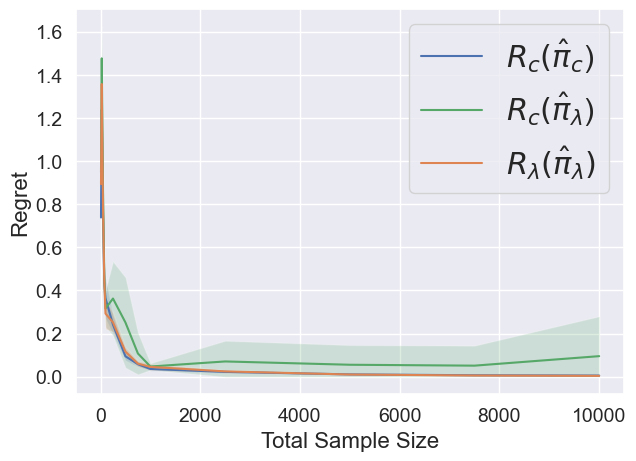

In [37]:
x = ss_range

c=5
plt.rcParams['figure.figsize'] = [c*np.sqrt(2), c*1]

sns.set_theme()
cp = sns.color_palette()
custom_color_order = [cp[0], cp[2], cp[1]]
sns.set_palette(custom_color_order)

plt.plot(x, local_regrets_smooth, label=r'$R_c(\hat{\pi}_c$)')
plt.fill_between(x, local_regrets_smooth - local_regrets_std_smooth, local_regrets_smooth + local_regrets_std_smooth, alpha=0.2)

plt.plot(x, fed_local_regrets_smooth, label=r'$R_c(\hat{\pi}_\lambda$)')
plt.fill_between(x, np.clip(fed_local_regrets_smooth - fed_local_regrets_std_smooth, 0, None), fed_local_regrets_smooth + fed_local_regrets_std_smooth, alpha=0.2)

plt.plot(x, global_regrets_smooth, label=r'$R_\lambda(\hat{\pi}_\lambda)$')
plt.fill_between(x, global_regrets_smooth - global_regrets_std_smooth, global_regrets_smooth + global_regrets_std_smooth, alpha=0.2)

plt.xlabel('Total Sample Size', fontsize=16)
plt.ylabel('Regret', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.title(r'Heterogeneous Clients, Empirical Mixture $\lambda=\bar{n}$', loc="left")
plt.legend(fontsize=22)
# plt.show()

# plt.savefig('./data/heterogeneous-client2-exp1.png', dpi=300)

### Federated model on skewed client distribution

In [60]:
# Aggregate all data
X_train = []
A_train = []
Y_train = []
true_costs_train = []
true_costs_test = []
X_test = []

idx_to_weight_mapping = {}
for client_id in range(NUM_CLIENTS):
    lo = len(X_train)
    X_train.extend(aux[client_id]["X_train"])
    hi = len(X_train)
    A_train.extend(aux[client_id]["A_train"])
    Y_train.extend(aux[client_id]["Y_train"])
    true_costs_train.extend(aux[client_id]["true_costs_train"])
    true_costs_test.extend(aux[client_id]["true_costs_test"])
    X_test.extend(aux[client_id]["X_test"])
    
    if client_id == 0:
        weight = TRAIN_SIZES[client_id] + sum([TRAIN_SIZES[other_id]/2 for other_id in range(1, NUM_CLIENTS)])
    else:
        weight = TRAIN_SIZES[client_id] - TRAIN_SIZES[client_id]/2
    idx_to_weight_mapping.update({i:weight/TRAIN_SIZES[client_id] for i in range(lo, len(X_train))})
    
X_train = np.array(X_train)
A_train = np.array(A_train)
Y_train = np.array(Y_train)
true_costs_train = np.array(true_costs_train)
true_costs_test = np.array(true_costs_test)
X_test = np.array(X_test)

# Compute AIPW scores
crossfit_map, mu, e = utils.cross_fit_nuisance_params(X_train, A_train, Y_train, NUM_ACTIONS)
noisy_costs_train = -utils.compute_AIPW_scores(X_train, A_train, Y_train, NUM_ACTIONS, crossfit_map, mu, e)
data_train = utils.to_vw_format(X_train, A_train, noisy_costs_train, idx_to_weight_mapping)

# Train model
opt_global_model_w = VW(csoaa=NUM_ACTIONS,
                      convert_to_vw=False,
                      convert_labels=False,
                      passes=1)
opt_global_model_w.fit(data_train)

# Evaluate on test data
X_test_vw = utils.to_vw_format(X_test)
regret, opt_reward, reward = utils.compute_regret(X_test_vw, true_costs_test, opt_global_model_w, opt_model=None, idx_to_weight_mapping=idx_to_weight_mapping)
print(f"Aggregate: opt_reward={opt_reward}, reward={reward}, regret={regret}")

Aggregate: opt_reward=4.413742078833837, reward=3.138175648927359, regret=1.2755664299064196


In [66]:
NUM_ROUNDS = 1

def run_federated_training_experiments_v2(data, aux, sample_size_fns, num_iters=3):

    local_regrets_mean = {k:[] for k in range(NUM_CLIENTS)}
    local_regrets_std = {k:[] for k in range(NUM_CLIENTS)}
    global_regrets_mean = []
    global_regrets_std = []

    for sample_size in tqdm(ss_range):
        local_regrets_iters = {k:[] for k in range(NUM_CLIENTS)}
        global_regret_iters = []
        for i in tqdm(range(num_iters)):

            # Subsample data
            data_mod = {}
            aux_mod = {}
            client_weights = []
            for client_id in range(NUM_CLIENTS):
                client_sample_size = sample_size_fns[client_id](sample_size)
                if client_id == 0:
                    weight = client_sample_size + sum([sample_size_fns[other_id](sample_size)/2 for other_id in range(1, NUM_CLIENTS)])
                else:
                    weight = client_sample_size - client_sample_size/2
                client_weights.append(weight)

                data_mod[client_id] = random.sample(data[client_id], client_sample_size)
                aux_mod[client_id] = {"X_test": aux[client_id]["X_test"],
                                      "true_costs_test": aux[client_id]["true_costs_test"]}

            client_weights = np.array(client_weights) / np.sum(client_weights)
            
            # Run federated learning
            global_vw = server.run_federated_learning(data_mod, aux_mod,
                                                      opt_global_model_w, opt_local_models,
                                                      num_features=NUM_FEATURES,
                                                      num_classes=NUM_ACTIONS,
                                                      num_rounds=NUM_ROUNDS,
                                                      num_clients=NUM_CLIENTS,
                                                      client_weights=client_weights)

            gr = global_vw.metrics_distributed["global_regret"][-1][1]
            global_regret_iters.append(gr)
            
            for client_id in range(NUM_CLIENTS):
                lr = global_vw.metrics_distributed["local_regrets"][-1][1][client_id]
                local_regrets_iters[client_id].append(lr)

        global_regrets_mean.append(np.mean(global_regret_iters))
        global_regrets_std.append(np.std(global_regret_iters))
        
        for client_id in range(NUM_CLIENTS):
            local_regrets_mean[client_id].append(np.mean(local_regrets_iters[client_id]))
            local_regrets_std[client_id].append(np.std(local_regrets_iters[client_id]))
            
    global_regrets_mean = np.array(global_regrets_mean)
    global_regrets_std = np.array(global_regrets_std)
    for client_id in range(NUM_CLIENTS):
        local_regrets_mean[client_id] = np.array(local_regrets_mean[client_id])
        local_regrets_std[client_id] = np.array(local_regrets_std[client_id])
        
    return (global_regrets_mean, global_regrets_std,
            local_regrets_mean, local_regrets_std)

In [68]:
client_0_sample_size_fn = lambda n: int(np.log(n))
sample_size_fns = {0: client_0_sample_size_fn,
                   1: lambda n: int((n-client_0_sample_size_fn(n))//(NUM_CLIENTS-1)),
                   2: lambda n: int((n-client_0_sample_size_fn(n))//(NUM_CLIENTS-1)),
                   3: lambda n: int((n-client_0_sample_size_fn(n))//(NUM_CLIENTS-1))}

global_regrets_w, global_regrets_std_w, fed_local_regrets_w, fed_local_regrets_std_w = run_federated_training_experiments_v2(data, aux, sample_size_fns, num_iters=5)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 13:13:18,402 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:13:25,222	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 13:13:28,256 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'memory': 6237159424.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-05-15 13:13:28,257 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 13:13:28,258 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-05-15 13:13:29,728 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:13:29,729 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:13:29,731 | server.py:101 | FL starting


(launch_and_get_parameters pid=28801) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:13:29,732 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=28801) Client 2, training finished for round 1
(launch_and_fit pid=28801) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:13:31,535 | server.py:229 | fit_round 1 received 4 results and 0 failures


(launch_and_fit pid=28796) Client 3, training finished for round 1
(launch_and_fit pid=28796) [Client 3] get_parameters
(launch_and_fit pid=28797) Client 1, training finished for round 1
(launch_and_fit pid=28797) [Client 1] get_parameters
(launch_and_fit pid=28800) Client 0, training finished for round 1
(launch_and_fit pid=28800) [Client 0] get_parameters


WARNING flwr 2023-05-15 13:13:31,564 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:13:31,567 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=28801) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=28796) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=28797) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=28800) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:13:33,616 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:13:33,617 | server.py:144 | FL finished in 3.8849831450006604
INFO flwr 2023-05-15 13:13:33,619 | app.py:202 | app_fit: losses_distributed [(1, 1.2983453218129508)]
INFO flwr 2023-05-15 13:13:33,621 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.469087648140888)], 'reward': [(1, 0.33809674854927263)], 'global_regret': [(1, 1.1309908995916154)], 'local_regrets': [(1, {0: 1.423009053871209, 1: 1.3850132774003856, 2: 1.4264925661286252, 3: 1.416050975497294})]}
INFO flwr 2023-05-15 13:13:33,622 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:13:33,623 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:13:33,632 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:13:40,054	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard a

(launch_and_get_parameters pid=28824) [Client 3] get_parameters


INFO flwr 2023-05-15 13:13:43,939 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:13:43,940 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:13:43,942 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:13:43,943 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=28824) Client 2, training finished for round 1
(launch_and_fit pid=28824) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:13:45,817 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:13:45,846 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:13:45,849 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=28823) Client 0, training finished for round 1
(launch_and_fit pid=28823) [Client 0] get_parameters
(launch_and_fit pid=28821) Client 3, training finished for round 1
(launch_and_fit pid=28821) [Client 3] get_parameters
(launch_and_fit pid=28822) Client 1, training finished for round 1
(launch_and_fit pid=28822) [Client 1] get_parameters
(launch_and_evaluate pid=28824) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=28823) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=28821) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=28822) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 13:13:48,186 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:13:48,188 | server.py:144 | FL finished in 4.2447813260005205
INFO flwr 2023-05-15 13:13:48,192 | app.py:202 | app_fit: losses_distributed [(1, 2.241112156214738)]
INFO flwr 2023-05-15 13:13:48,194 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1872083331376178)], 'reward': [(1, -1.1726843763265717)], 'global_regret': [(1, 2.359892709464193)], 'local_regrets': [(1, {0: 2.477830147592089, 1: 2.4611607289796598, 2: 1.9970907021908388, 3: 2.485551631742077})]}
INFO flwr 2023-05-15 13:13:48,195 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:13:48,197 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:13:48,230 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:13:56,487	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at

(launch_and_get_parameters pid=28846) [Client 1] get_parameters
(launch_and_fit pid=28846) Client 3, training finished for round 1
(launch_and_fit pid=28846) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:14:02,662 | server.py:229 | fit_round 1 received 4 results and 0 failures


(launch_and_fit pid=28848) Client 0, training finished for round 1
(launch_and_fit pid=28848) [Client 0] get_parameters
(launch_and_fit pid=28842) Client 2, training finished for round 1
(launch_and_fit pid=28842) [Client 2] get_parameters
(launch_and_fit pid=28841) Client 1, training finished for round 1
(launch_and_fit pid=28841) [Client 1] get_parameters


WARNING flwr 2023-05-15 13:14:02,687 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:14:02,689 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=28846) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=28848) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=28842) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=28841) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:14:04,586 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:14:04,587 | server.py:144 | FL finished in 3.633709275000001
INFO flwr 2023-05-15 13:14:04,590 | app.py:202 | app_fit: losses_distributed [(1, 1.916665263634636)]
INFO flwr 2023-05-15 13:14:04,591 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1872083331376178)], 'reward': [(1, -0.7806332111627106)], 'global_regret': [(1, 1.9678415443003279)], 'local_regrets': [(1, {0: 2.0181747098444585, 1: 1.948623340429847, 2: 2.0582096395241907, 3: 2.0988379503857697})]}
INFO flwr 2023-05-15 13:14:04,593 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:14:04,595 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:14:04,604 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:14:13,617	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard a

(launch_and_get_parameters pid=28867) [Client 2] get_parameters
(launch_and_fit pid=28867) Client 1, training finished for round 1
(launch_and_fit pid=28867) [Client 1] get_parameters
(launch_and_fit pid=28865) Client 3, training finished for round 1
(launch_and_fit pid=28865) [Client 3] get_parameters
(launch_and_fit pid=28868) Client 0, training finished for round 1
(launch_and_fit pid=28868) [Client 0] get_parameters
(launch_and_fit pid=28869) Client 2, training finished for round 1
(launch_and_fit pid=28869) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:14:18,488 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:14:18,517 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:14:18,520 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=28867) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=28865) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=28868) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=28869) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:14:20,817 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:14:20,818 | server.py:144 | FL finished in 4.117107501999271
INFO flwr 2023-05-15 13:14:20,821 | app.py:202 | app_fit: losses_distributed [(1, 2.121705658951881)]
INFO flwr 2023-05-15 13:14:20,823 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1835309787525072)], 'reward': [(1, -1.0634847440153958)], 'global_regret': [(1, 2.247015722767912)], 'local_regrets': [(1, {0: 2.371924564338712, 1: 1.8993630821654617, 2: 2.323364448835948, 3: 2.349355126113123})]}
INFO flwr 2023-05-15 13:14:20,824 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:14:20,826 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:14:20,834 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:14:28,481	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 1

(launch_and_get_parameters pid=28891) [Client 1] get_parameters
(launch_and_fit pid=28891) Client 0, training finished for round 1
(launch_and_fit pid=28891) [Client 0] get_parameters


DEBUG flwr 2023-05-15 13:14:35,113 | server.py:229 | fit_round 1 received 4 results and 0 failures


(launch_and_fit pid=28887) Client 1, training finished for round 1
(launch_and_fit pid=28887) [Client 1] get_parameters
(launch_and_fit pid=28888) Client 3, training finished for round 1
(launch_and_fit pid=28888) [Client 3] get_parameters
(launch_and_fit pid=28890) Client 2, training finished for round 1
(launch_and_fit pid=28890) [Client 2] get_parameters


WARNING flwr 2023-05-15 13:14:35,141 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:14:35,144 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=28887) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=28891) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=28890) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=28888) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 13:14:37,444 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:14:37,445 | server.py:144 | FL finished in 4.2248557829989295
INFO flwr 2023-05-15 13:14:37,448 | app.py:202 | app_fit: losses_distributed [(1, 1.1777292773995403)]
INFO flwr 2023-05-15 13:14:37,450 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1872083331376175)], 'reward': [(1, -0.015064522925198623)], 'global_regret': [(1, 1.2022728560628193)], 'local_regrets': [(1, {0: 1.2259733196045386, 1: 1.4502451398973313, 2: 1.2517595765502811, 3: 1.2401236591917226})]}
INFO flwr 2023-05-15 13:14:37,452 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:14:37,454 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 13:14:37,601 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:14:44,090	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 13:14:47,478 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 6148121805.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-05-15 13:14:47,480 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 13:14:47,481 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=28914) [Client 1] get_parameters


INFO flwr 2023-05-15 13:14:49,423 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:14:49,425 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:14:49,426 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:14:49,428 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=28914) Client 1, training finished for round 1
(launch_and_fit pid=28914) [Client 1] get_parameters
(launch_and_fit pid=28917) Client 0, training finished for round 1
(launch_and_fit pid=28917) [Client 0] get_parameters
(launch_and_fit pid=28916) Client 2, training finished for round 1
(launch_and_fit pid=28916) [Client 2] get_parameters
(launch_and_fit pid=28915) Client 3, training finished for round 1
(launch_and_fit pid=28915) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:14:51,936 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:14:51,970 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:14:51,973 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=28914) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=28917) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=28916) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=28915) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:14:54,720 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:14:54,721 | server.py:144 | FL finished in 5.293252601000859
INFO flwr 2023-05-15 13:14:54,724 | app.py:202 | app_fit: losses_distributed [(1, 0.7790035683330976)]
INFO flwr 2023-05-15 13:14:54,726 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1985519875431734)], 'reward': [(1, 0.41162366475423995)], 'global_regret': [(1, 0.7869283227889344)], 'local_regrets': [(1, {0: 0.7971798639055477, 1: 0.7785896776698713, 2: 1.2025367272647252, 3: 0.7948925901379591})]}
INFO flwr 2023-05-15 13:14:54,728 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:14:54,731 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:14:54,743 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:15:03,378	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard

(launch_and_get_parameters pid=28937) [Client 2] get_parameters


INFO flwr 2023-05-15 13:15:08,789 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:15:08,791 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:15:08,792 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:15:08,794 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=28937) Client 2, training finished for round 1
(launch_and_fit pid=28937) [Client 2] get_parameters
(launch_and_fit pid=28934) Client 0, training finished for round 1
(launch_and_fit pid=28934) [Client 0] get_parameters
(launch_and_fit pid=28939) Client 1, training finished for round 1
(launch_and_fit pid=28939) [Client 1] get_parameters
(launch_and_fit pid=28941) Client 3, training finished for round 1
(launch_and_fit pid=28941) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:15:11,306 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:15:11,340 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:15:11,343 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=28937) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=28934) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=28939) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=28941) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:15:14,260 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:15:14,261 | server.py:144 | FL finished in 5.467246124999292
INFO flwr 2023-05-15 13:15:14,265 | app.py:202 | app_fit: losses_distributed [(1, 0.8706432655715096)]
INFO flwr 2023-05-15 13:15:14,267 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.4334514167125652)], 'reward': [(1, 0.6045246930082145)], 'global_regret': [(1, 0.8289267237043532)], 'local_regrets': [(1, {0: 1.2298961415912617, 1: 0.8971944186041177, 2: 0.9039510408588539, 3: 0.9087160468775157})]}
INFO flwr 2023-05-15 13:15:14,269 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:15:14,271 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:15:14,282 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:15:21,897	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard 

(launch_and_get_parameters pid=28959) [Client 0] get_parameters


INFO flwr 2023-05-15 13:15:27,621 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:15:27,623 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:15:27,625 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:15:27,627 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=28959) Client 1, training finished for round 1
(launch_and_fit pid=28959) [Client 1] get_parameters
(launch_and_fit pid=28960) Client 0, training finished for round 1
(launch_and_fit pid=28960) [Client 0] get_parameters
(launch_and_fit pid=28963) Client 2, training finished for round 1
(launch_and_fit pid=28963) [Client 2] get_parameters
(launch_and_fit pid=28964) Client 3, training finished for round 1
(launch_and_fit pid=28964) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:15:30,224 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:15:30,261 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:15:30,265 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=28959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=28960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=28963) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=28964) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 13:15:33,437 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:15:33,439 | server.py:144 | FL finished in 5.812767937000899
INFO flwr 2023-05-15 13:15:33,443 | app.py:202 | app_fit: losses_distributed [(1, 0.8286534067998802)]
INFO flwr 2023-05-15 13:15:33,445 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1935901084724843)], 'reward': [(1, 0.32587473439815823)], 'global_regret': [(1, 0.8677153740743269)], 'local_regrets': [(1, {0: 0.9214584747701249, 1: 1.0798332806380164, 2: 0.8726071511113974, 3: 0.8978993063256947})]}
INFO flwr 2023-05-15 13:15:33,446 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:15:33,449 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:15:33,460 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:15:42,532	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard

(launch_and_get_parameters pid=28987) [Client 2] get_parameters


INFO flwr 2023-05-15 13:15:48,178 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:15:48,180 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:15:48,182 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:15:48,184 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=28987) Client 1, training finished for round 1
(launch_and_fit pid=28987) [Client 1] get_parameters
(launch_and_fit pid=28985) Client 3, training finished for round 1
(launch_and_fit pid=28985) [Client 3] get_parameters
(launch_and_fit pid=28982) Client 0, training finished for round 1
(launch_and_fit pid=28982) [Client 0] get_parameters
(launch_and_fit pid=28983) Client 2, training finished for round 1
(launch_and_fit pid=28983) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:15:50,737 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:15:50,771 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:15:50,774 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=28987) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=28985) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=28983) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=28982) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 13:15:54,120 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:15:54,122 | server.py:144 | FL finished in 5.9387891970000055
INFO flwr 2023-05-15 13:15:54,126 | app.py:202 | app_fit: losses_distributed [(1, 0.8588691907633278)]
INFO flwr 2023-05-15 13:15:54,128 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1935901084724843)], 'reward': [(1, 0.29941284034828003)], 'global_regret': [(1, 0.8941772681242052)], 'local_regrets': [(1, {0: 0.9426649229410062, 1: 1.1120184659853343, 2: 0.9256437276805362, 3: 0.9123342320921484})]}
INFO flwr 2023-05-15 13:15:54,130 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:15:54,132 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:15:54,147 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:16:02,611	INFO worker.py:1529 -- Started a local Ray instance. View the dashboar

(launch_and_get_parameters pid=29005) [Client 0] get_parameters


INFO flwr 2023-05-15 13:16:08,621 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:16:08,622 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:16:08,624 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:16:08,626 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29005) Client 0, training finished for round 1
(launch_and_fit pid=29005) [Client 0] get_parameters
(launch_and_fit pid=29007) Client 1, training finished for round 1
(launch_and_fit pid=29007) [Client 1] get_parameters
(launch_and_fit pid=29008) Client 2, training finished for round 1
(launch_and_fit pid=29008) [Client 2] get_parameters
(launch_and_fit pid=29009) Client 3, training finished for round 1
(launch_and_fit pid=29009) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:16:11,422 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:16:11,460 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:16:11,464 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29005) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29007) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29008) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29009) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:16:15,462 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:16:15,463 | server.py:144 | FL finished in 6.837874924998687
INFO flwr 2023-05-15 13:16:15,468 | app.py:202 | app_fit: losses_distributed [(1, 0.8355374995966361)]
INFO flwr 2023-05-15 13:16:15,470 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.1985519875431734)], 'reward': [(1, 0.3545978086617756)], 'global_regret': [(1, 0.8439541788813992)], 'local_regrets': [(1, {0: 0.8548944147585098, 1: 0.8052210236410026, 2: 0.8007416565319032, 3: 1.338477489100843})]}
INFO flwr 2023-05-15 13:16:15,472 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:16:15,474 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 13:16:15,664 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:16:25,101	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 13:16:28,739 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'memory': 6124123341.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-05-15 13:16:28,743 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 13:16:28,746 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=29032) [Client 2] get_parameters


INFO flwr 2023-05-15 13:16:31,066 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:16:31,068 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:16:31,069 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:16:31,071 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29032) Client 0, training finished for round 1
(launch_and_fit pid=29032) [Client 0] get_parameters
(launch_and_fit pid=29029) Client 2, training finished for round 1
(launch_and_fit pid=29029) [Client 2] get_parameters
(launch_and_fit pid=29034) Client 1, training finished for round 1
(launch_and_fit pid=29034) [Client 1] get_parameters
(launch_and_fit pid=29033) Client 3, training finished for round 1
(launch_and_fit pid=29033) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:16:33,904 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:16:33,948 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:16:33,952 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29032) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29029) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29034) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29033) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:16:37,991 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:16:37,993 | server.py:144 | FL finished in 6.921738279999772
INFO flwr 2023-05-15 13:16:37,996 | app.py:202 | app_fit: losses_distributed [(1, 0.35693254113272727)]
INFO flwr 2023-05-15 13:16:37,998 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.201465798957118)], 'reward': [(1, 0.8486976475762603)], 'global_regret': [(1, 0.352768151380857)], 'local_regrets': [(1, {0: 0.34542627954917565, 1: 0.3513750467071437, 2: 0.367543571666626, 3: 0.8205698522536772})]}
INFO flwr 2023-05-15 13:16:38,001 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:16:38,006 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:16:38,029 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:16:48,104	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard a

(launch_and_get_parameters pid=29055) [Client 1] get_parameters


INFO flwr 2023-05-15 13:16:55,407 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:16:55,410 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:16:55,413 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:16:55,416 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29055) Client 0, training finished for round 1
(launch_and_fit pid=29055) [Client 0] get_parameters
(launch_and_fit pid=29056) Client 3, training finished for round 1
(launch_and_fit pid=29056) [Client 3] get_parameters
(launch_and_fit pid=29054) Client 1, training finished for round 1
(launch_and_fit pid=29054) [Client 1] get_parameters
(launch_and_fit pid=29053) Client 2, training finished for round 1
(launch_and_fit pid=29053) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:16:59,560 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:16:59,616 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:16:59,620 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29055) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29056) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29054) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29053) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:17:04,782 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:17:04,784 | server.py:144 | FL finished in 9.368515778000074
INFO flwr 2023-05-15 13:17:04,788 | app.py:202 | app_fit: losses_distributed [(1, 0.3672091279633972)]
INFO flwr 2023-05-15 13:17:04,791 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.415633300998404)], 'reward': [(1, 1.1001345543910457)], 'global_regret': [(1, 0.3154987466073578)], 'local_regrets': [(1, {0: 0.6886873541815568, 1: 0.40795528162103795, 2: 0.41144012537905844, 3: 0.4179383363176498})]}
INFO flwr 2023-05-15 13:17:04,796 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:17:04,800 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:17:04,881 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:17:14,366	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard

(launch_and_get_parameters pid=29081) [Client 1] get_parameters


INFO flwr 2023-05-15 13:17:21,403 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:17:21,405 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:17:21,407 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:17:21,409 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29081) Client 1, training finished for round 1
(launch_and_fit pid=29081) [Client 1] get_parameters
(launch_and_fit pid=29075) Client 0, training finished for round 1
(launch_and_fit pid=29075) [Client 0] get_parameters
(launch_and_fit pid=29080) Client 3, training finished for round 1
(launch_and_fit pid=29080) [Client 3] get_parameters
(launch_and_fit pid=29074) Client 2, training finished for round 1
(launch_and_fit pid=29074) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:17:24,899 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:17:24,944 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:17:24,948 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29081) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29075) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29080) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:17:29,498 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:17:29,500 | server.py:144 | FL finished in 8.091367326000181
INFO flwr 2023-05-15 13:17:29,504 | app.py:202 | app_fit: losses_distributed [(1, 0.5009187865698089)]
INFO flwr 2023-05-15 13:17:29,508 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.204223814745951)], 'reward': [(1, 0.6908898577874409)], 'global_regret': [(1, 0.513333956958512)], 'local_regrets': [(1, {0: 0.5331827924847921, 1: 0.5388370899848074, 2: 0.8306809217795339, 3: 0.5581589276758167})]}
INFO flwr 2023-05-15 13:17:29,511 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:17:29,514 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:17:29,534 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:17:39,531	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at

(launch_and_get_parameters pid=29110) [Client 2] get_parameters


INFO flwr 2023-05-15 13:17:46,893 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:17:46,895 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:17:46,898 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:17:46,900 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29110) Client 2, training finished for round 1
(launch_and_fit pid=29110) [Client 2] get_parameters
(launch_and_fit pid=29107) Client 3, training finished for round 1
(launch_and_fit pid=29107) [Client 3] get_parameters
(launch_and_fit pid=29109) Client 1, training finished for round 1
(launch_and_fit pid=29109) [Client 1] get_parameters
(launch_and_fit pid=29105) Client 0, training finished for round 1
(launch_and_fit pid=29105) [Client 0] get_parameters


DEBUG flwr 2023-05-15 13:17:50,282 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:17:50,323 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:17:50,327 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29110) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29107) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29109) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29105) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 13:17:54,130 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:17:54,132 | server.py:144 | FL finished in 7.232129365000219
INFO flwr 2023-05-15 13:17:54,136 | app.py:202 | app_fit: losses_distributed [(1, 0.8876626988361639)]
INFO flwr 2023-05-15 13:17:54,138 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.201465798957118)], 'reward': [(1, 0.31826302569570747)], 'global_regret': [(1, 0.8832027732614096)], 'local_regrets': [(1, {0: 0.8753683417249216, 1: 1.3751156041119066, 2: 0.8664699061970706, 3: 0.890881528956472})]}
INFO flwr 2023-05-15 13:17:54,141 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:17:54,144 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:17:54,161 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:18:03,602	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard a

(launch_and_get_parameters pid=29140) [Client 2] get_parameters


INFO flwr 2023-05-15 13:18:10,231 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:18:10,232 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:18:10,234 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:18:10,236 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29140) Client 0, training finished for round 1
(launch_and_fit pid=29140) [Client 0] get_parameters
(launch_and_fit pid=29135) Client 1, training finished for round 1
(launch_and_fit pid=29135) [Client 1] get_parameters
(launch_and_fit pid=29134) Client 3, training finished for round 1
(launch_and_fit pid=29134) [Client 3] get_parameters
(launch_and_fit pid=29137) Client 2, training finished for round 1
(launch_and_fit pid=29137) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:18:13,579 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:18:13,627 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:18:13,631 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29140) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29135) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29134) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29137) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:18:17,907 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:18:17,910 | server.py:144 | FL finished in 7.673431977998916
INFO flwr 2023-05-15 13:18:17,913 | app.py:202 | app_fit: losses_distributed [(1, 0.37841049438714114)]
INFO flwr 2023-05-15 13:18:17,916 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.201465798957118)], 'reward': [(1, 0.816756943200795)], 'global_regret': [(1, 0.38470885575632174)], 'local_regrets': [(1, {0: 0.3948049024597252, 1: 0.41707938687334617, 2: 0.4022022591573324, 3: 0.7567400147038736})]}
INFO flwr 2023-05-15 13:18:17,919 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:18:17,923 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 13:18:18,170 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:18:29,413	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 13:18:33,872 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'memory': 6074036224.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0}
INFO flwr 2023-05-15 13:18:33,876 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 13:18:33,879 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=29158) [Client 3] get_parameters


INFO flwr 2023-05-15 13:18:37,550 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:18:37,552 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:18:37,554 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:18:37,557 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29158) Client 0, training finished for round 1
(launch_and_fit pid=29158) [Client 0] get_parameters
(launch_and_fit pid=29162) Client 1, training finished for round 1
(launch_and_fit pid=29162) [Client 1] get_parameters
(launch_and_fit pid=29165) Client 2, training finished for round 1
(launch_and_fit pid=29165) [Client 2] get_parameters
(launch_and_fit pid=29163) Client 3, training finished for round 1
(launch_and_fit pid=29163) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:18:42,397 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:18:42,465 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:18:42,470 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29158) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29163) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29162) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29165) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:18:47,595 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:18:47,598 | server.py:144 | FL finished in 10.040674391999346
INFO flwr 2023-05-15 13:18:47,602 | app.py:202 | app_fit: losses_distributed [(1, 0.5736998918000524)]
INFO flwr 2023-05-15 13:18:47,605 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2005185638013534)], 'reward': [(1, 0.6139916051654165)], 'global_regret': [(1, 0.5865269586359362)], 'local_regrets': [(1, {0: 0.607436826423459, 1: 0.9431250081041928, 2: 0.5919254173131537, 3: 0.6094969010051162})]}
INFO flwr 2023-05-15 13:18:47,608 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:18:47,612 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:18:47,634 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:18:58,037	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard 

(launch_and_get_parameters pid=29184) [Client 2] get_parameters


INFO flwr 2023-05-15 13:19:04,745 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:19:04,746 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:19:04,748 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:19:04,750 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29184) Client 1, training finished for round 1
(launch_and_fit pid=29184) [Client 1] get_parameters
(launch_and_fit pid=29191) Client 0, training finished for round 1
(launch_and_fit pid=29191) [Client 0] get_parameters
(launch_and_fit pid=29188) Client 2, training finished for round 1
(launch_and_fit pid=29188) [Client 2] get_parameters
(launch_and_fit pid=29190) Client 3, training finished for round 1
(launch_and_fit pid=29190) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:19:08,325 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:19:08,374 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:19:08,377 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29184) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29188) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29190) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:19:14,242 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:19:14,246 | server.py:144 | FL finished in 9.49568119200012
INFO flwr 2023-05-15 13:19:14,251 | app.py:202 | app_fit: losses_distributed [(1, 0.3899150842207239)]
INFO flwr 2023-05-15 13:19:14,256 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2005185638013531)], 'reward': [(1, 0.8176422571055718)], 'global_regret': [(1, 0.38287630669578243)], 'local_regrets': [(1, {0: 0.3699406618685654, 1: 0.3641362613812873, 2: 0.38394995266626764, 3: 0.8988180466124868})]}
INFO flwr 2023-05-15 13:19:14,267 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:19:14,270 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:19:14,373 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:19:24,432	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard

(launch_and_get_parameters pid=29214) [Client 0] get_parameters


INFO flwr 2023-05-15 13:19:32,098 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:19:32,101 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:19:32,104 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:19:32,106 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29214) Client 3, training finished for round 1
(launch_and_fit pid=29214) [Client 3] get_parameters
(launch_and_fit pid=29209) Client 2, training finished for round 1
(launch_and_fit pid=29209) [Client 2] get_parameters
(launch_and_fit pid=29208) Client 1, training finished for round 1
(launch_and_fit pid=29208) [Client 1] get_parameters
(launch_and_fit pid=29213) Client 0, training finished for round 1
(launch_and_fit pid=29213) [Client 0] get_parameters


DEBUG flwr 2023-05-15 13:19:36,626 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:19:36,691 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:19:36,696 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29214) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29209) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29208) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29213) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 13:19:42,365 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:19:42,367 | server.py:144 | FL finished in 10.261767448999308
INFO flwr 2023-05-15 13:19:42,372 | app.py:202 | app_fit: losses_distributed [(1, 0.8722485024673059)]
INFO flwr 2023-05-15 13:19:42,376 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2022028463627872)], 'reward': [(1, 0.34949628801861693)], 'global_regret': [(1, 0.8527065583441693)], 'local_regrets': [(1, {0: 0.8190116535187798, 1: 0.828690860954358, 2: 0.8159991368634197, 3: 1.4824769441783805})]}
INFO flwr 2023-05-15 13:19:42,380 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:19:42,384 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:19:42,418 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:19:55,046	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard

(launch_and_get_parameters pid=29244) [Client 1] get_parameters


INFO flwr 2023-05-15 13:20:08,122 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:20:08,136 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:20:08,139 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:20:08,143 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29244) Client 0, training finished for round 1
(launch_and_fit pid=29244) [Client 0] get_parameters
(launch_and_fit pid=29241) Client 1, training finished for round 1
(launch_and_fit pid=29241) [Client 1] get_parameters
(launch_and_fit pid=29245) Client 2, training finished for round 1
(launch_and_fit pid=29245) [Client 2] get_parameters
(launch_and_fit pid=29243) Client 3, training finished for round 1
(launch_and_fit pid=29243) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:20:17,994 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:20:18,144 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:20:18,161 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29244) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29241) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29245) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29243) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:20:45,358 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:20:45,361 | server.py:144 | FL finished in 37.219328443999984
INFO flwr 2023-05-15 13:20:45,377 | app.py:202 | app_fit: losses_distributed [(1, 0.3244245072259092)]
INFO flwr 2023-05-15 13:20:45,392 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.4134365470062469)], 'reward': [(1, 1.1241428590024338)], 'global_regret': [(1, 0.28929368800381344)], 'local_regrets': [(1, {0: 0.6888137576819156, 1: 0.37074493154889326, 2: 0.34638510783503196, 3: 0.3489388174835108})]}
INFO flwr 2023-05-15 13:20:45,408 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:20:45,426 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:20:45,695 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:21:12,112	INFO worker.py:1529 -- Started a local Ray instance. View the dashbo

(launch_and_get_parameters pid=29282) [Client 3] get_parameters


INFO flwr 2023-05-15 13:21:28,144 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:21:28,146 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:21:28,158 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:21:28,161 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29282) Client 0, training finished for round 1
(launch_and_fit pid=29282) [Client 0] get_parameters
(launch_and_fit pid=29281) Client 2, training finished for round 1
(launch_and_fit pid=29281) [Client 2] get_parameters
(launch_and_fit pid=29277) Client 1, training finished for round 1
(launch_and_fit pid=29277) [Client 1] get_parameters
(launch_and_fit pid=29278) Client 3, training finished for round 1
(launch_and_fit pid=29278) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:21:34,909 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:21:35,003 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:21:35,010 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29281) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29282) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29277) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29278) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:21:42,589 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:21:42,599 | server.py:144 | FL finished in 14.43831511099961
INFO flwr 2023-05-15 13:21:42,603 | app.py:202 | app_fit: losses_distributed [(1, 0.5781249894146571)]
INFO flwr 2023-05-15 13:21:42,607 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.4134365470062469)], 'reward': [(1, 0.8069597136598008)], 'global_regret': [(1, 0.6064768333464478)], 'local_regrets': [(1, {0: 1.114152551360799, 1: 0.5457885043351263, 2: 0.5573813477504286, 3: 0.5523621398579883})]}
INFO flwr 2023-05-15 13:21:42,613 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:21:42,616 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 13:21:43,081 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:21:54,607	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 13:21:59,117 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'memory': 6065059840.0, 'CPU': 8.0}
INFO flwr 2023-05-15 13:21:59,120 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 13:21:59,123 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=29306) [Client 3] get_parameters


INFO flwr 2023-05-15 13:22:02,554 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:22:02,557 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:22:02,559 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:22:02,563 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29306) Client 0, training finished for round 1
(launch_and_fit pid=29306) [Client 0] get_parameters
(launch_and_fit pid=29303) Client 3, training finished for round 1
(launch_and_fit pid=29303) [Client 3] get_parameters
(launch_and_fit pid=29304) Client 2, training finished for round 1
(launch_and_fit pid=29304) [Client 2] get_parameters
(launch_and_fit pid=29305) Client 1, training finished for round 1
(launch_and_fit pid=29305) [Client 1] get_parameters


DEBUG flwr 2023-05-15 13:22:06,808 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:22:06,861 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:22:06,866 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29306) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29303) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29304) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29305) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:22:11,679 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:22:11,682 | server.py:144 | FL finished in 9.118608654998752
INFO flwr 2023-05-15 13:22:11,686 | app.py:202 | app_fit: losses_distributed [(1, 0.4990634328367538)]
INFO flwr 2023-05-15 13:22:11,690 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.4092187793413056)], 'reward': [(1, 0.9314230866631511)], 'global_regret': [(1, 0.47779569267815636)], 'local_regrets': [(1, {0: 0.8993589533415794, 1: 0.5134306199975036, 2: 0.5287697793853079, 3: 0.5118789642683373})]}
INFO flwr 2023-05-15 13:22:11,693 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:22:11,697 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:22:11,719 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:22:21,681	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard

(launch_and_get_parameters pid=29330) [Client 3] get_parameters


INFO flwr 2023-05-15 13:22:29,087 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:22:29,089 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:22:29,092 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:22:29,094 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29330) Client 0, training finished for round 1
(launch_and_fit pid=29330) [Client 0] get_parameters
(launch_and_fit pid=29329) Client 3, training finished for round 1
(launch_and_fit pid=29329) [Client 3] get_parameters
(launch_and_fit pid=29328) Client 1, training finished for round 1
(launch_and_fit pid=29328) [Client 1] get_parameters
(launch_and_fit pid=29326) Client 2, training finished for round 1
(launch_and_fit pid=29326) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:22:33,059 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:22:33,112 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:22:33,118 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29330) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29328) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29326) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29329) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 13:22:38,357 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:22:38,359 | server.py:144 | FL finished in 9.265133869999772
INFO flwr 2023-05-15 13:22:38,363 | app.py:202 | app_fit: losses_distributed [(1, 0.25098319116818296)]
INFO flwr 2023-05-15 13:22:38,367 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2062656725389511)], 'reward': [(1, 0.9424345097399109)], 'global_regret': [(1, 0.26383116279904306)], 'local_regrets': [(1, {0: 0.28582888613234697, 1: 0.2867367501271772, 2: 0.2696043314095284, 3: 0.6189473826493932})]}
INFO flwr 2023-05-15 13:22:38,370 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:22:38,374 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:22:38,399 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:22:48,174	INFO worker.py:1529 -- Started a local Ray instance. View the dashboa

(launch_and_get_parameters pid=29357) [Client 0] get_parameters


INFO flwr 2023-05-15 13:22:55,088 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:22:55,090 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:22:55,092 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:22:55,094 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29357) Client 3, training finished for round 1
(launch_and_fit pid=29357) [Client 3] get_parameters
(launch_and_fit pid=29358) Client 1, training finished for round 1
(launch_and_fit pid=29358) [Client 1] get_parameters
(launch_and_fit pid=29355) Client 2, training finished for round 1
(launch_and_fit pid=29355) [Client 2] get_parameters
(launch_and_fit pid=29353) Client 0, training finished for round 1
(launch_and_fit pid=29353) [Client 0] get_parameters


DEBUG flwr 2023-05-15 13:22:58,365 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:22:58,413 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:22:58,417 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29357) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29358) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29355) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29353) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:23:02,398 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:23:02,400 | server.py:144 | FL finished in 7.305938572000741
INFO flwr 2023-05-15 13:23:02,404 | app.py:202 | app_fit: losses_distributed [(1, 0.31555177247945193)]
INFO flwr 2023-05-15 13:23:02,406 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2062656725389511)], 'reward': [(1, 0.885889622267471)], 'global_regret': [(1, 0.3203760502714826)], 'local_regrets': [(1, {0: 0.3281094290024229, 1: 0.3121564570693384, 2: 0.7567270432571046, 3: 0.32239874623465536})]}
INFO flwr 2023-05-15 13:23:02,410 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:23:02,413 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:23:02,433 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:23:11,411	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard

(launch_and_get_parameters pid=29377) [Client 1] get_parameters


INFO flwr 2023-05-15 13:23:17,476 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:23:17,478 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:23:17,479 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:23:17,482 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29377) Client 0, training finished for round 1
(launch_and_fit pid=29377) [Client 0] get_parameters
(launch_and_fit pid=29381) Client 3, training finished for round 1
(launch_and_fit pid=29381) [Client 3] get_parameters
(launch_and_fit pid=29378) Client 2, training finished for round 1
(launch_and_fit pid=29378) [Client 2] get_parameters
(launch_and_fit pid=29380) Client 1, training finished for round 1
(launch_and_fit pid=29380) [Client 1] get_parameters


DEBUG flwr 2023-05-15 13:23:20,222 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:23:20,261 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:23:20,264 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29381) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29378) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29380) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 13:23:23,497 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:23:23,499 | server.py:144 | FL finished in 6.016884609000044
INFO flwr 2023-05-15 13:23:23,502 | app.py:202 | app_fit: losses_distributed [(1, 0.38794419416496795)]
INFO flwr 2023-05-15 13:23:23,504 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.201978609021876)], 'reward': [(1, 0.8131136797356442)], 'global_regret': [(1, 0.38886492928623123)], 'local_regrets': [(1, {0: 0.38955813823560487, 1: 0.39228917307230265, 2: 0.390640071165287, 3: 0.8364739798323902})]}
INFO flwr 2023-05-15 13:23:23,506 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:23:23,509 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:23:23,526 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:23:33,124	INFO worker.py:1529 -- Started a local Ray instance. View the dashboar

(launch_and_get_parameters pid=29399) [Client 1] get_parameters


INFO flwr 2023-05-15 13:23:39,061 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:23:39,062 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:23:39,064 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:23:39,066 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29399) Client 0, training finished for round 1
(launch_and_fit pid=29399) [Client 0] get_parameters
(launch_and_fit pid=29402) Client 1, training finished for round 1
(launch_and_fit pid=29402) [Client 1] get_parameters
(launch_and_fit pid=29400) Client 3, training finished for round 1
(launch_and_fit pid=29400) [Client 3] get_parameters
(launch_and_fit pid=29397) Client 2, training finished for round 1
(launch_and_fit pid=29397) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:23:42,039 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:23:42,083 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:23:42,087 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29402) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29400) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29397) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 13:23:46,153 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:23:46,155 | server.py:144 | FL finished in 7.089100483999573
INFO flwr 2023-05-15 13:23:46,158 | app.py:202 | app_fit: losses_distributed [(1, 0.33066528243497245)]
INFO flwr 2023-05-15 13:23:46,161 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.4092187793413056)], 'reward': [(1, 1.0629440665221337)], 'global_regret': [(1, 0.34627471281917194)], 'local_regrets': [(1, {0: 0.8333973877809012, 1: 0.31979251414182996, 2: 0.30985784602105876, 3: 0.316797967441813})]}
INFO flwr 2023-05-15 13:23:46,163 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:23:46,166 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 13:23:46,425 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:23:58,167	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 13:24:03,637 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'memory': 6062295040.0, 'CPU': 8.0}
INFO flwr 2023-05-15 13:24:03,642 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 13:24:03,646 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=29428) [Client 1] get_parameters


INFO flwr 2023-05-15 13:24:08,007 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:24:08,010 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:24:08,016 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:24:08,020 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29428) Client 0, training finished for round 1
(launch_and_fit pid=29428) [Client 0] get_parameters
(launch_and_fit pid=29427) Client 2, training finished for round 1
(launch_and_fit pid=29427) [Client 2] get_parameters
(launch_and_fit pid=29431) Client 3, training finished for round 1
(launch_and_fit pid=29431) [Client 3] get_parameters
(launch_and_fit pid=29425) Client 1, training finished for round 1
(launch_and_fit pid=29425) [Client 1] get_parameters


DEBUG flwr 2023-05-15 13:24:13,171 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:24:13,236 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:24:13,244 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29428) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29427) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29431) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29425) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 13:24:19,146 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:24:19,149 | server.py:144 | FL finished in 11.129090881999218
INFO flwr 2023-05-15 13:24:19,153 | app.py:202 | app_fit: losses_distributed [(1, 0.12257019473631937)]
INFO flwr 2023-05-15 13:24:19,156 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2039364563986787)], 'reward': [(1, 1.0819330644773617)], 'global_regret': [(1, 0.12200339192131673)], 'local_regrets': [(1, {0: 0.11999204010695405, 1: 0.5894540582628691, 2: 0.12114959476072458, 3: 0.11686967146044466})]}
INFO flwr 2023-05-15 13:24:19,160 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:24:19,166 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:24:19,240 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:24:29,289	INFO worker.py:1529 -- Started a local Ray instance. View the dash

(launch_and_get_parameters pid=29453) [Client 2] get_parameters


INFO flwr 2023-05-15 13:24:37,478 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:24:37,481 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:24:37,483 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:24:37,486 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29453) Client 0, training finished for round 1
(launch_and_fit pid=29453) [Client 0] get_parameters
(launch_and_fit pid=29455) Client 1, training finished for round 1
(launch_and_fit pid=29455) [Client 1] get_parameters
(launch_and_fit pid=29454) Client 3, training finished for round 1
(launch_and_fit pid=29454) [Client 3] get_parameters
(launch_and_fit pid=29450) Client 2, training finished for round 1
(launch_and_fit pid=29450) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:24:41,722 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:24:41,783 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:24:41,789 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29453) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29455) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29454) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29450) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:24:46,121 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:24:46,123 | server.py:144 | FL finished in 8.637711360999674
INFO flwr 2023-05-15 13:24:46,126 | app.py:202 | app_fit: losses_distributed [(1, 0.18775641568739065)]
INFO flwr 2023-05-15 13:24:46,128 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2080660202704134)], 'reward': [(1, 1.0160500574497224)], 'global_regret': [(1, 0.19201596282069194)], 'local_regrets': [(1, {0: 0.1991966457874448, 1: 0.21030179127750762, 2: 0.20630373074243694, 3: 0.5924080805878889})]}
INFO flwr 2023-05-15 13:24:46,131 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:24:46,134 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:24:46,162 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:24:57,354	INFO worker.py:1529 -- Started a local Ray instance. View the dashbo

(launch_and_get_parameters pid=29477) [Client 3] get_parameters


INFO flwr 2023-05-15 13:25:04,493 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:25:04,495 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:25:04,497 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:25:04,499 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29477) Client 1, training finished for round 1
(launch_and_fit pid=29477) [Client 1] get_parameters
(launch_and_fit pid=29473) Client 3, training finished for round 1
(launch_and_fit pid=29473) [Client 3] get_parameters
(launch_and_fit pid=29474) Client 2, training finished for round 1
(launch_and_fit pid=29474) [Client 2] get_parameters
(launch_and_fit pid=29476) Client 0, training finished for round 1
(launch_and_fit pid=29476) [Client 0] get_parameters


DEBUG flwr 2023-05-15 13:25:08,157 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:25:08,207 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:25:08,213 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29477) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29473) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29474) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29476) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 13:25:12,627 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:25:12,630 | server.py:144 | FL finished in 8.130936265000855
INFO flwr 2023-05-15 13:25:12,634 | app.py:202 | app_fit: losses_distributed [(1, 0.2100126877484156)]
INFO flwr 2023-05-15 13:25:12,637 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.4035629645468752)], 'reward': [(1, 1.1962405068420896)], 'global_regret': [(1, 0.20732245770478555)], 'local_regrets': [(1, {0: 0.6616273915653902, 1: 0.21401380836305617, 2: 0.21001941647609423, 3: 0.211574720234836})]}
INFO flwr 2023-05-15 13:25:12,641 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:25:12,644 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:25:12,672 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:25:22,779	INFO worker.py:1529 -- Started a local Ray instance. View the dashboar

(launch_and_get_parameters pid=29503) [Client 2] get_parameters


INFO flwr 2023-05-15 13:25:30,262 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:25:30,264 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:25:30,266 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:25:30,269 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29503) Client 1, training finished for round 1
(launch_and_fit pid=29503) [Client 1] get_parameters
(launch_and_fit pid=29499) Client 3, training finished for round 1
(launch_and_fit pid=29499) [Client 3] get_parameters
(launch_and_fit pid=29501) Client 0, training finished for round 1
(launch_and_fit pid=29501) [Client 0] get_parameters
(launch_and_fit pid=29500) Client 2, training finished for round 1
(launch_and_fit pid=29500) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:25:34,103 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:25:34,164 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:25:34,171 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29500) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29499) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29501) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29503) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:25:38,884 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:25:38,887 | server.py:144 | FL finished in 8.61842763399909
INFO flwr 2023-05-15 13:25:38,890 | app.py:202 | app_fit: losses_distributed [(1, 0.2370375996076272)]
INFO flwr 2023-05-15 13:25:38,895 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.4035629645468752)], 'reward': [(1, 1.1895166254555118)], 'global_regret': [(1, 0.2140463390913639)], 'local_regrets': [(1, {0: 0.6301097969453794, 1: 0.25969996495488473, 2: 0.26044218049765994, 3: 0.2550830416782982})]}
INFO flwr 2023-05-15 13:25:38,898 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:25:38,903 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:25:38,937 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:25:49,055	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard

(launch_and_get_parameters pid=29527) [Client 1] get_parameters


INFO flwr 2023-05-15 13:25:56,327 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:25:56,329 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:25:56,331 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:25:56,334 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29527) Client 0, training finished for round 1
(launch_and_fit pid=29527) [Client 0] get_parameters
(launch_and_fit pid=29521) Client 1, training finished for round 1
(launch_and_fit pid=29521) [Client 1] get_parameters
(launch_and_fit pid=29526) Client 2, training finished for round 1
(launch_and_fit pid=29526) [Client 2] get_parameters
(launch_and_fit pid=29520) Client 3, training finished for round 1
(launch_and_fit pid=29520) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:25:59,900 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:25:59,945 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:25:59,950 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29527) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29521) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29526) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29520) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 13:26:04,333 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:26:04,335 | server.py:144 | FL finished in 8.001244373999725
INFO flwr 2023-05-15 13:26:04,337 | app.py:202 | app_fit: losses_distributed [(1, 0.20900063259007165)]
INFO flwr 2023-05-15 13:26:04,340 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2080660202704134)], 'reward': [(1, 1.0062308034289378)], 'global_regret': [(1, 0.20183521684147748)], 'local_regrets': [(1, {0: 0.18749445810047377, 1: 0.1852857388146436, 2: 0.7356189410342274, 3: 0.18478797805665487})]}
INFO flwr 2023-05-15 13:26:04,343 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:26:04,348 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 13:26:04,645 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:26:14,850	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 13:26:19,211 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'memory': 6102672180.0, 'CPU': 8.0}
INFO flwr 2023-05-15 13:26:19,213 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 13:26:19,215 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=29548) [Client 0] get_parameters


INFO flwr 2023-05-15 13:26:22,374 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:26:22,376 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:26:22,378 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:26:22,380 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29548) Client 3, training finished for round 1
(launch_and_fit pid=29548) [Client 3] get_parameters
(launch_and_fit pid=29550) Client 2, training finished for round 1
(launch_and_fit pid=29550) [Client 2] get_parameters
(launch_and_fit pid=29552) Client 1, training finished for round 1
(launch_and_fit pid=29552) [Client 1] get_parameters
(launch_and_fit pid=29551) Client 0, training finished for round 1
(launch_and_fit pid=29551) [Client 0] get_parameters


DEBUG flwr 2023-05-15 13:26:25,995 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:26:26,046 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:26:26,050 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29548) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29551) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29550) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29552) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 13:26:30,229 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:26:30,231 | server.py:144 | FL finished in 7.851625371000409
INFO flwr 2023-05-15 13:26:30,234 | app.py:202 | app_fit: losses_distributed [(1, 0.03674152437389598)]
INFO flwr 2023-05-15 13:26:30,236 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.4012500027713095)], 'reward': [(1, 1.3761644341903398)], 'global_regret': [(1, 0.025085568580970205)], 'local_regrets': [(1, {0: 0.4619690068461401, 1: 0.046821651195736516, 2: 0.04689554735729567, 3: 0.048464477742127})]}
INFO flwr 2023-05-15 13:26:30,239 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:26:30,243 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:26:30,277 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:26:40,503	INFO worker.py:1529 -- Started a local Ray instance. View the dashb

(launch_and_get_parameters pid=29569) [Client 2] get_parameters


INFO flwr 2023-05-15 13:26:47,541 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:26:47,543 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:26:47,545 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:26:47,547 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29569) Client 2, training finished for round 1
(launch_and_fit pid=29569) [Client 2] get_parameters
(launch_and_fit pid=29575) Client 3, training finished for round 1
(launch_and_fit pid=29575) [Client 3] get_parameters
(launch_and_fit pid=29573) Client 1, training finished for round 1
(launch_and_fit pid=29573) [Client 1] get_parameters
(launch_and_fit pid=29568) Client 0, training finished for round 1
(launch_and_fit pid=29568) [Client 0] get_parameters


DEBUG flwr 2023-05-15 13:26:51,154 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:26:51,200 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:26:51,204 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29569) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29575) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29573) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29568) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:26:55,614 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:26:55,617 | server.py:144 | FL finished in 8.069526047000181
INFO flwr 2023-05-15 13:26:55,622 | app.py:202 | app_fit: losses_distributed [(1, 0.09377123105504087)]
INFO flwr 2023-05-15 13:26:55,625 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.4012500027713095)], 'reward': [(1, 1.3141088797401415)], 'global_regret': [(1, 0.08714112303117005)], 'local_regrets': [(1, {0: 0.5337214911095737, 1: 0.10189712924551783, 2: 0.09807859281704193, 3: 0.09857229669374373})]}
INFO flwr 2023-05-15 13:26:55,628 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:26:55,632 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:26:55,667 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:27:06,028	INFO worker.py:1529 -- Started a local Ray instance. View the dashb

(launch_and_get_parameters pid=29597) [Client 0] get_parameters


INFO flwr 2023-05-15 13:27:13,415 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:27:13,417 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:27:13,419 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:27:13,421 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29597) Client 2, training finished for round 1
(launch_and_fit pid=29597) [Client 2] get_parameters
(launch_and_fit pid=29592) Client 1, training finished for round 1
(launch_and_fit pid=29592) [Client 1] get_parameters
(launch_and_fit pid=29596) Client 0, training finished for round 1
(launch_and_fit pid=29596) [Client 0] get_parameters
(launch_and_fit pid=29599) Client 3, training finished for round 1
(launch_and_fit pid=29599) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:27:16,954 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:27:17,011 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:27:17,016 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29597) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29592) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29596) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29599) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:27:22,220 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:27:22,222 | server.py:144 | FL finished in 8.80183740800021
INFO flwr 2023-05-15 13:27:22,224 | app.py:202 | app_fit: losses_distributed [(1, 0.05288779150208683)]
INFO flwr 2023-05-15 13:27:22,228 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.208802277668675)], 'reward': [(1, 1.153973670260451)], 'global_regret': [(1, 0.054828607408224296)], 'local_regrets': [(1, {0: 0.05773012532909546, 1: 0.055472418348493396, 2: 0.05900946216731055, 3: 0.4965237458091626})]}
INFO flwr 2023-05-15 13:27:22,231 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:27:22,234 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:27:22,270 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:27:32,547	INFO worker.py:1529 -- Started a local Ray instance. View the dashbo

(launch_and_get_parameters pid=29616) [Client 2] get_parameters


INFO flwr 2023-05-15 13:27:40,027 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:27:40,028 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:27:40,031 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:27:40,033 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29616) Client 3, training finished for round 1
(launch_and_fit pid=29616) [Client 3] get_parameters
(launch_and_fit pid=29619) Client 0, training finished for round 1
(launch_and_fit pid=29619) [Client 0] get_parameters
(launch_and_fit pid=29622) Client 1, training finished for round 1
(launch_and_fit pid=29622) [Client 1] get_parameters
(launch_and_fit pid=29623) Client 2, training finished for round 1
(launch_and_fit pid=29623) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:27:44,100 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:27:44,157 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:27:44,162 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29616) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29619) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29622) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29623) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:27:48,995 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:27:48,997 | server.py:144 | FL finished in 8.964016601001276
INFO flwr 2023-05-15 13:27:48,999 | app.py:202 | app_fit: losses_distributed [(1, 0.07287205003959601)]
INFO flwr 2023-05-15 13:27:49,003 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.4012500027713095)], 'reward': [(1, 1.3232642460073418)], 'global_regret': [(1, 0.07798575676396707)], 'local_regrets': [(1, {0: 0.5472247791801564, 1: 0.06571421359562533, 2: 0.06782583876324366, 3: 0.0679079542650737})]}
INFO flwr 2023-05-15 13:27:49,005 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:27:49,009 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:27:49,093 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:27:59,617	INFO worker.py:1529 -- Started a local Ray instance. View the dashbo

(launch_and_get_parameters pid=29644) [Client 3] get_parameters


INFO flwr 2023-05-15 13:28:07,306 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:28:07,308 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:28:07,310 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:28:07,313 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29644) Client 1, training finished for round 1
(launch_and_fit pid=29644) [Client 1] get_parameters
(launch_and_fit pid=29649) Client 0, training finished for round 1
(launch_and_fit pid=29649) [Client 0] get_parameters
(launch_and_fit pid=29643) Client 2, training finished for round 1
(launch_and_fit pid=29643) [Client 2] get_parameters
(launch_and_fit pid=29646) Client 3, training finished for round 1
(launch_and_fit pid=29646) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:28:10,908 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:28:10,961 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:28:10,966 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29644) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29646) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29649) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29643) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:28:15,588 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:28:15,591 | server.py:144 | FL finished in 8.278326120000202
INFO flwr 2023-05-15 13:28:15,594 | app.py:202 | app_fit: losses_distributed [(1, 0.07587769926117457)]
INFO flwr 2023-05-15 13:28:15,597 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2047371237312432)], 'reward': [(1, 1.1315805245539443)], 'global_regret': [(1, 0.07315659917729811)], 'local_regrets': [(1, {0: 0.06696282317409727, 1: 0.07170873467992551, 2: 0.07172713374055967, 3: 0.5502966910958309})]}
INFO flwr 2023-05-15 13:28:15,599 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:28:15,602 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 13:28:15,906 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:28:25,763	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 13:28:29,841 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 6079949210.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-05-15 13:28:29,848 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 13:28:29,852 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=29667) [Client 0] get_parameters


INFO flwr 2023-05-15 13:28:33,022 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:28:33,025 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:28:33,027 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:28:33,030 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29667) Client 0, training finished for round 1
(launch_and_fit pid=29667) [Client 0] get_parameters
(launch_and_fit pid=29668) Client 3, training finished for round 1
(launch_and_fit pid=29668) [Client 3] get_parameters
(launch_and_fit pid=29674) Client 1, training finished for round 1
(launch_and_fit pid=29674) [Client 1] get_parameters
(launch_and_fit pid=29672) Client 2, training finished for round 1
(launch_and_fit pid=29672) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:28:36,598 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:28:36,649 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:28:36,654 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29667) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29668) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29674) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29672) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:28:41,156 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:28:41,158 | server.py:144 | FL finished in 8.128526315000272
INFO flwr 2023-05-15 13:28:41,161 | app.py:202 | app_fit: losses_distributed [(1, 0.026319834267434283)]
INFO flwr 2023-05-15 13:28:41,163 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2066788533632584)], 'reward': [(1, 1.1787306419054806)], 'global_regret': [(1, 0.027948211457779173)], 'local_regrets': [(1, {0: 0.03072681238739487, 1: 0.47103336838519344, 2: 0.03001398473979287, 3: 0.030689757203070274})]}
INFO flwr 2023-05-15 13:28:41,166 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:28:41,170 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:28:41,208 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:28:50,353	INFO worker.py:1529 -- Started a local Ray instance. View the d

(launch_and_get_parameters pid=29697) [Client 1] get_parameters


INFO flwr 2023-05-15 13:28:57,881 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:28:57,883 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:28:57,885 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:28:57,888 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29697) Client 3, training finished for round 1
(launch_and_fit pid=29697) [Client 3] get_parameters
(launch_and_fit pid=29694) Client 1, training finished for round 1
(launch_and_fit pid=29694) [Client 1] get_parameters
(launch_and_fit pid=29691) Client 2, training finished for round 1
(launch_and_fit pid=29691) [Client 2] get_parameters
(launch_and_fit pid=29692) Client 0, training finished for round 1
(launch_and_fit pid=29692) [Client 0] get_parameters


DEBUG flwr 2023-05-15 13:29:01,496 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:29:01,545 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:29:01,550 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29697) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29694) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29691) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29692) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:29:06,349 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:29:06,352 | server.py:144 | FL finished in 8.464289120000103
INFO flwr 2023-05-15 13:29:06,357 | app.py:202 | app_fit: losses_distributed [(1, 0.05538386334620759)]
INFO flwr 2023-05-15 13:29:06,359 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2051366327581172)], 'reward': [(1, 1.1518434207578427)], 'global_regret': [(1, 0.053293212000275036)], 'local_regrets': [(1, {0: 0.04826702674971154, 1: 0.5323758745261901, 2: 0.04917711597570151, 3: 0.04890002177894167})]}
INFO flwr 2023-05-15 13:29:06,362 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:29:06,365 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:29:06,435 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:29:17,238	INFO worker.py:1529 -- Started a local Ray instance. View the dash

(launch_and_get_parameters pid=29726) [Client 3] get_parameters


INFO flwr 2023-05-15 13:29:23,722 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:29:23,723 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:29:23,726 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:29:23,729 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29726) Client 0, training finished for round 1
(launch_and_fit pid=29726) [Client 0] get_parameters
(launch_and_fit pid=29727) Client 3, training finished for round 1
(launch_and_fit pid=29727) [Client 3] get_parameters
(launch_and_fit pid=29729) Client 1, training finished for round 1
(launch_and_fit pid=29729) [Client 1] get_parameters
(launch_and_fit pid=29724) Client 2, training finished for round 1
(launch_and_fit pid=29724) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:29:27,359 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:29:27,408 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:29:27,413 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29726) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29727) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29729) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29724) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:29:31,405 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:29:31,407 | server.py:144 | FL finished in 7.67823103199953
INFO flwr 2023-05-15 13:29:31,410 | app.py:202 | app_fit: losses_distributed [(1, 0.07631375422461585)]
INFO flwr 2023-05-15 13:29:31,413 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2066788533632584)], 'reward': [(1, 1.1255665497135294)], 'global_regret': [(1, 0.08111230364972973)], 'local_regrets': [(1, {0: 0.09008147713228015, 1: 0.4852137402508749, 2: 0.09088105745084601, 3: 0.09626332771017652})]}
INFO flwr 2023-05-15 13:29:31,415 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:29:31,420 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:29:31,530 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:29:40,719	INFO worker.py:1529 -- Started a local Ray instance. View the dashbo

(launch_and_get_parameters pid=29755) [Client 0] get_parameters


INFO flwr 2023-05-15 13:29:48,163 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:29:48,165 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:29:48,167 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:29:48,169 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29755) Client 1, training finished for round 1
(launch_and_fit pid=29755) [Client 1] get_parameters
(launch_and_fit pid=29749) Client 0, training finished for round 1
(launch_and_fit pid=29749) [Client 0] get_parameters
(launch_and_fit pid=29750) Client 2, training finished for round 1
(launch_and_fit pid=29750) [Client 2] get_parameters
(launch_and_fit pid=29754) Client 3, training finished for round 1
(launch_and_fit pid=29754) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:29:51,710 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:29:51,758 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:29:51,763 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29755) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29749) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29750) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29754) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:29:55,819 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:29:55,821 | server.py:144 | FL finished in 7.65201306400013
INFO flwr 2023-05-15 13:29:55,824 | app.py:202 | app_fit: losses_distributed [(1, 0.020078154020690808)]
INFO flwr 2023-05-15 13:29:55,827 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2091696480667733)], 'reward': [(1, 1.1885391417299185)], 'global_regret': [(1, 0.020630506336854437)], 'local_regrets': [(1, {0: 0.02086600046260732, 1: 0.47305437291636865, 2: 0.020395863282491492, 3: 0.023180965067010163})]}
INFO flwr 2023-05-15 13:29:55,830 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:29:55,833 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:29:55,867 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:30:05,848	INFO worker.py:1529 -- Started a local Ray instance. View the d

(launch_and_get_parameters pid=29779) [Client 1] get_parameters


INFO flwr 2023-05-15 13:30:12,979 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:30:12,981 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:30:12,982 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:30:12,985 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29779) Client 2, training finished for round 1
(launch_and_fit pid=29779) [Client 2] get_parameters
(launch_and_fit pid=29776) Client 1, training finished for round 1
(launch_and_fit pid=29776) [Client 1] get_parameters
(launch_and_fit pid=29774) Client 3, training finished for round 1
(launch_and_fit pid=29774) [Client 3] get_parameters
(launch_and_fit pid=29773) Client 0, training finished for round 1
(launch_and_fit pid=29773) [Client 0] get_parameters


DEBUG flwr 2023-05-15 13:30:16,198 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:30:16,245 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:30:16,251 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29779) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29776) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29774) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29773) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:30:20,630 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:30:20,633 | server.py:144 | FL finished in 7.648690903999523
INFO flwr 2023-05-15 13:30:20,636 | app.py:202 | app_fit: losses_distributed [(1, 0.07090227085551355)]
INFO flwr 2023-05-15 13:30:20,638 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2051366327581174)], 'reward': [(1, 1.1363064345079015)], 'global_regret': [(1, 0.06883019825021561)], 'local_regrets': [(1, {0: 0.06384029274514329, 1: 0.05929236292534942, 2: 0.05998454754103595, 3: 0.5576764658562399})]}
INFO flwr 2023-05-15 13:30:20,641 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:30:20,644 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 13:30:20,931 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:30:29,726	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 13:30:33,602 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'CPU': 8.0, 'memory': 6061259162.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-05-15 13:30:33,607 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 13:30:33,609 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=29802) [Client 1] get_parameters


INFO flwr 2023-05-15 13:30:36,467 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:30:36,468 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:30:36,470 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:30:36,473 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29802) Client 0, training finished for round 1
(launch_and_fit pid=29802) [Client 0] get_parameters
(launch_and_fit pid=29797) Client 1, training finished for round 1
(launch_and_fit pid=29797) [Client 1] get_parameters
(launch_and_fit pid=29801) Client 3, training finished for round 1
(launch_and_fit pid=29801) [Client 3] get_parameters
(launch_and_fit pid=29804) Client 2, training finished for round 1
(launch_and_fit pid=29804) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:30:39,935 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:30:39,979 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:30:39,985 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29802) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29797) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29801) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29804) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:30:43,933 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:30:43,936 | server.py:144 | FL finished in 7.463195438000184
INFO flwr 2023-05-15 13:30:43,939 | app.py:202 | app_fit: losses_distributed [(1, 0.04400621066876914)]
INFO flwr 2023-05-15 13:30:43,941 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2053334165194598)], 'reward': [(1, 1.1615366576787167)], 'global_regret': [(1, 0.04379675884074351)], 'local_regrets': [(1, {0: 0.042441659921595085, 1: 0.5026604277888107, 2: 0.0445325716991604, 3: 0.04357476891122432})]}
INFO flwr 2023-05-15 13:30:43,944 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:30:43,948 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:30:43,984 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:30:52,816	INFO worker.py:1529 -- Started a local Ray instance. View the dashb

(launch_and_get_parameters pid=29827) [Client 2] get_parameters


INFO flwr 2023-05-15 13:31:00,375 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:31:00,377 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:31:00,380 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:31:00,382 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29827) Client 3, training finished for round 1
(launch_and_fit pid=29827) [Client 3] get_parameters
(launch_and_fit pid=29825) Client 0, training finished for round 1
(launch_and_fit pid=29825) [Client 0] get_parameters
(launch_and_fit pid=29826) Client 2, training finished for round 1
(launch_and_fit pid=29826) [Client 2] get_parameters
(launch_and_fit pid=29821) Client 1, training finished for round 1
(launch_and_fit pid=29821) [Client 1] get_parameters


DEBUG flwr 2023-05-15 13:31:03,983 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:31:04,032 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:31:04,038 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29827) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29825) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29826) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29821) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:31:08,233 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:31:08,236 | server.py:144 | FL finished in 7.853437244999441
INFO flwr 2023-05-15 13:31:08,238 | app.py:202 | app_fit: losses_distributed [(1, 0.03803200803706408)]
INFO flwr 2023-05-15 13:31:08,240 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2053334165194598)], 'reward': [(1, 1.1671653666173913)], 'global_regret': [(1, 0.03816804990206851)], 'local_regrets': [(1, {0: 0.03749163592293759, 1: 0.04087998512339161, 2: 0.03975460909976877, 3: 0.4911863876478732})]}
INFO flwr 2023-05-15 13:31:08,243 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:31:08,247 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:31:08,285 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:31:18,651	INFO worker.py:1529 -- Started a local Ray instance. View the dashb

(launch_and_get_parameters pid=29844) [Client 3] get_parameters


INFO flwr 2023-05-15 13:31:25,949 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:31:25,951 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:31:25,953 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:31:25,955 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29844) Client 3, training finished for round 1
(launch_and_fit pid=29844) [Client 3] get_parameters
(launch_and_fit pid=29850) Client 1, training finished for round 1
(launch_and_fit pid=29850) [Client 1] get_parameters
(launch_and_fit pid=29848) Client 2, training finished for round 1
(launch_and_fit pid=29848) [Client 2] get_parameters
(launch_and_fit pid=29845) Client 0, training finished for round 1
(launch_and_fit pid=29845) [Client 0] get_parameters


DEBUG flwr 2023-05-15 13:31:29,520 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:31:29,572 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:31:29,577 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29844) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29850) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29848) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29845) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 13:31:34,811 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:31:34,814 | server.py:144 | FL finished in 8.859366151998984
INFO flwr 2023-05-15 13:31:34,819 | app.py:202 | app_fit: losses_distributed [(1, 0.03557135549429801)]
INFO flwr 2023-05-15 13:31:34,822 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2068695836233723)], 'reward': [(1, 1.171374403839963)], 'global_regret': [(1, 0.0354951797834099)], 'local_regrets': [(1, {0: 0.03494431860462421, 1: 0.03665178488431862, 2: 0.4926203801781701, 3: 0.03525352395579428})]}
INFO flwr 2023-05-15 13:31:34,826 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:31:34,829 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:31:34,873 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:31:45,602	INFO worker.py:1529 -- Started a local Ray instance. View the dashboa

(launch_and_get_parameters pid=29872) [Client 0] get_parameters


INFO flwr 2023-05-15 13:31:53,472 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:31:53,475 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:31:53,477 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:31:53,480 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29872) Client 3, training finished for round 1
(launch_and_fit pid=29872) [Client 3] get_parameters
(launch_and_fit pid=29875) Client 2, training finished for round 1
(launch_and_fit pid=29875) [Client 2] get_parameters
(launch_and_fit pid=29876) Client 1, training finished for round 1
(launch_and_fit pid=29876) [Client 1] get_parameters
(launch_and_fit pid=29870) Client 0, training finished for round 1
(launch_and_fit pid=29870) [Client 0] get_parameters


DEBUG flwr 2023-05-15 13:31:57,626 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:31:57,681 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:31:57,687 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29872) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29875) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29876) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29870) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:32:02,850 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:32:02,852 | server.py:144 | FL finished in 9.37203587499971
INFO flwr 2023-05-15 13:32:02,855 | app.py:202 | app_fit: losses_distributed [(1, 0.04404167171752909)]
INFO flwr 2023-05-15 13:32:02,857 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2053334165194598)], 'reward': [(1, 1.1589833302640045)], 'global_regret': [(1, 0.04635008625545467)], 'local_regrets': [(1, {0: 0.04994106310562288, 1: 0.48521798363002105, 2: 0.04888925846417811, 3: 0.0493029673160091})]}
INFO flwr 2023-05-15 13:32:02,859 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:32:02,867 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:32:02,912 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:32:13,371	INFO worker.py:1529 -- Started a local Ray instance. View the dashbo

(launch_and_get_parameters pid=29895) [Client 0] get_parameters


INFO flwr 2023-05-15 13:32:21,629 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:32:21,631 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:32:21,634 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:32:21,637 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29895) Client 2, training finished for round 1
(launch_and_fit pid=29895) [Client 2] get_parameters
(launch_and_fit pid=29900) Client 0, training finished for round 1
(launch_and_fit pid=29900) [Client 0] get_parameters
(launch_and_fit pid=29894) Client 1, training finished for round 1
(launch_and_fit pid=29894) [Client 1] get_parameters
(launch_and_fit pid=29897) Client 3, training finished for round 1
(launch_and_fit pid=29897) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:32:25,938 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:32:25,990 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:32:25,995 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29900) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29894) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29895) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29897) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 13:32:30,489 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:32:30,491 | server.py:144 | FL finished in 8.855248987998493
INFO flwr 2023-05-15 13:32:30,496 | app.py:202 | app_fit: losses_distributed [(1, 0.034302378415770544)]
INFO flwr 2023-05-15 13:32:30,499 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2053334165194598)], 'reward': [(1, 1.1692655565355192)], 'global_regret': [(1, 0.03606785998394042)], 'local_regrets': [(1, {0: 0.0385923038193363, 1: 0.47524947146056545, 2: 0.04110353276859128, 3: 0.03944879126030361})]}
INFO flwr 2023-05-15 13:32:30,502 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:32:30,505 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 13:32:30,847 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:32:41,782	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 13:32:45,923 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 6045282304.0, 'CPU': 8.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0}
INFO flwr 2023-05-15 13:32:45,926 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 13:32:45,929 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=29922) [Client 2] get_parameters


INFO flwr 2023-05-15 13:32:49,195 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:32:49,196 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:32:49,199 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:32:49,201 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29922) Client 2, training finished for round 1
(launch_and_fit pid=29922) [Client 2] get_parameters
(launch_and_fit pid=29923) Client 0, training finished for round 1
(launch_and_fit pid=29923) [Client 0] get_parameters
(launch_and_fit pid=29919) Client 1, training finished for round 1
(launch_and_fit pid=29919) [Client 1] get_parameters
(launch_and_fit pid=29924) Client 3, training finished for round 1
(launch_and_fit pid=29924) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:32:52,818 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:32:52,871 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:32:52,876 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29922) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29923) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29919) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29924) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:32:57,443 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:32:57,445 | server.py:144 | FL finished in 8.244426641000246
INFO flwr 2023-05-15 13:32:57,448 | app.py:202 | app_fit: losses_distributed [(1, 0.013832441948577657)]
INFO flwr 2023-05-15 13:32:57,451 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2096415440900443)], 'reward': [(1, 1.1960777881632236)], 'global_regret': [(1, 0.013563755926819729)], 'local_regrets': [(1, {0: 0.0121877575496981, 1: 0.475298986193703, 2: 0.011780246926573085, 3: 0.013247362770051584})]}
INFO flwr 2023-05-15 13:32:57,453 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:32:57,456 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:32:57,490 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:33:06,893	INFO worker.py:1529 -- Started a local Ray instance. View the das

(launch_and_get_parameters pid=29941) [Client 3] get_parameters


INFO flwr 2023-05-15 13:33:13,467 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:33:13,469 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:33:13,470 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:33:13,473 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29941) Client 1, training finished for round 1
(launch_and_fit pid=29941) [Client 1] get_parameters
(launch_and_fit pid=29946) Client 0, training finished for round 1
(launch_and_fit pid=29946) [Client 0] get_parameters
(launch_and_fit pid=29948) Client 2, training finished for round 1
(launch_and_fit pid=29948) [Client 2] get_parameters
(launch_and_fit pid=29945) Client 3, training finished for round 1
(launch_and_fit pid=29945) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:33:16,702 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:33:16,749 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:33:16,753 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29945) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29946) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29941) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29948) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 13:33:20,656 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:33:20,659 | server.py:144 | FL finished in 7.186583643999256
INFO flwr 2023-05-15 13:33:20,664 | app.py:202 | app_fit: losses_distributed [(1, 0.010856091990931216)]
INFO flwr 2023-05-15 13:33:20,667 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2096415440900443)], 'reward': [(1, 1.1987708054512238)], 'global_regret': [(1, 0.010870738638820335)], 'local_regrets': [(1, {0: 0.01005667211963832, 1: 0.011017655724694998, 2: 0.01011173345329111, 3: 0.46942289231181594})]}
INFO flwr 2023-05-15 13:33:20,670 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:33:20,675 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:33:20,716 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:33:29,912	INFO worker.py:1529 -- Started a local Ray instance. View the d

(launch_and_get_parameters pid=29968) [Client 1] get_parameters


INFO flwr 2023-05-15 13:33:36,713 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:33:36,715 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:33:36,717 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:33:36,719 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29968) Client 2, training finished for round 1
(launch_and_fit pid=29968) [Client 2] get_parameters
(launch_and_fit pid=29967) Client 3, training finished for round 1
(launch_and_fit pid=29967) [Client 3] get_parameters
(launch_and_fit pid=29969) Client 0, training finished for round 1
(launch_and_fit pid=29969) [Client 0] get_parameters
(launch_and_fit pid=29970) Client 1, training finished for round 1
(launch_and_fit pid=29970) [Client 1] get_parameters


DEBUG flwr 2023-05-15 13:33:40,503 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:33:40,553 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:33:40,558 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29968) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29967) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=29969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29970) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:33:46,068 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:33:46,070 | server.py:144 | FL finished in 9.351296849999926
INFO flwr 2023-05-15 13:33:46,075 | app.py:202 | app_fit: losses_distributed [(1, 0.007084748263045903)]
INFO flwr 2023-05-15 13:33:46,078 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2071762457102662)], 'reward': [(1, 1.2006181693022893)], 'global_regret': [(1, 0.006558076407977415)], 'local_regrets': [(1, {0: 0.005112309266417266, 1: 0.47056981594463887, 2: 0.0051468786221063895, 3: 0.004694574864735677})]}
INFO flwr 2023-05-15 13:33:46,081 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:33:46,085 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:33:46,124 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:33:57,802	INFO worker.py:1529 -- Started a local Ray instance. View th

(launch_and_get_parameters pid=29993) [Client 1] get_parameters


INFO flwr 2023-05-15 13:34:05,514 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:34:05,516 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:34:05,518 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:34:05,520 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=29993) Client 3, training finished for round 1
(launch_and_fit pid=29993) [Client 3] get_parameters
(launch_and_fit pid=29996) Client 1, training finished for round 1
(launch_and_fit pid=29996) [Client 1] get_parameters
(launch_and_fit pid=29995) Client 0, training finished for round 1
(launch_and_fit pid=29995) [Client 0] get_parameters
(launch_and_fit pid=29997) Client 2, training finished for round 1
(launch_and_fit pid=29997) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:34:09,325 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:34:09,376 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:34:09,380 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=29993) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=29996) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=29997) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=29995) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 13:34:13,881 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:34:13,883 | server.py:144 | FL finished in 8.363381258999652
INFO flwr 2023-05-15 13:34:13,887 | app.py:202 | app_fit: losses_distributed [(1, 0.015604162987010244)]
INFO flwr 2023-05-15 13:34:13,890 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2096415440900443)], 'reward': [(1, 1.1943917424248536)], 'global_regret': [(1, 0.015249801665189525)], 'local_regrets': [(1, {0: 0.01370388401753765, 1: 0.015052666470822125, 2: 0.015161488830514741, 3: 0.47568319827488165})]}
INFO flwr 2023-05-15 13:34:13,893 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:34:13,897 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:34:13,936 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:34:24,060	INFO worker.py:1529 -- Started a local Ray instance. View the 

(launch_and_get_parameters pid=30019) [Client 0] get_parameters


INFO flwr 2023-05-15 13:34:31,017 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:34:31,019 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:34:31,021 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:34:31,024 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=30019) Client 3, training finished for round 1
(launch_and_fit pid=30019) [Client 3] get_parameters
(launch_and_fit pid=30016) Client 0, training finished for round 1
(launch_and_fit pid=30016) [Client 0] get_parameters
(launch_and_fit pid=30020) Client 1, training finished for round 1
(launch_and_fit pid=30020) [Client 1] get_parameters
(launch_and_fit pid=30015) Client 2, training finished for round 1
(launch_and_fit pid=30015) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:34:34,616 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:34:34,670 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:34:34,675 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=30019) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=30015) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=30016) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=30020) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:34:38,582 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:34:38,584 | server.py:144 | FL finished in 7.560255528998823
INFO flwr 2023-05-15 13:34:38,587 | app.py:202 | app_fit: losses_distributed [(1, 0.01820816563818339)]
INFO flwr 2023-05-15 13:34:38,589 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3986134368682366)], 'reward': [(1, 1.379516211884195)], 'global_regret': [(1, 0.01909722498404091)], 'local_regrets': [(1, {0: 0.4802330671565899, 1: 0.015883343117741963, 2: 0.016381969698022705, 3: 0.01751886822609359})]}
INFO flwr 2023-05-15 13:34:38,592 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:34:38,595 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 13:34:38,927 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:34:49,122	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 13:34:53,442 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 6044441805.0, 'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0}
INFO flwr 2023-05-15 13:34:53,445 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 13:34:53,447 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=30042) [Client 3] get_parameters


INFO flwr 2023-05-15 13:34:56,719 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:34:56,721 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:34:56,724 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:34:56,726 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=30042) Client 2, training finished for round 1
(launch_and_fit pid=30042) [Client 2] get_parameters
(launch_and_fit pid=30044) Client 1, training finished for round 1
(launch_and_fit pid=30044) [Client 1] get_parameters
(launch_and_fit pid=30045) Client 0, training finished for round 1
(launch_and_fit pid=30045) [Client 0] get_parameters
(launch_and_fit pid=30043) Client 3, training finished for round 1
(launch_and_fit pid=30043) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:35:00,526 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:35:00,576 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:35:00,581 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=30042) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=30044) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=30045) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=30043) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 13:35:04,964 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:35:04,967 | server.py:144 | FL finished in 8.241883906001021
INFO flwr 2023-05-15 13:35:04,971 | app.py:202 | app_fit: losses_distributed [(1, 0.005835794908798537)]
INFO flwr 2023-05-15 13:35:04,974 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2057682375053655)], 'reward': [(1, 1.199859271652699)], 'global_regret': [(1, 0.005908965852666655)], 'local_regrets': [(1, {0: 0.0051109540515556695, 1: 0.4644882561112404, 2: 0.005124196788625043, 3: 0.005804358329487303})]}
INFO flwr 2023-05-15 13:35:04,977 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:35:04,981 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:35:05,030 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:35:14,909	INFO worker.py:1529 -- Started a local Ray instance. View the 

(launch_and_get_parameters pid=30068) [Client 1] get_parameters


INFO flwr 2023-05-15 13:35:21,829 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:35:21,831 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:35:21,833 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:35:21,836 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=30068) Client 3, training finished for round 1
(launch_and_fit pid=30068) [Client 3] get_parameters
(launch_and_fit pid=30065) Client 0, training finished for round 1
(launch_and_fit pid=30065) [Client 0] get_parameters
(launch_and_fit pid=30064) Client 2, training finished for round 1
(launch_and_fit pid=30064) [Client 2] get_parameters
(launch_and_fit pid=30069) Client 1, training finished for round 1
(launch_and_fit pid=30069) [Client 1] get_parameters


DEBUG flwr 2023-05-15 13:35:25,601 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:35:25,645 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:35:25,649 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=30068) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=30065) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=30064) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=30069) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:35:29,889 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:35:29,891 | server.py:144 | FL finished in 8.055705581000439
INFO flwr 2023-05-15 13:35:29,895 | app.py:202 | app_fit: losses_distributed [(1, 0.004831258190524558)]
INFO flwr 2023-05-15 13:35:29,897 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.398271329046525)], 'reward': [(1, 1.3942111117031966)], 'global_regret': [(1, 0.004060217343327527)], 'local_regrets': [(1, {0: 0.46189809053117814, 1: 0.004562028146389352, 2: 0.005066264535310838, 3: 0.004983235194934481})]}
INFO flwr 2023-05-15 13:35:29,900 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:35:29,905 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:35:30,058 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:35:40,361	INFO worker.py:1529 -- Started a local Ray instance. View the 

(launch_and_get_parameters pid=30093) [Client 2] get_parameters


INFO flwr 2023-05-15 13:35:47,781 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:35:47,783 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:35:47,785 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:35:47,787 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=30093) Client 2, training finished for round 1
(launch_and_fit pid=30093) [Client 2] get_parameters
(launch_and_fit pid=30089) Client 0, training finished for round 1
(launch_and_fit pid=30089) [Client 0] get_parameters
(launch_and_fit pid=30091) Client 3, training finished for round 1
(launch_and_fit pid=30091) [Client 3] get_parameters
(launch_and_fit pid=30088) Client 1, training finished for round 1
(launch_and_fit pid=30088) [Client 1] get_parameters


DEBUG flwr 2023-05-15 13:35:51,571 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:35:51,618 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:35:51,622 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=30093) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=30089) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=30091) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=30088) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 13:35:56,065 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:35:56,067 | server.py:144 | FL finished in 8.280260912000813
INFO flwr 2023-05-15 13:35:56,072 | app.py:202 | app_fit: losses_distributed [(1, 0.010579202808370297)]
INFO flwr 2023-05-15 13:35:56,075 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2072910285595757)], 'reward': [(1, 1.1969115943097812)], 'global_regret': [(1, 0.010379434249794239)], 'local_regrets': [(1, {0: 0.009580586548258736, 1: 0.008823536481833434, 2: 0.4708811617086823, 3: 0.010216112140421679})]}
INFO flwr 2023-05-15 13:35:56,079 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:35:56,082 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:35:56,136 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:36:05,880	INFO worker.py:1529 -- Started a local Ray instance. View the 

(launch_and_get_parameters pid=30117) [Client 3] get_parameters


INFO flwr 2023-05-15 13:36:13,428 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:36:13,430 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:36:13,432 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:36:13,434 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=30117) Client 0, training finished for round 1
(launch_and_fit pid=30117) [Client 0] get_parameters
(launch_and_fit pid=30112) Client 3, training finished for round 1
(launch_and_fit pid=30112) [Client 3] get_parameters
(launch_and_fit pid=30116) Client 1, training finished for round 1
(launch_and_fit pid=30116) [Client 1] get_parameters
(launch_and_fit pid=30113) Client 2, training finished for round 1
(launch_and_fit pid=30113) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:36:17,375 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:36:17,421 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:36:17,427 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=30117) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=30112) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=30116) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=30113) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:36:21,825 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:36:21,827 | server.py:144 | FL finished in 8.393944797999211
INFO flwr 2023-05-15 13:36:21,831 | app.py:202 | app_fit: losses_distributed [(1, 0.002816470001053226)]
INFO flwr 2023-05-15 13:36:21,834 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2072910285595757)], 'reward': [(1, 1.2042179735970313)], 'global_regret': [(1, 0.003073054962544775)], 'local_regrets': [(1, {0: 0.003182547281813694, 1: 0.002391981168577595, 2: 0.4600780070992916, 3: 0.0027979301002445606})]}
INFO flwr 2023-05-15 13:36:21,837 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:36:21,840 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:36:21,891 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:36:31,597	INFO worker.py:1529 -- Started a local Ray instance. View the

(launch_and_get_parameters pid=30140) [Client 2] get_parameters


INFO flwr 2023-05-15 13:36:39,231 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:36:39,234 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:36:39,236 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:36:39,238 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=30140) Client 3, training finished for round 1
(launch_and_fit pid=30140) [Client 3] get_parameters
(launch_and_fit pid=30138) Client 1, training finished for round 1
(launch_and_fit pid=30138) [Client 1] get_parameters
(launch_and_fit pid=30137) Client 2, training finished for round 1
(launch_and_fit pid=30137) [Client 2] get_parameters
(launch_and_fit pid=30135) Client 0, training finished for round 1
(launch_and_fit pid=30135) [Client 0] get_parameters


DEBUG flwr 2023-05-15 13:36:42,966 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:36:43,008 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:36:43,012 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=30140) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=30138) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=30137) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=30135) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 13:36:47,821 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:36:47,823 | server.py:144 | FL finished in 8.585321852000561
INFO flwr 2023-05-15 13:36:47,828 | app.py:202 | app_fit: losses_distributed [(1, 0.006088748544286666)]
INFO flwr 2023-05-15 13:36:47,831 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2057682375053655)], 'reward': [(1, 1.1993374345528478)], 'global_regret': [(1, 0.00643080295251798)], 'local_regrets': [(1, {0: 0.006167985032627517, 1: 0.005208798991771063, 2: 0.4637246359086078, 3: 0.006438159889854787})]}
INFO flwr 2023-05-15 13:36:47,834 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:36:47,837 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 13:36:48,223 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:36:58,265	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 13:37:02,532 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0, 'memory': 6052599808.0}
INFO flwr 2023-05-15 13:37:02,535 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 13:37:02,537 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=30165) [Client 1] get_parameters


INFO flwr 2023-05-15 13:37:05,373 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:37:05,375 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:37:05,377 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:37:05,379 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=30165) Client 0, training finished for round 1
(launch_and_fit pid=30165) [Client 0] get_parameters
(launch_and_fit pid=30161) Client 1, training finished for round 1
(launch_and_fit pid=30161) [Client 1] get_parameters
(launch_and_fit pid=30163) Client 3, training finished for round 1
(launch_and_fit pid=30163) [Client 3] get_parameters
(launch_and_fit pid=30164) Client 2, training finished for round 1
(launch_and_fit pid=30164) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:37:09,007 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:37:09,057 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:37:09,061 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=30165) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=30161) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=30163) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=30164) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 13:37:13,117 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:37:13,119 | server.py:144 | FL finished in 7.74042238400034
INFO flwr 2023-05-15 13:37:13,123 | app.py:202 | app_fit: losses_distributed [(1, 0.0038080778046788127)]
INFO flwr 2023-05-15 13:37:13,125 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2073420295535615)], 'reward': [(1, 1.2032358118116433)], 'global_regret': [(1, 0.004106217741918102)], 'local_regrets': [(1, {0: 0.004299371084141393, 1: 0.4605545781979304, 2: 0.003681121678597834, 3: 0.00388182590376056})]}
INFO flwr 2023-05-15 13:37:13,128 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:37:13,130 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:37:13,232 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:37:22,916	INFO worker.py:1529 -- Started a local Ray instance. View the d

(launch_and_get_parameters pid=30182) [Client 1] get_parameters


INFO flwr 2023-05-15 13:37:29,358 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:37:29,360 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:37:29,362 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:37:29,365 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=30182) Client 2, training finished for round 1
(launch_and_fit pid=30182) [Client 2] get_parameters
(launch_and_fit pid=30186) Client 0, training finished for round 1
(launch_and_fit pid=30186) [Client 0] get_parameters
(launch_and_fit pid=30183) Client 3, training finished for round 1
(launch_and_fit pid=30183) [Client 3] get_parameters
(launch_and_fit pid=30188) Client 1, training finished for round 1
(launch_and_fit pid=30188) [Client 1] get_parameters


DEBUG flwr 2023-05-15 13:37:33,119 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:37:33,170 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:37:33,177 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=30182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=30188) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=30186) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=30183) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 13:37:37,637 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:37:37,640 | server.py:144 | FL finished in 8.275845361000393
INFO flwr 2023-05-15 13:37:37,646 | app.py:202 | app_fit: losses_distributed [(1, 0.0042176264684784795)]
INFO flwr 2023-05-15 13:37:37,649 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2058208571967703)], 'reward': [(1, 1.2015632520041937)], 'global_regret': [(1, 0.004257605192576435)], 'local_regrets': [(1, {0: 0.0033936537992169434, 1: 0.0032678277339834596, 2: 0.46424917841360314, 3: 0.0031444315728248336})]}
INFO flwr 2023-05-15 13:37:37,652 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:37:37,660 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:37:37,794 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:37:48,316	INFO worker.py:1529 -- Started a local Ray instance. View

(launch_and_get_parameters pid=30211) [Client 2] get_parameters


INFO flwr 2023-05-15 13:37:55,851 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:37:55,853 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:37:55,855 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:37:55,857 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=30211) Client 2, training finished for round 1
(launch_and_fit pid=30211) [Client 2] get_parameters
(launch_and_fit pid=30212) Client 0, training finished for round 1
(launch_and_fit pid=30212) [Client 0] get_parameters
(launch_and_fit pid=30207) Client 1, training finished for round 1
(launch_and_fit pid=30207) [Client 1] get_parameters
(launch_and_fit pid=30209) Client 3, training finished for round 1
(launch_and_fit pid=30209) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:37:59,603 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:37:59,650 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:37:59,654 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=30211) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=30207) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=30212) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=30209) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:38:04,569 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:38:04,572 | server.py:144 | FL finished in 8.714711569999054
INFO flwr 2023-05-15 13:38:04,577 | app.py:202 | app_fit: losses_distributed [(1, 0.0030157490624849958)]
INFO flwr 2023-05-15 13:38:04,581 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3981193216772831)], 'reward': [(1, 1.3945678439809461)], 'global_regret': [(1, 0.00355147769633667)], 'local_regrets': [(1, {0: 0.4639920896453544, 1: 0.00247079775949637, 2: 0.0014175768700464327, 3: 0.0013671176207573751})]}
INFO flwr 2023-05-15 13:38:04,584 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:38:04,593 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:38:04,661 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:38:15,160	INFO worker.py:1529 -- Started a local Ray instance. View the

(launch_and_get_parameters pid=30232) [Client 2] get_parameters


INFO flwr 2023-05-15 13:38:22,566 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:38:22,569 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:38:22,571 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:38:22,574 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=30232) Client 0, training finished for round 1
(launch_and_fit pid=30232) [Client 0] get_parameters
(launch_and_fit pid=30236) Client 1, training finished for round 1
(launch_and_fit pid=30236) [Client 1] get_parameters
(launch_and_fit pid=30234) Client 2, training finished for round 1
(launch_and_fit pid=30234) [Client 2] get_parameters
(launch_and_fit pid=30235) Client 3, training finished for round 1
(launch_and_fit pid=30235) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:38:26,541 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:38:26,588 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:38:26,592 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=30232) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=30236) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=30234) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=30235) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:38:30,982 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:38:30,984 | server.py:144 | FL finished in 8.410813336000501
INFO flwr 2023-05-15 13:38:30,988 | app.py:202 | app_fit: losses_distributed [(1, 0.00493634907480462)]
INFO flwr 2023-05-15 13:38:30,991 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2058208571967701)], 'reward': [(1, 1.2008803550908034)], 'global_regret': [(1, 0.004940502105967419)], 'local_regrets': [(1, {0: 0.0040051281535188376, 1: 0.003970769988763354, 2: 0.4646045473511156, 3: 0.004349536451534985})]}
INFO flwr 2023-05-15 13:38:30,994 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:38:30,998 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:38:31,058 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:38:41,432	INFO worker.py:1529 -- Started a local Ray instance. View the 

(launch_and_get_parameters pid=30257) [Client 2] get_parameters


INFO flwr 2023-05-15 13:38:48,779 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:38:48,781 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:38:48,784 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:38:48,786 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=30257) Client 1, training finished for round 1
(launch_and_fit pid=30257) [Client 1] get_parameters
(launch_and_fit pid=30256) Client 0, training finished for round 1
(launch_and_fit pid=30256) [Client 0] get_parameters
(launch_and_fit pid=30259) Client 3, training finished for round 1
(launch_and_fit pid=30259) [Client 3] get_parameters
(launch_and_fit pid=30254) Client 2, training finished for round 1
(launch_and_fit pid=30254) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:38:52,630 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:38:52,682 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:38:52,687 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=30257) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=30254) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=30256) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=30259) [Client 1] evaluate, config: {}


DEBUG flwr 2023-05-15 13:38:57,501 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:38:57,504 | server.py:144 | FL finished in 8.718266345000302
INFO flwr 2023-05-15 13:38:57,509 | app.py:202 | app_fit: losses_distributed [(1, 0.004406521120598903)]
INFO flwr 2023-05-15 13:38:57,511 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.2058208571967703)], 'reward': [(1, 1.2012606146011657)], 'global_regret': [(1, 0.004560242595605277)], 'local_regrets': [(1, {0: 0.003923050203458017, 1: 0.003928043433529977, 2: 0.4631595193374328, 3: 0.0038000571536897197})]}
INFO flwr 2023-05-15 13:38:57,514 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:38:57,518 | app.py:205 | app_fit: metrics_centralized {}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO flwr 2023-05-15 13:38:57,924 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:39:08,157	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-05-15 13:39:12,218 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'memory': 6050214708.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0}
INFO flwr 2023-05-15 13:39:12,224 | server.py:86 | Initializing global parameters
INFO flwr 2023-05-15 13:39:12,226 | server.py:270 | Requesting initial parameters from one random client


(launch_and_get_parameters pid=30284) [Client 2] get_parameters


INFO flwr 2023-05-15 13:39:15,707 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:39:15,709 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:39:15,711 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:39:15,714 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=30284) Client 0, training finished for round 1
(launch_and_fit pid=30284) [Client 0] get_parameters
(launch_and_fit pid=30280) Client 3, training finished for round 1
(launch_and_fit pid=30280) [Client 3] get_parameters
(launch_and_fit pid=30285) Client 1, training finished for round 1
(launch_and_fit pid=30285) [Client 1] get_parameters
(launch_and_fit pid=30286) Client 2, training finished for round 1
(launch_and_fit pid=30286) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:39:19,704 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:39:19,751 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:39:19,755 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=30284) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=30280) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=30285) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=30286) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 13:39:24,410 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:39:24,412 | server.py:144 | FL finished in 8.698719646001337
INFO flwr 2023-05-15 13:39:24,417 | app.py:202 | app_fit: losses_distributed [(1, 0.005104462921784191)]
INFO flwr 2023-05-15 13:39:24,421 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.205837310391766)], 'reward': [(1, 1.2011242178068726)], 'global_regret': [(1, 0.00471309258489367)], 'local_regrets': [(1, {0: 0.002988808235822076, 1: 0.0033656467913767904, 2: 0.46768149783666885, 3: 0.0035664844689840473})]}
INFO flwr 2023-05-15 13:39:24,425 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:39:24,429 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:39:24,732 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:39:35,023	INFO worker.py:1529 -- Started a local Ray instance. View the

(launch_and_get_parameters pid=30310) [Client 2] get_parameters


INFO flwr 2023-05-15 13:39:43,212 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:39:43,215 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:39:43,217 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:39:43,219 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=30310) Client 2, training finished for round 1
(launch_and_fit pid=30310) [Client 2] get_parameters
(launch_and_fit pid=30307) Client 0, training finished for round 1
(launch_and_fit pid=30307) [Client 0] get_parameters
(launch_and_fit pid=30308) Client 1, training finished for round 1
(launch_and_fit pid=30308) [Client 1] get_parameters
(launch_and_fit pid=30305) Client 3, training finished for round 1
(launch_and_fit pid=30305) [Client 3] get_parameters


DEBUG flwr 2023-05-15 13:39:47,604 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:39:47,659 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:39:47,664 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=30310) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=30307) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=30308) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=30305) [Client 3] evaluate, config: {}


DEBUG flwr 2023-05-15 13:39:52,412 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:39:52,414 | server.py:144 | FL finished in 9.195071062000352
INFO flwr 2023-05-15 13:39:52,419 | app.py:202 | app_fit: losses_distributed [(1, 0.005188609087728361)]
INFO flwr 2023-05-15 13:39:52,423 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.205837310391766)], 'reward': [(1, 1.2008192261083726)], 'global_regret': [(1, 0.005018084283393349)], 'local_regrets': [(1, {0: 0.0037343004574782995, 1: 0.004926329433607267, 2: 0.46501090939640116, 3: 0.004267482709141625})]}
INFO flwr 2023-05-15 13:39:52,426 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:39:52,430 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:39:52,515 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:40:03,113	INFO worker.py:1529 -- Started a local Ray instance. View the

(launch_and_get_parameters pid=30330) [Client 0] get_parameters


INFO flwr 2023-05-15 13:40:10,636 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:40:10,638 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:40:10,641 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:40:10,645 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=30330) Client 3, training finished for round 1
(launch_and_fit pid=30330) [Client 3] get_parameters
(launch_and_fit pid=30328) Client 0, training finished for round 1
(launch_and_fit pid=30328) [Client 0] get_parameters
(launch_and_fit pid=30327) Client 2, training finished for round 1
(launch_and_fit pid=30327) [Client 2] get_parameters
(launch_and_fit pid=30326) Client 1, training finished for round 1
(launch_and_fit pid=30326) [Client 1] get_parameters


DEBUG flwr 2023-05-15 13:40:14,457 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:40:14,503 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:40:14,507 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=30330) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=30327) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=30328) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=30326) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:40:18,649 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:40:18,650 | server.py:144 | FL finished in 8.005856195999513
INFO flwr 2023-05-15 13:40:18,655 | app.py:202 | app_fit: losses_distributed [(1, 0.0009102739076128465)]
INFO flwr 2023-05-15 13:40:18,658 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.205837310391766)], 'reward': [(1, 1.204723774837168)], 'global_regret': [(1, 0.0011135355545981922)], 'local_regrets': [(1, {0: 0.0005753096100229367, 1: 0.4587748461138388, 2: 0.0006718056415713102, 3: 0.0008037199107333167})]}
INFO flwr 2023-05-15 13:40:18,661 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:40:18,665 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:40:18,835 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:40:28,400	INFO worker.py:1529 -- Started a local Ray instance. View t

(launch_and_get_parameters pid=30353) [Client 2] get_parameters


INFO flwr 2023-05-15 13:40:35,393 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:40:35,395 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:40:35,397 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:40:35,400 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=30353) Client 0, training finished for round 1
(launch_and_fit pid=30353) [Client 0] get_parameters
(launch_and_fit pid=30356) Client 3, training finished for round 1
(launch_and_fit pid=30356) [Client 3] get_parameters
(launch_and_fit pid=30354) Client 1, training finished for round 1
(launch_and_fit pid=30354) [Client 1] get_parameters
(launch_and_fit pid=30355) Client 2, training finished for round 1
(launch_and_fit pid=30355) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:40:38,864 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:40:38,910 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:40:38,914 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=30353) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=30356) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=30354) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=30355) [Client 0] evaluate, config: {}


DEBUG flwr 2023-05-15 13:40:43,234 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:40:43,237 | server.py:144 | FL finished in 7.837302988998999
INFO flwr 2023-05-15 13:40:43,240 | app.py:202 | app_fit: losses_distributed [(1, 0.0040322413865993886)]
INFO flwr 2023-05-15 13:40:43,242 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.205837310391766)], 'reward': [(1, 1.2018771030607813)], 'global_regret': [(1, 0.003960207330984365)], 'local_regrets': [(1, {0: 0.0028728740550768377, 1: 0.0031573051468796595, 2: 0.4646818080280799, 3: 0.0026015639620756564})]}
INFO flwr 2023-05-15 13:40:43,246 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:40:43,249 | app.py:205 | app_fit: metrics_centralized {}
INFO flwr 2023-05-15 13:40:43,362 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
2023-05-15 13:40:52,140	INFO worker.py:1529 -- Started a local Ray instance. View t

(launch_and_get_parameters pid=30376) [Client 0] get_parameters


INFO flwr 2023-05-15 13:40:59,291 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-05-15 13:40:59,293 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-05-15 13:40:59,295 | server.py:101 | FL starting
DEBUG flwr 2023-05-15 13:40:59,296 | server.py:215 | fit_round 1: strategy sampled 4 clients (out of 4)


(launch_and_fit pid=30376) Client 0, training finished for round 1
(launch_and_fit pid=30376) [Client 0] get_parameters
(launch_and_fit pid=30379) Client 1, training finished for round 1
(launch_and_fit pid=30379) [Client 1] get_parameters
(launch_and_fit pid=30377) Client 3, training finished for round 1
(launch_and_fit pid=30377) [Client 3] get_parameters
(launch_and_fit pid=30381) Client 2, training finished for round 1
(launch_and_fit pid=30381) [Client 2] get_parameters


DEBUG flwr 2023-05-15 13:41:03,218 | server.py:229 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-05-15 13:41:03,266 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-05-15 13:41:03,271 | server.py:165 | evaluate_round 1: strategy sampled 4 clients (out of 4)


(launch_and_evaluate pid=30376) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=30379) [Client 3] evaluate, config: {}
(launch_and_evaluate pid=30377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=30381) [Client 2] evaluate, config: {}


DEBUG flwr 2023-05-15 13:41:07,328 | server.py:179 | evaluate_round 1 received 4 results and 0 failures
INFO flwr 2023-05-15 13:41:07,330 | server.py:144 | FL finished in 8.034274273999472
INFO flwr 2023-05-15 13:41:07,334 | app.py:202 | app_fit: losses_distributed [(1, 0.0024931967994587683)]
INFO flwr 2023-05-15 13:41:07,337 | app.py:203 | app_fit: metrics_distributed {'opt_reward': [(1, 1.3980717918111791)], 'reward': [(1, 1.3962205314795586)], 'global_regret': [(1, 0.001851260331620429)], 'local_regrets': [(1, {0: 0.45994342447082626, 1: 0.0021809310033050183, 2: 0.0025360951053947, 3: 0.0024969222640237937})]}
INFO flwr 2023-05-15 13:41:07,339 | app.py:204 | app_fit: losses_centralized []
INFO flwr 2023-05-15 13:41:07,342 | app.py:205 | app_fit: metrics_centralized {}


In [42]:
client_id = 2

# Apply moving average smoothing
window_size = 2
local_regrets_smooth = np.convolve(local_regrets[client_id], np.ones(window_size) / window_size, mode='same')
local_regrets_std_smooth = np.convolve(local_regrets_std[client_id], np.ones(window_size) / window_size, mode='same')

global_regrets_smooth = np.convolve(global_regrets_w, np.ones(window_size) / window_size, mode='same')
global_regrets_std_smooth = np.convolve(global_regrets_std_w, np.ones(window_size) / window_size, mode='same')

fed_local_regrets_smooth = np.convolve(fed_local_regrets_w[client_id], np.ones(window_size) / window_size, mode='same')
# window_size=4
fed_local_regrets_std_smooth = np.convolve(fed_local_regrets_std_w[client_id], np.ones(window_size) / window_size, mode='same')

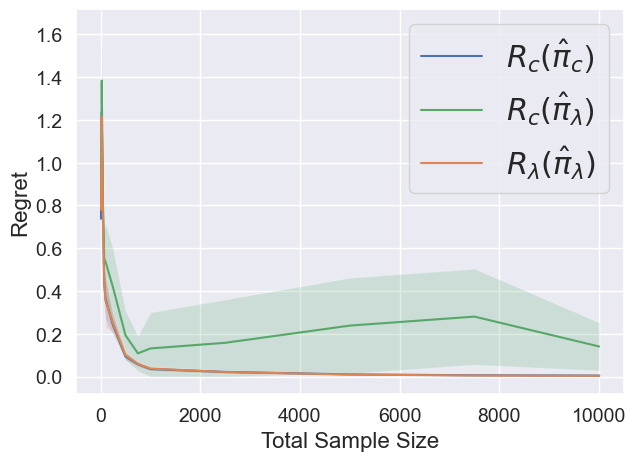

In [43]:
x = ss_range

c=5
plt.rcParams['figure.figsize'] = [c*np.sqrt(2), c*1]

sns.set_theme()
cp = sns.color_palette()
custom_color_order = [cp[0], cp[2], cp[1]]
sns.set_palette(custom_color_order)

plt.plot(x, local_regrets_smooth, label=r'$R_c(\hat{\pi}_c$)')
plt.fill_between(x, local_regrets_smooth - local_regrets_std_smooth, local_regrets_smooth + local_regrets_std_smooth, alpha=0.2)

plt.plot(x, fed_local_regrets_smooth, label=r'$R_c(\hat{\pi}_\lambda$)')
plt.fill_between(x, np.clip(fed_local_regrets_smooth - fed_local_regrets_std_smooth, 0, None), fed_local_regrets_smooth + fed_local_regrets_std_smooth, alpha=0.2)

plt.plot(x, global_regrets_smooth, label=r'$R_\lambda(\hat{\pi}_\lambda)$')
plt.fill_between(x, global_regrets_smooth - global_regrets_std_smooth, global_regrets_smooth + global_regrets_std_smooth, alpha=0.2)

plt.xlabel('Total Sample Size', fontsize=16)
plt.ylabel('Regret', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.title(r'Heterogeneous Clients, Empirical Mixture $\lambda=\bar{n}$', loc="left")
plt.legend(fontsize=22)
# plt.show()

# plt.savefig('./data/heterogeneous-client2-exp2_real.png', dpi=300)